#Metacatalogue

Notebook by Melinee Her

Cleans the megacatalogue and harmonizes ORACC data with CDLI catalogue.


#Merging the cdli_cat and megacat_mini

1. Read in the [cdli_cat_short csv](https://docs.google.com/spreadsheets/d/1wiViebAL3xGGwV75cKIr41beRX-Lxuj4u8y1ET8I27Y/edit?usp=sharing)
  * This can be replaced by the workflow in this notebook: https://drive.google.com/file/d/1yhM_8fgF6p89E3qiH1LRK4EgEau7HLuT/view?usp=sharing
  * This notebook also provides the headers / format for LOD triples in FactGrid.
2. Match the CDLI `id_text` with the ORACC `id_text` in ORACC [Megacatalog_short](https://docs.google.com/spreadsheets/d/
1iyvVpt5DrkF22Cd_p_oWHZfHsd6NzcvUlowS2_7Cm2U/edit?usp=sharing)

3. After the preliminary matching of the fields, we will want to make a final subset of the columns we will add to our Wikibase in FactGrid. To do this we also need to see if the values are different for a given field.
* Is there a way to highlight different values which we expect to be the same?

4. Lastly, using this notebook, we will obtain the proper Wikibase formatting for FactGrid header fields: https://drive.google.com/file/d/1yhM_8fgF6p89E3qiH1LRK4EgEau7HLuT/view?usp=sharing
* the subset of 8 fields we selected is only the beginning, but it is a good start.
* If the values are identical we can use the Q-items and build the final CSV for a [QuickStatements]() import.

# Mount Google Drive folder + imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#any necessary imports
import pandas as pd
import zipfile
from zipfile import ZipFile
import json
import requests
from tqdm import tqdm
import os
import errno
import re
import random
import numpy as np
import sys
import copy
import networkx as nx
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import collections

#Set folder for remote drive
#folder = '/content/drive/My Drive/FactGrid Cuneiform (AWCA)/people/Melinee/'
folder = '/content/drive/MyDrive/Melinee/'

#importing utils for the method which downloads the current text json files
os.chdir(folder + 'network/utils/')
from utils import oracc_download

# This is a user defined module that searches through the texts to find the entities in the text that
# are people and places, to be imported as nodes into the network
os.chdir(folder + 'network/')
import rank_parser4 as rp

pd.set_option('display.max_columns', None)

#Shortening the ORACC Megacatalogue

In this section of the notebook, we will create a smaller version of the megacatalogue, selectin a subset of columns to compare to the CDLI data when forming the metacatalogue.

Retrieving the megacatalogue

In [ ]:
#path = '/content/drive/MyDrive/FactGrid Cuneiform (AWCA)/people/Melinee/ORACC_DFS/megacatalogue.csv'
path = folder + 'ORACC_DFS/megacatalogue.csv'
megacatalogue = pd.read_csv(path, low_memory=False, index_col=0)

In [ ]:
megacatalogue.head(3)

,id_text,langs,project,id_text.1,primary_publication,provenience,pleiades_id,pleiades_coord,excavation_no,archive,atae_attribution,cite_as,collection,composite_witness,credits,date_of_origin,designation,dialect,genre,has_date,language,last_mod_by,last_modified,list_name,material,object_type,period,script,script_remarks,script_type,sealed_marked,subgenre,date,long_date,ancient_creditor,ancient_debtor,date_gen,day,long_date_gen,month,year,eponym,regnal_dates,ruler,ancient_buyer,ancient_seller,seal_mark_type,seal_owner,ancient_author,museum-nos,copies,photos,editions,translations,secondary-literatures,mus_no,publication_history,recipient,title,supergenre,xproject,uri,public,images,trans,q_number,translations-moran-1992s,copy,photo,museum_no,text_comments,accession_no,ancient_year,date_bce,months_recorded,tablet_comments,date_comments,bibilography,author,publication_date,atae_lists,cdli_id,cdli_museum_no,ch_name,ch_no,ch_num_name,comp_wit,display_name,edited_twice,lka_no,oracc_header,other_pub,please_cite,proposed_date,rework,saa_attribution,saa_cdli_id,saa_cdli_museum,saao_lists,secondary_record,short_title,vol_title,volume,pkt_no,cdli_excavation_no,editorial_comments,kar_no,saa_cdli_excavation,kav_no,eponym_title,dossier_list,kah_no,nargd_no,pkta_no,findspot_square,gpa_no,external_id,temp_id,tim_11_no,title_in_date,abl_no,ancient_recipient,cdli_accession_no,pleiades_sender_loc,saa_cdli_accession,sender_loc,sender_loc_coordinates,ct_54_no,astron_date,rma_no,prt_no,dossier,ags_no,add_no,ct_53_no,las_no,adb_no,ex1,ex1id,ex2,ex2id,ex3,ex3id,PRN,BM_ID,Reg_year,Reg_collection,Reg_no,ACQ_method,ACQ_name,ACQ_year,BibXref,Combined_no,DIM_H,PROV_area,PROV_site,OBJ_type,Period_culture,Script_type_1,Genre,Subgenre,S_s_genre,Language,Full_no,DIM_W,S_s_s_genre,Library_colophon,Bib_comment,BibSpec,PROV_building,Ruler,Composition,Tablet_number,Recension,NonLibrary_colophon,Reg_part,DIM_T,PROV_room,Mus_no,ACQ_comment,Historical_ID,Q_no,Day,Month,Year,Emesal,Script_type_2,unique_ID,museum_number,accession_number,sort_order,nme_chapter,object,findspot,museum,textname,bibliography,Original_collection,DIM_D,note,Mus_no_part,goal_year,seals_number,citation,subgenre_remarks,published_collation,period_remarks,fingernails_number,ctn_no,nl_no,BAK,id_composite,person,project name,dynastic_seat,popular_name,text_manu,related_comp_id,manu_number,related_manu,text_equals_manu,text_remarks,has-sources,atf_source,date_entered,date_updated,db_source,photo_up,translation_source,ark_number,id,id_text_int,stt_no,seal_id,object_preservation,object_remarks,exemplars,keywords,last_modified_by,place,series,status,rime_no,height,width,cdli_composite_id,created_by,created_on,last_modified_on,other_names,series_section,primary_edition,session,pleaides_id,date_remarks,editor,findspot_remarks,funder,language_remarks,lemmed,owner,principal,record_id,repository,translit_ed,uploaded,user,bibliography__id_biblio,bibliography__journal_title,bibliography__shortref,bibliography__volume_number,checked,photographed,photographer,proof-read,proof-reader,thickness,bibliography__book_title,pr_joins__pages,notes,provenience_remarks,stratigraphic_level,join_information,year_name_eponym,distribution,sources,provdist,CDLI_problems,bibliography__unpublished_title,ark,atf_up,dates_referenced,surface_preservation,composite,lineart_up,seal_information,google_earth_collection,collection_copyright,author_remarks,cdli_comments,acquisition_history,publication,ancient_date,has-score,last_edited_by,last_edited_on,bdtns_id,reference,Non_Sign_List_Series,series_2,cdli_collation,condition_description,tablet_number_2,number,tradition,corpus,attested,electronic_publication,buy_book,composition_designation,object_ref,lemcount,lemcount_total,lemcount_ave,text_total,lemount_sd,group,handcopy,pq_joins__external_id,qcat_2__id_composite,qcat_2__other_names,attribution,new_subgenre,primary_publication2,catchline,colophon_describing_source,colophon_disclosing_author,P_number_problems,royal_colophon,series_tablet

In [ ]:
#list(megacatalogue.columns)

Selecting for the columns listed above:

In [ ]:
megacatalogue_short = megacatalogue[[
    'composite_id', 'id', 'id_text', 'language', 'material', 'object_type', 'period','provenience','excavation_no','findspot_square','dates_referenced', 'genre', 'subgenre', 'translation_source',
    'archive','collection','museum-nos','mus_no','museum_no','cdli_museum_no','saa_cdli_museum','Mus_no','museum_number','museum','museum_URL',
    'date_of_origin', 'dialect', 'date', 'supergenre', 'xproject','q_number', 'ancient_year', 'date_bce', 'cdli_id', 'OBJ_type',
    'Period_culture', 'Script_type_1', 'Genre', 'Subgenre', 'S_s_genre','Language', 'Full_no', 'Tablet_number', 'Q_no', 'object',
    'id_composite', 'project name', 'id_text_int', 'seal_id','cdli_composite_id', 'ancient_date', 'bdtns_id']].dropna(how='all',axis=1)

megacatalogue_short = megacatalogue_short.rename(columns={'id_composite':'composite_id'})
megacatalogue_short

,id,id_text,language,material,object_type,period,provenience,excavation_no,findspot_square,dates_referenced,genre,subgenre,translation_source,archive,collection,museum-nos,mus_no,museum_no,cdli_museum_no,saa_cdli_museum,Mus_no,museum_number,museum,museum_URL,date_of_origin,dialect,date,supergenre,xproject,q_number,ancient_year,date_bce,cdli_id,OBJ_type,Period_culture,Script_type_1,Genre,Subgenre,S_s_genre,Language,Full_no,Tablet_number,Q_no,object,composite_id,project name,id_text_int,seal_id,cdli_composite_id,ancient_date,bdtns_id
0,NaN,P522592,Akkadian,clay,tablet,Neo-Assyrian,Tell Ahmar (Til Barsip),T 01,NaN,NaN,Administrative Record,list (rations),NaN,001 - Hanni Archive (House C1),"National Museum of Syria, Aleppo, Syria",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00.000.00.00,Neo-Assyrian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,adsd,NaN,NaN,NaN,NaN,NaN
1,NaN,P522593,Akkadian,clay,tablet,Neo-Assyrian,Tell Ahmar (Til Barsip),T 02,NaN,NaN,Legal Transaction,debt note,NaN,001 - Hanni Archive (House C1),"National Museum of Syria, Aleppo, Syria",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00.000.07.00,Neo-Assyrian,[...]-VII-[...],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,adsd,NaN,NaN,NaN,NaN,NaN
2,NaN,P522594,Akkadian,clay,envelope,Neo-Assyrian,Tell Ahmar (Til Barsip),T 03,NaN,NaN,Legal Transaction,NaN,NaN,001 - Hanni Archive (House C1),"National Museum of Syria, Aleppo, Syria",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Assurbanipal.limu Bel-Harran-shaddu’a.07.01,Neo-Assyrian,650-VII-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,adsd,NaN,NaN,NaN,NaN,NaN
3,NaN,P522595,Akkadian,clay,tablet,Neo-Assyrian,Tell Ahmar (Til Barsip),T 04,NaN,NaN,Legal Transaction,debt note (silver),NaN,001 - Hanni Archive (House C1),"National Museum of Syria, Aleppo, Syria",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Assurbanipal.limu Bel-Harran-shaddu’a.07.01,Neo-Assyrian,650-VII-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,adsd,NaN,NaN,NaN,NaN,NaN
4,NaN,P522596,Akkadian,clay,tablet,Neo-Assyrian,Tell Ahmar (Til Barsip),T 05,NaN,NaN,Legal Transaction,sales document,NaN,001 - Hanni Archive (House C1),"National Museum of Syria, Aleppo, Syria",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00.000.00.00,Neo-Assyrian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,adsd,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171140,NaN,P511531,Sumerian,NaN,seal (not impression),Old Babylonian,Girsu,T 1483,NaN,NaN,Administrative,physical cylinder seal,NaN,NaN,NaN,NaN,NaN,AO 16821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ELA,CDLI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epsd2/admin/oldbab,NaN,NaN,NaN,NaN,NaN
171141,NaN,X201001,NaN,NaN,NaN,Unknown,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epsd2/admin/oldbab,NaN,NaN,NaN,NaN,NaN
171142,NaN,X201002,NaN,NaN,NaN,Unknown,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epsd2/admin/oldbab,NaN,NaN,NaN,NaN,NaN
171143,NaN,X225104,NaN,NaN,NaN,Unknown,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epsd2/admin/oldbab,NaN,NaN,NaN,NaN,NaN


Exports megacatalogue_short to the folder ORACC_DFS

In [ ]:
megacatalogue_short.to_csv(folder + 'ORACC_DFS/megacatalogue_short.csv')

#Working with the CDLI catalogue

This section is loosely based off this [notebook](https://drive.google.com/file/d/1yhM_8fgF6p89E3qiH1LRK4EgEau7HLuT/view?usp=sharing).

In this section we will convert the [cdli_cat.csv](https://media.githubusercontent.com/media/cdli-gh/data/master/cdli_cat.csv) into a smaller dataframe called cdli_cat_short that contains only the following useful columns:

    * Language
    * Material
    * Museum
    * Provenience
    * Object type
    * Genre
    * Period
    * Date

Using this limited version of the cdli catalogue, we can draw comparisons with the oracc data.

Reading in the data:

In [ ]:
url = 'https://media.githubusercontent.com/media/cdli-gh/data/master/cdli_cat.csv'

data = pd.read_csv(url, sep=',', low_memory=False)
data.head(3)

,accession_no,accounting_period,acquisition_history,alternative_years,ark_number,atf_source,atf_up,author,author_remarks,cdli_collation,cdli_comments,citation,collection,composite_id,condition_description,date_entered,date_of_origin,date_remarks,date_updated,dates_referenced,db_source,designation,dumb,dumb2,electronic_publication,elevation,excavation_no,external_id,findspot_remarks,findspot_square,genre,google_earth_collection,google_earth_provenience,height,id,id_text2,id_text,join_information,language,lineart_up,material,museum_no,object_preservation,object_type,period,period_remarks,photo_up,primary_publication,provenience,provenience_remarks,publication_date,publication_history,published_collation,seal_id,seal_information,stratigraphic_level,subgenre,subgenre_remarks,surface_preservation,text_remarks,thickness,translation_source,width,object_remarks
0,NaN,NaN,NaN,NaN,21198/zz001q0dtm,"Englund, Robert K.",NaN,CDLI,"31x61x18; Lú A 14-16.30-32.48-50; M XVIII, auf...",NaN,NaN,NaN,"Vorderasiatisches Museum, Berlin, Germany",Q000002,NaN,12/4/2001,00.00.00.00,NaN,2020-03-14,00.00.00.00,20011204 protocuneiform_catalogue,"CDLI Lexical 000002, ex. 065",NaN,NaN,NaN,NaN,"W 06435,a",NaN,auf Hügeloberfläche in der Nähe des Südbaues,"M XVIII,?",Lexical,NaN,NaN,31,1,0,1,NaN,undetermined,150ppi 20160630,clay,VAT 01533,NaN,tablet,Uruk III (ca. 3200-3000 BC),NaN,NaN,"CDLI Lexical 000002, ex. 065",Uruk (mod. Warka),NaN,2015ff.,"Englund, Robert K. & Nissen, Hans J., ATU 3 (1...",NaN,NaN,NaN,NaN,Archaic Lu2 A (witness),NaN,NaN,NaN,18,no translation,61,NaN
1,NaN,NaN,NaN,NaN,21198/zz001q0dv4,"Englund, Robert K.",NaN,CDLI,30x48x13; Lú A 13-15.23-25.?; Fundstelle wie W...,NaN,NaN,NaN,"Vorderasiatisches Museum, Berlin, Germany",Q000002,NaN,12/4/2001,00.00.00.00,NaN,2018-10-20,00.00.00.00,20011204 protocuneiform_catalogue,"CDLI Lexical 000002, ex. 066",NaN,NaN,NaN,NaN,"W 06435,b",NaN,auf der Hügeloberfläche in der Nähe des Südbaues,"M XVIII,?",Lexical,NaN,NaN,30,2,0,2,NaN,undetermined,150ppi 20160630,clay,VAT 15263,NaN,tablet,Uruk III (ca. 3200-3000 BC),NaN,NaN,"CDLI Lexical 000002, ex. 066",Uruk (mod. Warka),NaN,2015ff.,"Englund, Robert K. & Nissen, Hans J., ATU 3 (1...",NaN,NaN,NaN,NaN,Archaic Lu2 A (witness),NaN,NaN,NaN,13,no translation,48,NaN
2,NaN,NaN,NaN,NaN,21198/zz001q0dwn,"Englund, Robert K.",NaN,"Englund, Robert K. & Nissen, Hans J.","42x53x19; Vocabulary 9; Qa XVI,2, unter der Ab...",NaN,NaN,NaN,"Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,12/4/2001,NaN,NaN,2020-01-26,NaN,20011204 protocuneiform_catalogue,"ATU 3, pl. 081, W 9123,d",NaN,NaN,NaN,NaN,"W 09123,d",NaN,"unter der Abgleichung der Schicht III, 1,5 m ü...","Qa XVI,2",Lexical,NaN,NaN,42,3,0,3,NaN,undetermined,150ppi 20160630,clay,VAT 15253,NaN,tablet,Uruk IV (ca. 3350-3200 BC),NaN,NaN,"ATU 3, pl. 081, W 9123,d",Uruk (mod. Warka),NaN,1993,"ATU 1, 539",NaN,NaN,NaN,NaN,Archaic Vocabulary (witness),Text category: 15-09; Foreign ID: LVO 9,NaN,NaN,19,no translation,53,NaN


<bound method Series.unique of 0         0
1         0
2         0
3         0
4         0
         ..
353278    0
353279    0
353280    0
353281    0
353282    0
Name: id_text2, Length: 353283, dtype: int64>

Create a subset of the cdli catalogue named 'data' with the columns of interest

In [ ]:
#list(data.columns)

In [ ]:
cdli_cat_short = data[['composite_id', 'id_text2', 'id_text', 'language', 'object_type', 'period', 'material', 'collection', 'museum_no','provenience', 'excavation_no','findspot_square','date_of_origin',
       'dates_referenced', 'genre', 'subgenre', 'translation_source']].dropna(how='all',axis=1).fillna('')

cdli_cat_short

,composite_id,id_text2,id_text,language,object_type,period,material,collection,museum_no,provenience,excavation_no,findspot_square,date_of_origin,dates_referenced,genre,subgenre,translation_source
0,Q000002,0,1,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 01533,Uruk (mod. Warka),"W 06435,a","M XVIII,?",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation
1,Q000002,0,2,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15263,Uruk (mod. Warka),"W 06435,b","M XVIII,?",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation
2,,0,3,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15253,Uruk (mod. Warka),"W 09123,d","Qa XVI,2",,,Lexical,Archaic Vocabulary (witness),no translation
3,Q000002,0,4,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15168,Uruk (mod. Warka),"W 09169,d","Qa XVI,2",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation
4,Q000002,0,5,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15153,Uruk (mod. Warka),"W 09206,k","Qa XVI,2",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353278,,0,532443,Sumerian,tablet,Old Babylonian (ca. 1900-1600 BC),clay,"National Museum of Iraq, Baghdad, Iraq",IM —,Marad (mod. Wanna-wa-Sadum),Marad 047,,,,Legal,,no translation
353279,,0,532444,Akkadian,tablet,Old Babylonian (ca. 1900-1600 BC),clay,"National Museum of Iraq, Baghdad, Iraq",IM —,,TA 2100,,,,Administrative,,no translation
353280,,0,532445,Akkadian,tablet,Old Babylonian (ca. 1900-1600 BC),clay,"National Museum of Iraq, Baghdad, Iraq",IM —,,TA 2101,,,,Administrative,,no translation
353281,,0,532446,Akkadian,tablet & envelope,Old Babylonian (ca. 1900-1600 BC),clay,"private: William T. Grant Jr., Pelham Manor, N...",Grant 17,Larsa (mod. Tell as-Senkereh),,,,,Legal,,no translation


Exports cdli_cat_short to the folder ORACC_DFS

In [ ]:
cdli_cat_short.to_csv(folder + 'ORACC_DFS/cdli_cat_short.csv')

#Creating the Metacatalogue

Using the CDLI shortened catalogue and the ORACC shortened catalogue, we can create a Metacatalogue- a combination of both catalogues.

The following codecell allows for importing the megacatalogue short and cdli cat short to run the following cells independently of the first half of this notebook.

In [ ]:
#cshortpath = '/content/drive/MyDrive/FactGrid Cuneiform (AWCA)/people/Melinee/ORACC_DFS/cdli_cat_short.csv'
#mshortpath = '/content/drive/MyDrive/FactGrid Cuneiform (AWCA)/people/Melinee/ORACC_DFS/megacatalogue_short.csv'
cshortpath = folder + 'ORACC_DFS/cdli_cat_short.csv'
mshortpath = folder + 'ORACC_DFS/megacatalogue_short.csv'
cdli_cat_short = pd.read_csv(cshortpath, low_memory=False, index_col=0)
megacatalogue_short = pd.read_csv(mshortpath, low_memory=False, index_col=0)

In [ ]:
print(cdli_cat_short.shape)
cdli_cat_short.head(3)

(353283, 17)


,composite_id,id_text2,id_text,language,object_type,period,material,collection,museum_no,provenience,excavation_no,findspot_square,date_of_origin,dates_referenced,genre,subgenre,translation_source
0,Q000002,0,1,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 01533,Uruk (mod. Warka),"W 06435,a","M XVIII,?",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation
1,Q000002,0,2,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15263,Uruk (mod. Warka),"W 06435,b","M XVIII,?",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation
2,NaN,0,3,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15253,Uruk (mod. Warka),"W 09123,d","Qa XVI,2",NaN,NaN,Lexical,Archaic Vocabulary (witness),no translation


Changing the column 'id_text' to be in the form P+6 numbers in order to match with the ORACC ids

In [ ]:
cdli_cat_short['id_text'] = ['P'+str(id).zfill(6) for id in cdli_cat_short['id_text']]
cdli_cat_short.head(3)

,composite_id,id_text2,id_text,language,object_type,period,material,collection,museum_no,provenience,excavation_no,findspot_square,date_of_origin,dates_referenced,genre,subgenre,translation_source
0,Q000002,0,P000001,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 01533,Uruk (mod. Warka),"W 06435,a","M XVIII,?",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation
1,Q000002,0,P000002,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15263,Uruk (mod. Warka),"W 06435,b","M XVIII,?",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation
2,NaN,0,P000003,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15253,Uruk (mod. Warka),"W 09123,d","Qa XVI,2",NaN,NaN,Lexical,Archaic Vocabulary (witness),no translation


In [ ]:
print(megacatalogue_short.shape)
megacatalogue_short.head(3)

(171145, 51)


,id,id_text,language,material,object_type,period,provenience,excavation_no,findspot_square,dates_referenced,genre,subgenre,translation_source,archive,collection,museum-nos,mus_no,museum_no,cdli_museum_no,saa_cdli_museum,Mus_no,museum_number,museum,museum_URL,date_of_origin,dialect,date,supergenre,xproject,q_number,ancient_year,date_bce,cdli_id,OBJ_type,Period_culture,Script_type_1,Genre,Subgenre,S_s_genre,Language,Full_no,Tablet_number,Q_no,object,composite_id,project name,id_text_int,seal_id,cdli_composite_id,ancient_date,bdtns_id
0,NaN,P522592,Akkadian,clay,tablet,Neo-Assyrian,Tell Ahmar (Til Barsip),T 01,NaN,NaN,Administrative Record,list (rations),NaN,001 - Hanni Archive (House C1),"National Museum of Syria, Aleppo, Syria",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00.000.00.00,Neo-Assyrian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,adsd,NaN,NaN,NaN,NaN,NaN
1,NaN,P522593,Akkadian,clay,tablet,Neo-Assyrian,Tell Ahmar (Til Barsip),T 02,NaN,NaN,Legal Transaction,debt note,NaN,001 - Hanni Archive (House C1),"National Museum of Syria, Aleppo, Syria",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00.000.07.00,Neo-Assyrian,[...]-VII-[...],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,adsd,NaN,NaN,NaN,NaN,NaN
2,NaN,P522594,Akkadian,clay,envelope,Neo-Assyrian,Tell Ahmar (Til Barsip),T 03,NaN,NaN,Legal Transaction,NaN,NaN,001 - Hanni Archive (House C1),"National Museum of Syria, Aleppo, Syria",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Assurbanipal.limu Bel-Harran-shaddu’a.07.01,Neo-Assyrian,650-VII-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,adsd,NaN,NaN,NaN,NaN,NaN


Creation of the Metacatalogue

This dataframe merges the cdli_cat_short and megacatalogue_short DFs based on the "id_text" column. It contains the rows where id_text matches and doesnt match. Any column marked as column_x belongs to the CDLI catalogue and any column marked as column_y belongs to the ORACC catalogue.

Note

In [ ]:
metacatalogue = pd.merge(cdli_cat_short, megacatalogue_short, on="id_text", how = 'outer')
metacatalogue

,composite_id_x,id_text2,id_text,language_x,object_type_x,period_x,material_x,collection_x,museum_no_x,provenience_x,excavation_no_x,findspot_square_x,date_of_origin_x,dates_referenced_x,genre_x,subgenre_x,translation_source_x,id,language_y,material_y,object_type_y,period_y,provenience_y,excavation_no_y,findspot_square_y,dates_referenced_y,genre_y,subgenre_y,translation_source_y,archive,collection_y,museum-nos,mus_no,museum_no_y,cdli_museum_no,saa_cdli_museum,Mus_no,museum_number,museum,museum_URL,date_of_origin_y,dialect,date,supergenre,xproject,q_number,ancient_year,date_bce,cdli_id,OBJ_type,Period_culture,Script_type_1,Genre,Subgenre,S_s_genre,Language,Full_no,Tablet_number,Q_no,object,composite_id_y,project name,id_text_int,seal_id,cdli_composite_id,ancient_date,bdtns_id
0,Q000002,0.0,P000001,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 01533,Uruk (mod. Warka),"W 06435,a","M XVIII,?",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation,NaN,undetermined,clay,tablet,Uruk III,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
1,Q000002,0.0,P000002,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15263,Uruk (mod. Warka),"W 06435,b","M XVIII,?",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation,NaN,undetermined,clay,tablet,Uruk III,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
2,NaN,0.0,P000003,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15253,Uruk (mod. Warka),"W 09123,d","Qa XVI,2",NaN,NaN,Lexical,Archaic Vocabulary (witness),no translation,NaN,undetermined,clay,tablet,Uruk IV,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
3,Q000002,0.0,P000004,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15168,Uruk (mod. Warka),"W 09169,d","Qa XVI,2",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation,NaN,undetermined,clay,tablet,Uruk IV,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
4,Q000002,0.0,P000005,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15153,Uruk (mod. Warka),"W 09206,k","Qa XVI,2",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation,NaN,undetermined,clay,tablet,Uruk IV,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366911,NaN,NaN,X096677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epsd2/earlylit,NaN,NaN,NaN,NaN,NaN
366912,NaN,NaN,X201001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

Export the metacatalogue

In [ ]:
metacatalogue.to_csv(folder + 'ORACC_DFS/metacatalogue.csv')

##Comparisons between matching CDLI and ORACC headers

One thing we can do is to place like-columns from each dataframe side by side. By reformatting the metacatalogue in this way, it may make columns easier to compare at a glance.


In [ ]:
metacatalogue_sorted = metacatalogue[['id_text', 'id_text2','composite_id_x', 'composite_id_y', 'language_x', 'language_y', 'material_x', 'material_y', 'object_type_x', 'object_type_y',
    'period_x', 'period_y', 'dates_referenced_x', 'dates_referenced_y', 'genre_x', 'genre_y', 'subgenre_x', 'subgenre_y', 'translation_source_x', 'translation_source_y', 'provenience_x','provenience_y','excavation_no_x','excavation_no_y','findspot_square_x','findspot_square_y',
    'date_of_origin_x', 'date_of_origin_y','museum_no_x','museum_no_y','collection_x','collection_y','dialect', 'date', 'supergenre', 'xproject','q_number', 'ancient_year', 'date_bce', 'cdli_id', 'OBJ_type',
    'Period_culture', 'Script_type_1', 'Genre', 'Subgenre', 'S_s_genre','Language', 'Full_no', 'Tablet_number', 'Q_no', 'object',
    'project name', 'id_text_int', 'seal_id','cdli_composite_id', 'ancient_date', 'bdtns_id']]

#print(metacatalogue_sorted.shape)
metacatalogue_sorted

,id_text,id_text2,composite_id_x,composite_id_y,language_x,language_y,material_x,material_y,object_type_x,object_type_y,period_x,period_y,dates_referenced_x,dates_referenced_y,genre_x,genre_y,subgenre_x,subgenre_y,translation_source_x,translation_source_y,provenience_x,provenience_y,excavation_no_x,excavation_no_y,findspot_square_x,findspot_square_y,date_of_origin_x,date_of_origin_y,museum_no_x,museum_no_y,collection_x,collection_y,dialect,date,supergenre,xproject,q_number,ancient_year,date_bce,cdli_id,OBJ_type,Period_culture,Script_type_1,Genre,Subgenre,S_s_genre,Language,Full_no,Tablet_number,Q_no,object,project name,id_text_int,seal_id,cdli_composite_id,ancient_date,bdtns_id
0,P000001,0.0,Q000002,NaN,undetermined,undetermined,clay,clay,tablet,tablet,Uruk III (ca. 3200-3000 BC),Uruk III,00.00.00.00,NaN,Lexical,Lexical,Archaic Lu2 A (witness),NaN,no translation,NaN,Uruk (mod. Warka),Warka (Uruk),"W 06435,a",NaN,"M XVIII,?",NaN,00.00.00.00,NaN,VAT 01533,NaN,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
1,P000002,0.0,Q000002,NaN,undetermined,undetermined,clay,clay,tablet,tablet,Uruk III (ca. 3200-3000 BC),Uruk III,00.00.00.00,NaN,Lexical,Lexical,Archaic Lu2 A (witness),NaN,no translation,NaN,Uruk (mod. Warka),Warka (Uruk),"W 06435,b",NaN,"M XVIII,?",NaN,00.00.00.00,NaN,VAT 15263,NaN,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
2,P000003,0.0,NaN,NaN,undetermined,undetermined,clay,clay,tablet,tablet,Uruk IV (ca. 3350-3200 BC),Uruk IV,NaN,NaN,Lexical,Lexical,Archaic Vocabulary (witness),NaN,no translation,NaN,Uruk (mod. Warka),Warka (Uruk),"W 09123,d",NaN,"Qa XVI,2",NaN,NaN,NaN,VAT 15253,NaN,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
3,P000004,0.0,Q000002,NaN,undetermined,undetermined,clay,clay,tablet,tablet,Uruk IV (ca. 3350-3200 BC),Uruk IV,00.00.00.00,NaN,Lexical,Lexical,Archaic Lu2 A (witness),NaN,no translation,NaN,Uruk (mod. Warka),Warka (Uruk),"W 09169,d",NaN,"Qa XVI,2",NaN,00.00.00.00,NaN,VAT 15168,NaN,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
4,P000005,0.0,Q000002,NaN,undetermined,undetermined,clay,clay,tablet,tablet,Uruk IV (ca. 3350-3200 BC),Uruk IV,00.00.00.00,NaN,Lexical,Lexical,Archaic Lu2 A (witness),NaN,no translation,NaN,Uruk (mod. Warka),Warka (Uruk),"W 09206,k",NaN,"Qa XVI,2",NaN,00.00.00.00,NaN,VAT 15153,NaN,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366911,X096677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epsd2/earlylit,NaN,NaN,NaN,NaN,NaN
366912,X201001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,epsd2/admin/oldbab,NaN,NaN,NaN,NaN,NaN
366913,X201002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
for i in ['composite_id', 'language', 'material', 'object_type', 'period','dates_referenced', 'genre', 'subgenre', 'translation_source', 'provenience','excavation_no','findspot_square','date_of_origin','museum_no','collection']:
   print(i + ' has ' + str((metacatalogue[i+'_x'] == metacatalogue[i+'_y']).sum()) + ' matches.')

composite_id has 0 matches.
language has 118158 matches.
material has 38616 matches.
object_type has 55576 matches.
period has 27 matches.
dates_referenced has 822 matches.
genre has 103568 matches.
subgenre has 13825 matches.
translation_source has 356 matches.
provenience has 1032 matches.
excavation_no has 8008 matches.
findspot_square has 651 matches.
date_of_origin has 8299 matches.
museum_no has 59600 matches.
collection has 38805 matches.


In [ ]:
#print(metacatalogue['language_x'].value_counts())
#print()
#print(metacatalogue['language_y'].value_counts())

As we can see, there are no perfectly overlapping columns for CDLI and ORACC.

## Subsets based on Object Type

This section will have a heavier emphasis on tablet, envelope and cone objects.

As a note, I think there are some incentives to keeping the CDLI and ORACC object type information separate from each other (object_type_x,object_type_y) so we can have a better idea of how each text was catalogued.

**Understanding the Code Below:**

Despite reasons to keep the object type columns separate, an alternate column (object_type_both) can be made by joining the string content of each column together to make quering through the metacatalogue easier. *This can be done for other columns with similar data information (e.g. period, language, ...)*

In order to get the subset of the DF, we can look at if the object type column contains partial strings like 'ablet', 'nvelope', and 'one'. (This is shortcut way of not accounting for upper or lowercase starts to the words tablet, envelope, and cone.)

As we'll see, the ORACC descriptions are either more descriptive (e.g. 'Envelope - Closed') or confusing (e.g. 'brick, stone block, tablet, door socket, cone').

One can query through to find just tables, just envelopes, and just cones as seen in a following code cell.

In [ ]:
#Run this cell to look at all types of objects presented from each catalogue in the metacatalogue
#print(metacatalogue['object_type_x'].unique())
#print(metacatalogue['object_type_y'].unique())

In [ ]:
metacatalogue['object_type_both'] = metacatalogue['object_type_x'] + ', ' + metacatalogue['object_type_y']

In [ ]:
subset = metacatalogue.loc[metacatalogue['object_type_both'].str.contains("ablet|nvelope|one")==True]
subset

,composite_id_x,id_text2,id_text,language_x,object_type_x,period_x,material_x,collection_x,museum_no_x,provenience_x,excavation_no_x,findspot_square_x,date_of_origin_x,dates_referenced_x,genre_x,subgenre_x,translation_source_x,id,language_y,material_y,object_type_y,period_y,provenience_y,excavation_no_y,findspot_square_y,dates_referenced_y,genre_y,subgenre_y,translation_source_y,archive,collection_y,museum-nos,mus_no,museum_no_y,cdli_museum_no,saa_cdli_museum,Mus_no,museum_number,museum,museum_URL,date_of_origin_y,dialect,date,supergenre,xproject,q_number,ancient_year,date_bce,cdli_id,OBJ_type,Period_culture,Script_type_1,Genre,Subgenre,S_s_genre,Language,Full_no,Tablet_number,Q_no,object,composite_id_y,project name,id_text_int,seal_id,cdli_composite_id,ancient_date,bdtns_id,object_type_both
0,Q000002,0.0,P000001,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 01533,Uruk (mod. Warka),"W 06435,a","M XVIII,?",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation,NaN,undetermined,clay,tablet,Uruk III,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN,"tablet, tablet"
1,Q000002,0.0,P000002,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15263,Uruk (mod. Warka),"W 06435,b","M XVIII,?",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation,NaN,undetermined,clay,tablet,Uruk III,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN,"tablet, tablet"
2,NaN,0.0,P000003,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15253,Uruk (mod. Warka),"W 09123,d","Qa XVI,2",NaN,NaN,Lexical,Archaic Vocabulary (witness),no translation,NaN,undetermined,clay,tablet,Uruk IV,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN,"tablet, tablet"
3,Q000002,0.0,P000004,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15168,Uruk (mod. Warka),"W 09169,d","Qa XVI,2",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation,NaN,undetermined,clay,tablet,Uruk IV,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN,"tablet, tablet"
4,Q000002,0.0,P000005,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15153,Uruk (mod. Warka),"W 09206,k","Qa XVI,2",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation,NaN,undetermined,clay,tablet,Uruk IV,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN,"tablet, tablet"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352907,NaN,0.0,P532071,Akkadian,tablet,Middle Assyrian (ca. 1400-1000 BC),clay,"National Museum of Syria, Damascus, Syria ?",NaN,Kahat (mod. Tell Barri),K21.E.3386,NaN,NaN,NaN,Administrative,NaN,NaN,NaN,Middle Assyrian,NaN,tablet,Middle Assyrian,Kahat (Mod. Te

To query the metacatalogue for a specific object type:

```
metacatalogue.loc[metacatalogue['object_type_both'].str.contains('object_of_interest')==True]
```



For example here's a subset of the metacatalogue for objects that are marked as a type of seal.

In [ ]:
subset_seal = metacatalogue.loc[metacatalogue['object_type_both'].str.contains('seal|Seal')==True]
subset_seal

,composite_id_x,id_text2,id_text,language_x,object_type_x,period_x,material_x,collection_x,museum_no_x,provenience_x,excavation_no_x,findspot_square_x,date_of_origin_x,dates_referenced_x,genre_x,subgenre_x,translation_source_x,id,language_y,material_y,object_type_y,period_y,provenience_y,excavation_no_y,findspot_square_y,dates_referenced_y,genre_y,subgenre_y,translation_source_y,archive,collection_y,museum-nos,mus_no,museum_no_y,cdli_museum_no,saa_cdli_museum,Mus_no,museum_number,museum,museum_URL,date_of_origin_y,dialect,date,supergenre,xproject,q_number,ancient_year,date_bce,cdli_id,OBJ_type,Period_culture,Script_type_1,Genre,Subgenre,S_s_genre,Language,Full_no,Tablet_number,Q_no,object,composite_id_y,project name,id_text_int,seal_id,cdli_composite_id,ancient_date,bdtns_id,object_type_both
9024,NaN,0.0,P100295,Sumerian,tablet,Ur III (ca. 2100-2000 BC),clay,"private: Böllinger, Endorf, Germany",Böllinger 6,uncertain (mod. uncertain),NaN,NaN,--.--.00.00,--.--.00.00,Administrative,NaN,no translation,NaN,Sumerian,NaN,Cylinder Seal,Ur III,unknown,NaN,NaN,NaN,Administrative,NaN,NaN,NaN,NaN,NaN,NaN,Boellinger 6,NaN,NaN,NaN,NaN,NaN,NaN,0000 - 00 - 00,NaN,NaN,ELA,CDLI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,babcity,NaN,NaN,NaN,NaN,18056.0,"tablet, Cylinder Seal"
24607,NaN,0.0,P115924,Sumerian,sealing,Ur III (ca. 2100-2000 BC),clay,"Bibliothèque de Versailles, Versailles, France",BV 19,Umma (mod. Tell Jokha),NaN,NaN,00.00.00.00,00.00.00.00,Administrative,NaN,no translation,NaN,Sumerian,NaN,Label,Ur III,Umma,NaN,NaN,NaN,Administrative,NaN,NaN,NaN,NaN,NaN,NaN,BV 19,NaN,NaN,NaN,NaN,NaN,NaN,0000 - 00 - 00,NaN,NaN,ELA,CDLI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,babcity,NaN,NaN,NaN,NaN,23252.0,"sealing, Label"
32007,NaN,0.0,P123204,Sumerian,tablet,Ur III (ca. 2100-2000 BC),clay,"Oriental Institute, University of Chicago, Chi...",OIM A—,Ešnunna (mod. Tell Asmar),TA 1930 0277,NaN,Šulgi.--.00.00,Šulgi.--.00.00,Administrative,NaN,no translation,NaN,Sumerian,NaN,Clay sealing,Ur III,Ešnunna,TA 1930 0277,NaN,NaN,Administrative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000 - 00 - 00,NaN,NaN,ELA,CDLI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,babcity,NaN,NaN,NaN,NaN,12191.0,"tablet, Clay sealing"
32008,NaN,0.0,P123205,Sumerian,tablet,Ur III (ca. 2100-2000 BC),clay,"Oriental Institute, University of Chicago, Chi...",OIM A—,Ešnunna (mod. Tell Asmar),TA 1931 0320,NaN,Amar-Sin.--.00.00,Amar-Sin.--.00.00,Administrative,NaN,no translation,NaN,Sumerian,NaN,Clay sealing,Ur III,Ešnunna,TA 1931 0320,NaN,NaN,Royal Inscription,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000 - 00 - 00,NaN,NaN,LIT,CDLI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,babcity,NaN,NaN,NaN,NaN,12192.0,"tablet, Clay sealing"
32010,NaN,0.0,P123207,Sumerian,tablet,Ur III (ca. 2100-2000 BC),clay,"Oriental Institute, University of Chicago, Chi...",OIM A—,Ešnunna (mod. Tell Asmar),TA 1931 0379,NaN,--.--.00.00,--.--.00.00,Administrative,NaN,no translation,NaN,Sumerian,NaN,Clay sealing,Ur III,Ešnunna,TA 1931 0379,NaN,NaN,Administrative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000 - 00 - 00,NaN,NaN,ELA,CDLI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,babcity,NaN,NaN,NaN,NaN,12194.0,"tablet, Clay sealing"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343013,NaN,0.0,P522007,Sumerian,seal (not impression),Ur III (ca. 2100-2000 BC),stone ?,NaN,NaN,Girsu (mod. Tello),NaN,NaN,NaN,NaN,Administrative,NaN,NaN,NaN,Sumerian,NaN,seal (not impression),Ur III,Girsu,NaN,NaN,NaN,Administrative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ELA,CDLI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,babcity,NaN,NaN,NaN

#Fitting Proper FactGrid Headers
Adapted from the [cdli_cat.ipynb](https://drive.google.com/file/d/1yhM_8fgF6p89E3qiH1LRK4EgEau7HLuT/view?usp=sharing) notebook.

In [21]:
#import metacatalogue
metacatalogue = pd.read_csv(folder + '/ORACC_DFS/metacatalogue.csv', low_memory=False, index_col=0)

## 1 Language = Language (P18) + uncertainty (P155)
For reference, let's start with the languages listed in the CDLI catalog.
In order to avoid adding question marks to these language items, we use the statement 'how sure is this' [P155](https://database.factgrid.de/wiki/Property:P155), that logs the language item as 'questionable, not settled, ?' [Q160240](https://database.factgrid.de/wiki/Item:Q160240)

In [22]:
lang_url = 'https://github.com/ancient-world-citation-analysis/CDLI2LoD/blob/main/data/Language%20-%20LOD%20Tablet%20Dictionary%20(FG%20Cuneiform).csv?raw=true'

lang_reference = pd.read_csv(lang_url, sep = ',')
# drop the first row that is empty
lang_reference = lang_reference.iloc[1: , :]
# drop the sequence column
lang_reference = lang_reference.drop(columns = ['Sequence'])
# fill na values with space
lang_reference = lang_reference.fillna('')
# drop duplicated rows
lang_reference = lang_reference.drop_duplicates(keep = "first")
# use only rows with a QID
lang_reference = lang_reference[lang_reference['FG_item'] != ''].reset_index()
lang_reference

,index,Parent,Language,FG_item
0,10,Elamite,Elamite,Q500430
1,12,Hurrian,Hurrian,Q512052
2,13,Hittite,Hittite,Q500429
3,14,Hittite,Hittite Logographic,Q500429
4,15,Ugaritic,Ugaritic,Q500431
5,17,Arabic,Arabic,Q389598
6,18,Aramaic,Aramaic,Q393615
7,19,Akkadian,Eblaite,Q471146
8,20,Greek,Greek,Q172951
9,21,Hebrew,Hebrew,Q389600


### 1.1 Starting with the CDLI languages, we can match unique languages to their FG language id

In [23]:
language_df = metacatalogue[['id_text', 'language_x']]
language_df.head()

,id_text,language_x
0,P000001,undetermined
1,P000002,undetermined
2,P000003,undetermined
3,P000004,undetermined
4,P000005,undetermined


In [24]:
langx = language_df['language_x']

#drop clay from langx because that is not a language
language_df.loc[language_df['language_x'] == 'clay', 'language_x'] == ''
# there are two different entries of NA, merge them into one
language_df.loc[language_df['language_x'] == '-', 'language_x'] == ''
# remove the '\x0b' patterns
language_df.loc[language_df['language_x'] == np.array([re.sub('\x0b', '', string = str(langx[i])) for i in range(len(langx))])]

langx.unique()

array(['undetermined', 'Sumerian', 'Sumerian ?', 'Akkadian', nan,
       'Sumerian; Akkadian', 'Elamite', 'Akkadian; Elamite', 'Hurrian',
       'Akkadian ?', 'Eblaite', 'Akkadian; Elamite; Persian; Egyptian ?',
       '\x0b', 'Ugaritic', 'undetermined (pseudo)', 'Aramaic',
       'Sumerian; Akkadian (pseudo)', 'no linguistic content',
       'Akkadian; Persian; Elamite; Egyptian ', 'Hebrew', 'Aramaic ?',
       'Akkadian; Aramaic', 'Hebrew ?', 'Greek', 'Phoenician', 'Sabaean',
       'Hittite', 'Akkadian; Egyptian', 'Hurrian ?', 'Qatabanian',
       'uncertain', 'Persian', 'Hittite ?', 'Hittite; Hattic', 'Syriac',
       'Mandaic', 'Hittite; Hurrian', 'uninscribed', 'Akkadian\x0b',
       'Akkadian\x0b\x0b', 'Sumerian; Akkadian ?', 'Egyptian ?',
       'Akkadian; Elamite; Persian', 'Arabic', 'Akkadian; Greek',
       'Urartian', 'Akkadian; Elamite; Persian; Egyptian',
       'Akkadian; Persian', 'Egyptian', 'Luwian',
       'Persian; Elamite; Akkadian', 'Akkadian; Persian; Elamite',
 

In [25]:
first_lang = []
first_lang_qid = []
first_lang_parent = []
P155_lang = [] # when there's a question mark
other_lang = [] # when multiple langauges
no_match_indices_lang = [] # index of the row if there's no match

for index in range(len(language_df['language_x'])):
  l = str(language_df.iloc[index,1])
  #print(l)
  # remove the space in every entry and split it by ;
  lst = l.replace(' ', '').replace(',', ';').split(';')

  # get the first language
  first_l = lst[0]

  # store the remaining languages (if exist) away
  other_lang += [', '.join(lst[1:])]

  # check for uncertaint
  if '?' in first_l:
    P155_lang += ['Q22757']
    first_l = first_l.replace('?', '')
  else:
    P155_lang += ['']

  # add in qid and parent for the first_l

  # if the language has a QID in FactGrid
  if first_l in lang_reference['Language'].unique():
    # record the language
    first_lang += [first_l]
    # get the corresponding QID (FG_item) and Parent
    i = lang_reference['Language'].tolist().index(first_l)
    first_lang_qid += [lang_reference['FG_item'][i]]
    first_lang_parent += [lang_reference['Parent'][i]]

  # if the language does not have a FactGrid QID, put '' for everything for now
  else:
    first_lang += ['']
    first_lang_qid += ['']
    first_lang_parent += ['']
    no_match_indices_lang += [index]

# append these columns to the dataframe
language_df['first_lang'] = first_lang
language_df['first_lang_qid'] = first_lang_qid
language_df['first_lang_parent'] = first_lang_parent
language_df['P155_lang'] = P155_lang
language_df['other_lang'] = other_lang

# update the names of columns to be clearer
language_df = language_df.rename(columns={'language_x': 'cdli_language_dump'})

print("dump refers to an unnecessary column from original data")
language_df

dump refers to an unnecessary column from original data


<ipython-input-25-840c174fe2ce>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language_df['first_lang'] = first_lang
<ipython-input-25-840c174fe2ce>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language_df['first_lang_qid'] = first_lang_qid
<ipython-input-25-840c174fe2ce>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,id_text,cdli_language_dump,first_lang,first_lang_qid,first_lang_parent,P155_lang,other_lang
0,P000001,undetermined,,,,,
1,P000002,undetermined,,,,,
2,P000003,undetermined,,,,,
3,P000004,undetermined,,,,,
4,P000005,undetermined,,,,,
...,...,...,...,...,...,...,...
366911,X096677,NaN,,,,,
366912,X201001,NaN,,,,,
366913,X201002,NaN,,,,,
366914,X225104,NaN,,,,,


In [26]:
language_df['first_lang_qid'].value_counts()

Q471149    143362
           112936
Q471146     92054
Q500429     14673
Q500430      2702
Q500431      1107
Q393615        58
Q172951         9
Q389600         8
Q512052         6
Q389598         1
Name: first_lang_qid, dtype: int64

Make a separate dataframe for all CDLI texts that have a first language that matches languaes that exist in FactGrid.

In [27]:
matched_language_df = language_df[~language_df.index.isin(no_match_indices_lang)]
matched_language_df

,id_text,cdli_language_dump,first_lang,first_lang_qid,first_lang_parent,P155_lang,other_lang
662,P000723,Sumerian,Sumerian,Q471149,Sumerian,,
663,P000724,Sumerian ?,Sumerian,Q471149,Sumerian,Q22757,
664,P000725,Sumerian,Sumerian,Q471149,Sumerian,,
665,P000726,Sumerian,Sumerian,Q471149,Sumerian,,
666,P000727,Sumerian,Sumerian,Q471149,Sumerian,,
...,...,...,...,...,...,...,...
353278,P532443,Sumerian,Sumerian,Q471149,Sumerian,,
353279,P532444,Akkadian,Akkadian,Q471146,Akkadian,,
353280,P532445,Akkadian,Akkadian,Q471146,Akkadian,,
353281,P532446,Akkadian,Akkadian,Q471146,Akkadian,,


###1.2 Repeating this process for the ORACC languages.

In [28]:
language_df2 = metacatalogue[['id_text', 'language_y']]
language_df2.head()

,id_text,language_y
0,P000001,undetermined
1,P000002,undetermined
2,P000003,undetermined
3,P000004,undetermined
4,P000005,undetermined


In [29]:
langy = language_df2['language_y']
langy.unique()

array(['undetermined', 'Sumerian ?', nan, 'Sumerian', 'Akkadian',
       'Akkadian; Elamite', 'S-A bilingual', 'Akkadian; Sumerian',
       'Akkadian (with Sumerian colophon); Akkadian',
       'Akkadian (with Sumerian colophon)', 'Old Assyrian',
       'Sumerian; Akkadian', 'Sumerian, Akkadian',
       'Sumerian; Akkadian (with Sumerian colophon)',
       'Akkadian; Sumerian; Sumerian, Akkadian',
       'Sumerian; Akkadian (with Sumerian colophon); Akkadian',
       'Akkadian ?', 'non-Sumerian (undetermined)', 'Eblaite',
       'bilingual', 'non-Sumerian (Eblaite)', 'Syllabic Sumerian',
       'Middle Assyrian', 'Middle Babylonian', 'Hurrian ?',
       'Neo-Assyrian', 'Sumerian/Akkadian Bilingual',
       'Middle Babylonian peripheral', 'akkadian',
       'non-Sumerian (Hurrian)', 'Akkadan', 'Hittite',
       'Akkadian, Aramaic', 'Aramaic', 'Bilingual', 'Akkadian, Aramaic?',
       'Akkadian, with Aramaic epigraph', 'Mitanni Akkadian',
       'Old Persian', 'Akkadian, Old Persian, Ela

In [30]:
first_lang2 = []
first_lang_qid2 = []
first_lang_parent2 = []
P155_lang2 = [] # when there's a question mark
other_lang2 = [] # when multiple langauges
no_match_indices_lang2 = [] # index of the row if there's no match

for index in range(len(language_df2['language_y'])):
  l = str(language_df2.iloc[index,1])
  #print(l)
  # remove the space in every entry and split it by ;
  lst = l.replace(' ', '').replace(',', ';').split(';')

  # get the first language
  first_l = lst[0]

  # store the remaining languages (if exist) away
  other_lang2 += [', '.join(lst[1:])]

  # check for uncertaint
  if '?' in first_l:
    P155_lang2 += ['Q22757']
    first_l = first_l.replace('?', '')
  else:
    P155_lang2 += ['']

  # add in qid and parent for the first_l

  # if the language has a QID in FactGrid
  if first_l in lang_reference['Language'].unique():
    # record the language
    first_lang2 += [first_l]
    # get the corresponding QID (FG_item) and Parent
    i = lang_reference['Language'].tolist().index(first_l)
    first_lang_qid2 += [lang_reference['FG_item'][i]]
    first_lang_parent2 += [lang_reference['Parent'][i]]

  # if the language does not have a FactGrid QID, put '' for everything for now
  else:
    first_lang2 += ['']
    first_lang_qid2 += ['']
    first_lang_parent2 += ['']
    no_match_indices_lang2 += [index]

# append these columns to the dataframe
language_df2['first_lang'] = first_lang2
language_df2['first_lang_qid'] = first_lang_qid2
language_df2['first_lang_parent'] = first_lang_parent2
language_df2['P155_lang'] = P155_lang2
language_df2['other_lang'] = other_lang2

# update the names of columns to be clearer
language_df2 = language_df2.rename(columns={'language_y': 'oracc_language_dump'})

print("dump refers to an unnecessary column from original data")
language_df2

dump refers to an unnecessary column from original data


<ipython-input-30-43082b19e8d2>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language_df2['first_lang'] = first_lang2
<ipython-input-30-43082b19e8d2>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language_df2['first_lang_qid'] = first_lang_qid2
<ipython-input-30-43082b19e8d2>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,id_text,oracc_language_dump,first_lang,first_lang_qid,first_lang_parent,P155_lang,other_lang
0,P000001,undetermined,,,,,
1,P000002,undetermined,,,,,
2,P000003,undetermined,,,,,
3,P000004,undetermined,,,,,
4,P000005,undetermined,,,,,
...,...,...,...,...,...,...,...
366911,X096677,NaN,,,,,
366912,X201001,NaN,,,,,
366913,X201002,NaN,,,,,
366914,X225104,NaN,,,,,


Make a separate dataframe for all ORACC texts that have a first language that matches languaes that exist in FactGrid.

In [31]:
matched_language_df2 = language_df2[~language_df2.index.isin(no_match_indices_lang2)]
matched_language_df2

,id_text,oracc_language_dump,first_lang,first_lang_qid,first_lang_parent,P155_lang,other_lang
662,P000723,Sumerian ?,Sumerian,Q471149,Sumerian,Q22757,
663,P000724,Sumerian ?,Sumerian,Q471149,Sumerian,Q22757,
664,P000725,Sumerian ?,Sumerian,Q471149,Sumerian,Q22757,
665,P000726,Sumerian ?,Sumerian,Q471149,Sumerian,Q22757,
666,P000727,Sumerian ?,Sumerian,Q471149,Sumerian,Q22757,
...,...,...,...,...,...,...,...
366883,P512808,Sumerian,Sumerian,Q471149,Sumerian,,
366884,P512821,Sumerian,Sumerian,Q471149,Sumerian,,
366885,P512822,Sumerian,Sumerian,Q471149,Sumerian,,
366886,P515099,Sumerian,Sumerian,Q471149,Sumerian,,


### 1.3 Combining CDLI and ORACC Languages dataframes

In [32]:
final_languages = pd.merge(language_df, language_df2, on="id_text", how = 'outer')
final_languages

,id_text,cdli_language_dump,first_lang_x,first_lang_qid_x,first_lang_parent_x,P155_lang_x,other_lang_x,oracc_language_dump,first_lang_y,first_lang_qid_y,first_lang_parent_y,P155_lang_y,other_lang_y
0,P000001,undetermined,,,,,,undetermined,,,,,
1,P000002,undetermined,,,,,,undetermined,,,,,
2,P000003,undetermined,,,,,,undetermined,,,,,
3,P000004,undetermined,,,,,,undetermined,,,,,
4,P000005,undetermined,,,,,,undetermined,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
366911,X096677,NaN,,,,,,NaN,,,,,
366912,X201001,NaN,,,,,,NaN,,,,,
366913,X201002,NaN,,,,,,NaN,,,,,
366914,X225104,NaN,,,,,,NaN,,,,,


In [33]:
final_languages_df = final_languages[['id_text','first_lang_x', 'first_lang_y',
                             'first_lang_qid_x', 'first_lang_qid_y','first_lang_parent_x','first_lang_parent_y',
                             'P155_lang_x','P155_lang_y', 'other_lang_x','other_lang_y']]
final_languages_df.head(5)

,id_text,first_lang_x,first_lang_y,first_lang_qid_x,first_lang_qid_y,first_lang_parent_x,first_lang_parent_y,P155_lang_x,P155_lang_y,other_lang_x,other_lang_y
0,P000001,,,,,,,,,,
1,P000002,,,,,,,,,,
2,P000003,,,,,,,,,,
3,P000004,,,,,,,,,,
4,P000005,,,,,,,,,,


In [34]:
final_languages_df['first_lang_x'].value_counts(), final_languages_df['first_lang_y'].value_counts()

(Sumerian    143362
             112936
 Akkadian     85183
 Hittite      14673
 Eblaite       6871
 Elamite       2702
 Ugaritic      1107
 Aramaic         58
 Greek            9
 Hebrew           8
 Hurrian          6
 Arabic           1
 Name: first_lang_x, dtype: int64,
                 233456
 Sumerian        112642
 Akkadian         20540
 Eblaite            141
 Hittite             91
 Aramaic             31
 Neo-Assyrian         7
 Elamite              7
 Hurrian              1
 Name: first_lang_y, dtype: int64)

## 2 Material = Material Composition (P401)

#### **2.1. We will only add the most basic material composition to a data frame, `material_df', and then we match the first statement to the corresponding FactGrid Q-id.**

We can use this CSV to obtain the corresponding FactGrid Q-id:

https://drive.google.com/file/d/12FH9ao4B-U_xIwwjcSoBfOqYoBrgRaJc/view?usp=share_link

In [35]:
material_url = 'https://github.com/ancient-world-citation-analysis/CDLI2LoD/blob/main/data/Material%20-%20LOD%20Tablet%20Dictionary%20(FG%20Cuneiform).csv?raw=true'

mat_reference = pd.read_csv(material_url, sep = ',')
# fill na values with space
mat_reference = mat_reference.fillna('')
# drop duplicated rows
mat_reference = mat_reference.drop_duplicates(keep = 'first')
mat_reference

,Material,FactGrid_Label,FactGrid_Q
0,?,,
1,bitumen,,
2,bone: bone,Bone,Q512051
3,bone: ivory,Bone,Q512051
4,bone: ivory ?,Bone,Q512051
...,...,...,...
102,stone: soapstone,Stone,Q254907
103,stone: steatite,Stone,Q254907
104,stone: travertine,Stone,Q254907
105,stone: tuff,Stone,Q254907


Prepare the dictonary dataframe above for matching. Please note that the following adjustments are made based on the specific cases of this google sheet. For example, we were able to simply drop the rows with question marks because for each of those rows there is another row that provides the exact same information but for the question mark. Suppose a newer version of the google sheet does not satisfy that, the following codes need to be altered.

In [36]:
# remove entries without a FactGrid QID
mat_reference = mat_reference[mat_reference['FactGrid_Q'] != ''].reset_index()
# remove the entries with question marks because we will deal with uncertainty in the P155 column
rows_to_be_removed_mat = []
for row_no in range(mat_reference.shape[0]):
  if '?' in mat_reference.loc[row_no, 'Material']:
    rows_to_be_removed_mat += [row_no]
mat_reference = mat_reference.drop(index = rows_to_be_removed_mat)
# make sure that no new columns are included
mat_reference = mat_reference[['Material', 'FactGrid_Label', 'FactGrid_Q']]

mat_reference

,Material,FactGrid_Label,FactGrid_Q
0,bone: bone,Bone,Q512051
1,bone: ivory,Bone,Q512051
3,bone: shell,Bone,Q512051
4,clay,Clay,Q471153
5,clay; metal: bronze; stone: steatite,Clay,Q471153
...,...,...,...
97,stone: soapstone,Stone,Q254907
98,stone: steatite,Stone,Q254907
99,stone: travertine,Stone,Q254907
100,stone: tuff,Stone,Q254907


In [37]:
short_mat_ref = mat_reference[['FactGrid_Label', 'FactGrid_Q']].drop_duplicates().reset_index(drop = True)
# lower all materail label for future matching
short_mat_ref['FactGrid_Label'] = short_mat_ref['FactGrid_Label'].apply(str.lower)

We are going to move the row of metal to the very end of the dataframe. This is to ensure that brozne, copper, gold, iron, lead, and silver are searched first in the next step. FactGrid categorizes records with material e.g., _metal: silver_ as silver and not metal. Hence, we want the smaller categories to come before the big category.

In [38]:
metal_info = short_mat_ref.iloc[[3]]
short_mat_ref = short_mat_ref.drop(3, axis = 0)
short_mat_ref = pd.concat([short_mat_ref, metal_info])
# reset index
short_mat_ref = short_mat_ref.reset_index(drop = True)

short_mat_ref

,FactGrid_Label,FactGrid_Q
0,bone,Q512051
1,clay,Q471153
2,gypsum,Q146565
3,bronze,Q512050
4,copper,Q102059
5,gold,Q102068
6,iron,Q512047
7,lead,Q512048
8,silver,Q102025
9,shell,Q512049


#### **2.2. CDLI - Make the `material_df` data frame for material_composition for all items with a matching material composition FactGrid Q-id.**

See the unique values of materials in the CDLI data dump below. There are many different entries and the data entry is not very consistent. Doing a detailed string matching using the `Material` column in the reference dataframe above would be rather troublesome. This is why we created the shorter reference dataframe with only `FactGrid_Label` and `FactGrid_Q`. We will simply see if the material entry in the CDLI data dump contain the less-than-20 big labels in the shorter reference dataframe.

In [39]:
mat_df = metacatalogue[['id_text', 'material_x']]
mat = mat_df['material_x']
mat.unique()

array(['clay', 'gypsum', 'stone: steatite', 'stone: limestone', 'stone',
       'stone: onyx', 'stone: slate', 'stone: basalt', 'stone: alabaster',
       'clay\x0b', 'stone: agate', 'metal: bronze', 'stone: granite',
       'stone: agate ?', 'stone: diorite', 'stone: alabaster ?', nan,
       'metal', 'stone: calcite', 'stone: marble', 'stone: rock crystal',
       'stone: calcite ?', 'stone ?', 'bitumen', 'metal: copper',
       'stone: dolomite', 'stone: haematite', 'bone: shell',
       'stone: dolerite', 'metal: gold', 'stone: quartz',
       'stone: carnelian', 'metal: bronze ?', 'clay: terracotta',
       'stone: lapis lazuli', 'stone: serpentine', 'stone: hematite',
       'stone: jasper', 'stone: greenstone', 'stone: schist',
       'stone: crystal', 'stone: aragonite', 'stone: diorite ?',
       'stone: gypsum', 'stone: shale', 'stone: limestone ?',
       'stone: syenite', 'stone: gypsum ?', 'metal: silver',
       'stone: hornfels', 'stone: porphyry', 'stone: lava',
       

But as usual, we need to first clean the material column.

In [40]:
# remove the `\x0b` pattern
mat = np.array([re.sub('\x0b', '', str(mat[i])) for i in range(len(mat))])
# there are different versions of NA, merge them into one
mat[mat == '-'] = ''
# lowercase all
mat = np.char.lower(mat)

# update the language dataframe
mat_df['material'] = mat

# check if the language dataframe has been properly cleaned
mat_df['material'].unique()
mat_df.head()

<ipython-input-40-4fad14ef8bc1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat_df['material'] = mat


,id_text,material_x,material
0,P000001,clay,clay
1,P000002,clay,clay
2,P000003,clay,clay
3,P000004,clay,clay
4,P000005,clay,clay


add in the matched information

In [41]:
first_mat = []
first_mat_label = []
first_mat_qid = []
P155_mat = [] # when there's a question mark
other_mat = [] # when multiple materials
no_match_indices_mat = [] # index of the row if there's no match

FG_existing_materials = short_mat_ref['FactGrid_Label'].tolist()

for index in range(len(mat_df['material'])):
  m = mat_df['material'][index]
  # remove the space in every entry and split it by ;
  lst = m.replace(',', ';').split(';')

  # get the first material
  first_m = lst[0]

  # store the remaining materials (if exist) away
  other_mat += [', '.join(lst[1:])]

  # check for uncertainty
  if '?' in first_m:
    P155_mat += ['Q22757']
    first_m = first_m.replace('?', '')
  else:
    P155_mat += ['']

  # store the original first_m for investigating finer categories later
  first_mat += [first_m]

  # add in qid and label for the first_m

  # if the material has a QID in FactGrid
  matched = False
  for i in range(len(FG_existing_materials)):
    material = FG_existing_materials[i]
    if material in first_m:
      first_mat_label += [material]
      first_mat_qid += [short_mat_ref.loc[i, 'FactGrid_Q']]
      matched = True
      break

  # if the material does not have a FactGrid QID, put '' for everything for now
  if matched is False:
    first_mat_label += ['']
    first_mat_qid += ['']
    no_match_indices_mat += [index]

# append these columns to the dataframe
mat_df['first_mat'] = first_mat
mat_df['first_mat_label'] = first_mat_label
mat_df['first_mat_qid'] = first_mat_qid
mat_df['P155_mat'] = P155_mat
mat_df['other_mat'] = other_mat

# update the names of columns to be clearer
mat_df = mat_df.rename(columns={'material_x': 'cdli_material_dump'})

mat_df

<ipython-input-41-e4148bf1cb13>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat_df['first_mat'] = first_mat
<ipython-input-41-e4148bf1cb13>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat_df['first_mat_label'] = first_mat_label
<ipython-input-41-e4148bf1cb13>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,id_text,cdli_material_dump,material,first_mat,first_mat_label,first_mat_qid,P155_mat,other_mat
0,P000001,clay,clay,clay,clay,Q471153,,
1,P000002,clay,clay,clay,clay,Q471153,,
2,P000003,clay,clay,clay,clay,Q471153,,
3,P000004,clay,clay,clay,clay,Q471153,,
4,P000005,clay,clay,clay,clay,Q471153,,
...,...,...,...,...,...,...,...,...
366911,X096677,NaN,nan,nan,,,,
366912,X201001,NaN,nan,nan,,,,
366913,X201002,NaN,nan,nan,,,,
366914,X225104,NaN,nan,nan,,,,


##### 2.2.1 matched_mat_df

In [42]:
matched_mat_df = mat_df[~mat_df.index.isin(no_match_indices_mat)].reset_index(drop = True)
matched_mat_df

,id_text,cdli_material_dump,material,first_mat,first_mat_label,first_mat_qid,P155_mat,other_mat
0,P000001,clay,clay,clay,clay,Q471153,,
1,P000002,clay,clay,clay,clay,Q471153,,
2,P000003,clay,clay,clay,clay,Q471153,,
3,P000004,clay,clay,clay,clay,Q471153,,
4,P000005,clay,clay,clay,clay,Q471153,,
...,...,...,...,...,...,...,...,...
344220,P532443,clay,clay,clay,clay,Q471153,,
344221,P532444,clay,clay,clay,clay,Q471153,,
344222,P532445,clay,clay,clay,clay,Q471153,,
344223,P532446,clay,clay,clay,clay,Q471153,,


a little sanity check:

In [43]:
matched_mat_df.shape

(344225, 8)

In [44]:
matched_mat_df['first_mat_label'].unique()

array(['clay', 'gypsum', 'stone', 'bronze', 'metal', 'copper', 'bone',
       'gold', 'silver', 'shell', 'iron', 'lead'], dtype=object)

finer categories

Now, let's see what finer categories are there under the big labels.

In [45]:
first_mat_finer_category = []

for i in range(matched_mat_df.shape[0]):
  full_mat = matched_mat_df.loc[i, 'first_mat']
  if ': ' in full_mat:
    finer_mat = re.search('(?<=: ).*', string = full_mat).group(0)
    # remove the parenthesis
    finer_mat = finer_mat.replace('(', '').replace(')', '')
    # remove the space at the end of the string, if any
    finer_mat = finer_mat.strip()
    # check if this is a big label
    if not finer_mat in FG_existing_materials:
      first_mat_finer_category += [finer_mat]
    else:
      first_mat_finer_category += ['']
  else:
    first_mat_finer_category += ['']

matched_mat_df['first_mat_finer_category'] = first_mat_finer_category

matched_mat_df['first_mat_finer_category'].unique()

array(['', 'steatite', 'limestone', 'onyx', 'slate', 'basalt',
       'alabaster', 'agate', 'granite', 'diorite', 'calcite', 'marble',
       'rock crystal', 'dolomite', 'haematite', 'dolerite', 'quartz',
       'carnelian', 'terracotta', 'lapis lazuli', 'serpentine',
       'hematite', 'jasper', 'greenstone', 'schist', 'crystal',
       'aragonite', 'shale', 'syenite', 'hornfels', 'porphyry', 'lava',
       'chlorite', 'copper alloy', 'trachyte', 'sandstone', 'tuff',
       'obsidian', 'chalcedony', 'ivory', 'felsite', 'plaster', 'diabase',
       'feldspar', 'magnetite', 'menaccanite', 'red jasper', 'gneiss',
       'bloodstone', 'glazed pottery', 'jade-like', 'jade', 'travertine',
       'flint', 'jadeite', 'limonite', 'breccia', 'quartzite', 'black',
       'white', 'terra-cotta', 'aphrite', 'clinochlore', 'nephrite',
       'ceramic', 'iron oxide', 'amethyst', 'electrum', 'stalagmite',
       'sardonyx', 'brown', 'calcite/ dolomite', 'magnesite', 'porcelain',
       'bronze or cop

##### 2.2.2 no_match_mat_df

Make a separate dataframe of the items not matched for export and supervision: `no_material_df`.

In [46]:
no_match_mat_df = metacatalogue.iloc[no_match_indices_mat]
no_match_mat_df.head()

,composite_id_x,id_text2,id_text,language_x,object_type_x,period_x,material_x,collection_x,museum_no_x,provenience_x,excavation_no_x,findspot_square_x,date_of_origin_x,dates_referenced_x,genre_x,subgenre_x,translation_source_x,id,language_y,material_y,object_type_y,period_y,provenience_y,excavation_no_y,findspot_square_y,dates_referenced_y,genre_y,subgenre_y,translation_source_y,archive,collection_y,museum-nos,mus_no,museum_no_y,cdli_museum_no,saa_cdli_museum,Mus_no,museum_number,museum,museum_URL,date_of_origin_y,dialect,date,supergenre,xproject,q_number,ancient_year,date_bce,cdli_id,OBJ_type,Period_culture,Script_type_1,Genre,Subgenre,S_s_genre,Language,Full_no,Tablet_number,Q_no,object,composite_id_y,project name,id_text_int,seal_id,cdli_composite_id,ancient_date,bdtns_id
64452,NaN,0.0,P213226,NaN,seal (not impression),Old Akkadian (ca. 2340-2200 BC),NaN,unlocated,unknown,NaN,NaN,NaN,NaN,NaN,Administrative,physical cylinder seal,no translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66843,needed,0.0,P215652,NaN,other (see object remarks),Old Akkadian (ca. 2340-2200 BC),NaN,"Louvre Museum, Paris, France",Sb 00055; AS 12801,Susa (mod. Shush),NaN,NaN,NaN,NaN,Royal/Monumental,witness,no translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66963,NaN,0.0,P215773,Sumerian,other (see object remarks),ED IIIb (ca. 2500-2340 BC),NaN,"Eski Şark Eserleri Müzesi, Arkeoloji Müzeleri,...",Ist EŞEM 00501,Girsu (mod. Tello),NaN,NaN,NaN,NaN,Private/Votive,NaN,no translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67555,Q001445,0.0,P216380,NaN,other (see object remarks),Old Akkadian (ca. 2340-2200 BC),bitumen,"Louvre Museum, Paris, France",AO 04798,Umma (mod. Tell Jokha),NaN,NaN,Shurush-kin.00.00.00,Shurush-kin.00.00.00,Royal/Monumental,witness,no translation,NaN,Sumerian,bitumen,tenon,Old Akkadian,Tell Jokha (Umma),NaN,NaN,NaN,Royal Inscription,NaN,NaN,NaN,"Louvre Museum, Paris, France",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LIT,CDLI,NaN,NaN,NaN,P216380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
67624,Q000837,0.0,P216458,NaN,other (see object remarks),Old Akkadian (ca. 2340-2200 BC),NaN,University of Pennsylvania Museum of Archaeolo...,CBS 08863a,NaN,NaN,NaN,Rimush.00.00.00,Rimush.00.00.00,Royal/Monumental,witness,no translation,NaN,Akkadian,stone,vase,Old Akkadian,uncertain,NaN,NaN,NaN,Royal Inscription,NaN,NaN,NaN,University of Pennsylvania Museum of Archaeolo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LIT,CDLI,NaN,NaN,NaN,P216458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN


In [47]:
no_match_mat_df.shape

(22691, 67)

In [48]:
matched_mat_df.shape[0] + no_match_mat_df.shape[0] == metacatalogue.shape[0]

True

##### 2.2.3 Visualization of CDLI Materials

##### Distribution of matched first materials

In [49]:
first_m_df = pd.DataFrame(matched_mat_df.groupby('first_mat_label')['first_mat_label'].count())
first_m_df.index.name = None
first_m_df = first_m_df.reset_index().rename(
    columns = {'index': 'first_material',
               'first_mat_label': 'count'}).sort_values(by = 'count', ascending = False)
first_m_df

,first_material,count
2,clay,324611
11,stone,18656
1,bronze,315
0,bone,217
5,gypsum,171
9,shell,77
3,copper,71
10,silver,34
4,gold,31
8,metal,22


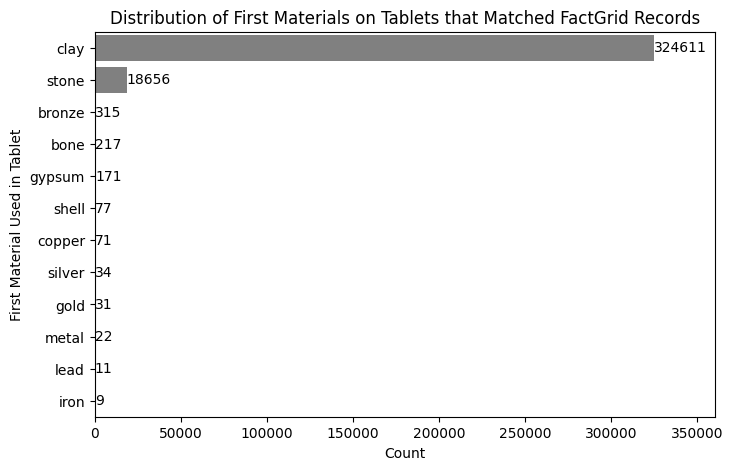

In [50]:
plt.figure(figsize = (8, 5))
ax = sns.barplot(data = first_m_df, y = 'first_material', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 360000))
plt.xlabel('Count')
plt.ylabel('First Material Used in Tablet')
plt.title('Distribution of First Materials on Tablets that Matched FactGrid Records');

##### Distribution of finer categories within matched materials

We have recorded the big material labels for the matched tablets. The graph below summarizes the finer categories within those big labels.

In [51]:
finer_cat_df = pd.DataFrame(matched_mat_df.groupby('first_mat_finer_category')['first_mat_finer_category'].count())
finer_cat_df.index.name = None
finer_cat_df = finer_cat_df.reset_index().rename(
    columns = {'index': 'material',
               'first_mat_finer_category': 'count'}).sort_values(by = 'count', ascending = False)
finer_cat_df['material'] = finer_cat_df['material'].replace([''], 'undetermined')
finer_cat_df

,material,count
0,undetermined,340133
65,limestone,1068
63,lapis lazuli,270
2,alabaster,257
35,diorite,250
...,...,...
78,polypier fossil,1
79,porcelain,1
80,porphyry,1
7,azurite,1


Note that there are unproportionately the most records that have NA value for their material. Since the purpose of this plot is to determine which labels to add into FactGrid, we will exclude the undetermined ones when we plot.

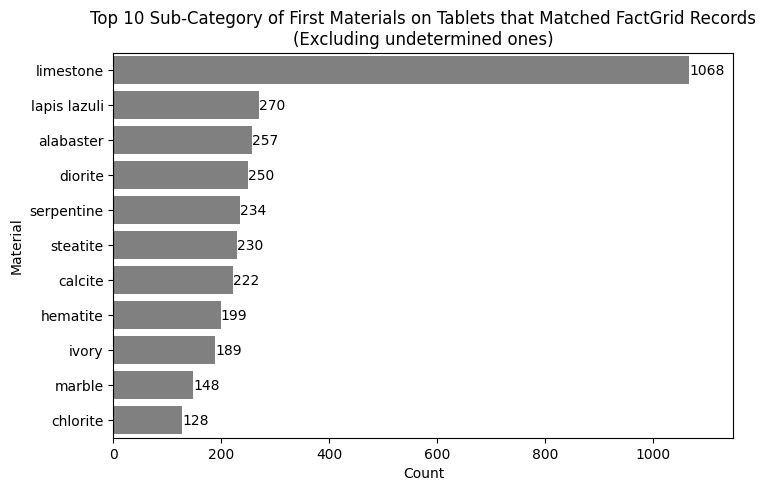

In [52]:
plt.figure(figsize = (8, 5))
ax = sns.barplot(data = finer_cat_df.iloc[1:12,], y = 'material', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 1150))
plt.xlabel('Count')
plt.ylabel('Material')
plt.title('Top 10 Sub-Category of First Materials on Tablets that Matched FactGrid Records\n(Excluding undetermined ones)');

##### Distribution of unmatched materials
Select the top 10 of them.

In [53]:
unmatched_mats = mat_df.iloc[no_match_indices_mat]['cdli_material_dump']
unmatched_mats_clean = []

for m in unmatched_mats:
  m = str(m)
  # we only consider the non-empty ones
  if m != '':
    # remove the unceratinty marks
    m = m.replace(' ?', '')

    # make sure that all multiple entries are separated by ;
    m = m.replace(',', ';')

    # split a multi-language statement, if yes
    lst = m.split('; ')

    unmatched_mats_clean += lst

# remove the space attached to some entries which are resulted from splitting by ;
unmatched_mats_clean = [x.rstrip() for x in unmatched_mats_clean]


pd.unique(pd.Series(unmatched_mats_clean))

array(['nan', 'bitumen', 'glass', 'Glass', 'composite', 'wood', 'shell',
       'ivory', 'blue', '?', 'ston', 'other',
       'stone: red limestone: stone:  lapis lazuli', 'composition',
       'fossilised gastropod', 'faience', 'diorite', 'bronze',
       'chalcedony', 'calcite', 'serpentine', 'quartz', 'marble',
       'terracotta', 'carnelian', 'talc', 'schist', 'sardonyx', 'sard',
       'quartz crystal', 'gold', 'jasper', 'ceramic', 'porphyry',
       'plaster', 'agate', 'onyx', 'obsidian', 'alabaster',
       'lapis lazuli', 'hematite', 'mica', 'frit', 'stone', 'garnet',
       'clay', 'Egyptian blue', 'siderite', 'cuprous sulfide', 'crystal',
       'soapstone', 'chert', 'shale', 'rock crystal', 'tuff', 'steatite',
       'basalt', 'cornelian', 'lak', 'basanite', 'flint', 'metal',
       'ophicalcite'], dtype=object)

In [54]:
# get the frequencies of elements in the list
d_mat = collections.Counter(unmatched_mats_clean)

# turn the langs and their counts into a dataframe
unmatched_mat_counts = pd.DataFrame.from_dict(d_mat, orient = 'index').\
reset_index().\
rename(columns = {'index': 'material', 0: 'count'}).\
sort_values(by = 'count', ascending = False).\
reset_index().\
drop(columns = 'index')

unmatched_mat_counts

,material,count
0,nan,18367
1,composite,3598
2,serpentine,141
3,chalcedony,86
4,hematite,71
...,...,...
58,composition,1
59,stone: red limestone: stone: lapis lazuli,1
60,other,1
61,ston,1


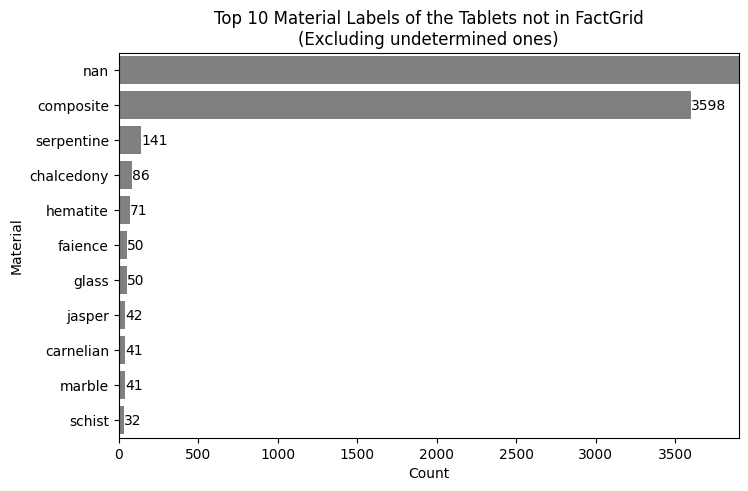

In [55]:
plt.figure(figsize = (8, 5))
ax = sns.barplot(data = unmatched_mat_counts.iloc[0:11,], y = 'material', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 3900))
plt.xlabel('Count')
plt.ylabel('Material')
plt.title('Top 10 Material Labels of the Tablets not in FactGrid\n(Excluding undetermined ones)');

##### What materials are tablets that have languages on them made of?

In [56]:
# slice the matched_mat_df with no_match_indices_lang
lang_mat_matched_df = mat_df[~language_df.index.isin(no_match_indices_lang)]
# count the materials and create a df for the material with corresponding count
lang_mat_matched_counts = pd.DataFrame(lang_mat_matched_df.groupby('first_mat_label')['first_mat_label'].count())
# rename the columns
lang_mat_matched_counts.rename(columns={lang_mat_matched_counts.columns[0]: 'count'}, inplace = True)
lang_mat_matched_counts = lang_mat_matched_counts.reset_index()
# sort the rows by count
lang_mat_matched_counts = lang_mat_matched_counts.sort_values(by = 'count', ascending = False)
lang_mat_matched_counts

,first_mat_label,count
3,clay,239720
12,stone,10375
0,,3473
2,bronze,228
6,gypsum,63
4,copper,41
5,gold,26
11,silver,14
1,bone,12
9,metal,11


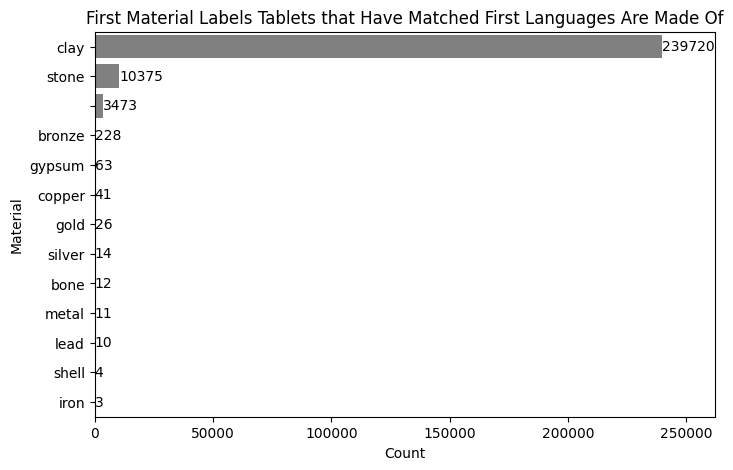

In [57]:
plt.figure(figsize = (8, 5))
ax = sns.barplot(data = lang_mat_matched_counts, y = 'first_mat_label', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 262000))
plt.xlabel('Count')
plt.ylabel('Material')
plt.title('First Material Labels Tablets that Have Matched First Languages Are Made Of');

#### **2.3. ORACC - Make the `material_df` data frame for material_composition for all items with a matching material composition FactGrid Q-id.**

In [58]:
mat_df2 = metacatalogue[['id_text', 'material_y']]
mat2 = mat_df2['material_y']
mat2.unique()

array(['clay', nan, 'stone: limestone', 'metal: bronze', 'stone',
       'stone: granite', 'stone: calcite', 'stone: alabaster',
       'stone: diorite', 'bitumen', 'stone: marble', 'metal',
       'metal: copper', 'stone: dolomite', 'stone: steatite',
       'stone: haematite', 'bone: shell', 'stone: dolerite',
       'stone: slate', 'metal: gold', 'stone: carnelian',
       'clay: terracotta', 'stone: onyx', 'stone: basalt',
       'stone: schist', 'stone: aragonite', 'stone: gypsum',
       'metal: silver', 'stone: hornfels', 'stone: porphyry',
       'stone: lava', 'stone: chlorite', 'stone: lapis lazuli',
       'stone: trachyte', 'stone: sandstone', 'stone: tuff',
       'stone: agate', 'bone: shell; stone: gypsum, lapis lazuli',
       'metal: bronze; stone: steatite', 'stone: obsidian',
       'stone: chalcedony', 'clay; metal: bronze; stone: steatite',
       'clay; metal: bronze; stone', 'stone: chlorite, schist',
       'bone: ivory', 'clay; metal: copper', 'stone: felsite',

But as usual, we need to first clean the material column.

In [59]:
# remove the `\x0b` pattern
mat2 = np.array([re.sub('\x0b', '', str(mat2[i])) for i in range(len(mat2))])
# there are different versions of NA, merge them into one
mat2[mat2 == '-'] = ''
# lowercase all
mat2 = np.char.lower(mat2)

# update the language dataframe
mat_df2['material'] = mat2

# check if the language dataframe has been properly cleaned
mat_df2['material'].unique()
mat_df2.head()

<ipython-input-59-164a5d10a9fc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat_df2['material'] = mat2


,id_text,material_y,material
0,P000001,clay,clay
1,P000002,clay,clay
2,P000003,clay,clay
3,P000004,clay,clay
4,P000005,clay,clay


add in the matched information

In [60]:
first_mat2 = []
first_mat_label2 = []
first_mat_qid2 = []
P155_mat2 = [] # when there's a question mark
other_mat2 = [] # when multiple materials
no_match_indices_mat2 = [] # index of the row if there's no match

FG_existing_materials = short_mat_ref['FactGrid_Label'].tolist()

for index in range(len(mat_df2['material'])):
  m = mat_df2['material'][index]
  # remove the space in every entry and split it by ;
  lst = m.replace(',', ';').split(';')

  # get the first material
  first_m = lst[0]

  # store the remaining materials (if exist) away
  other_mat2 += [', '.join(lst[1:])]

  # check for uncertainty
  if '?' in first_m:
    P155_mat2 += ['Q22757']
    first_m = first_m.replace('?', '')
  else:
    P155_mat2 += ['']

  # store the original first_m for investigating finer categories later
  first_mat2 += [first_m]

  # add in qid and label for the first_m

  # if the material has a QID in FactGrid
  matched = False
  for i in range(len(FG_existing_materials)):
    material = FG_existing_materials[i]
    if material in first_m:
      first_mat_label2 += [material]
      first_mat_qid2 += [short_mat_ref.loc[i, 'FactGrid_Q']]
      matched = True
      break

  # if the material does not have a FactGrid QID, put '' for everything for now
  if matched is False:
    first_mat_label2 += ['']
    first_mat_qid2 += ['']
    no_match_indices_mat2 += [index]

# append these columns to the dataframe
mat_df2['first_mat'] = first_mat2
mat_df2['first_mat_label'] = first_mat_label2
mat_df2['first_mat_qid'] = first_mat_qid2
mat_df2['P155_mat'] = P155_mat2
mat_df2['other_mat'] = other_mat2

# update the names of columns to be clearer
mat_df2 = mat_df2.rename(columns={'material_y': 'oracc_material_dump'})

print("dump refers to an unnecessary column from original data")
mat_df2

dump refers to an unnecessary column from original data


<ipython-input-60-0bdd50b0964a>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat_df2['first_mat'] = first_mat2
<ipython-input-60-0bdd50b0964a>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat_df2['first_mat_label'] = first_mat_label2
<ipython-input-60-0bdd50b0964a>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,id_text,oracc_material_dump,material,first_mat,first_mat_label,first_mat_qid,P155_mat,other_mat
0,P000001,clay,clay,clay,clay,Q471153,,
1,P000002,clay,clay,clay,clay,Q471153,,
2,P000003,clay,clay,clay,clay,Q471153,,
3,P000004,clay,clay,clay,clay,Q471153,,
4,P000005,clay,clay,clay,clay,Q471153,,
...,...,...,...,...,...,...,...,...
366911,X096677,NaN,nan,nan,,,,
366912,X201001,NaN,nan,nan,,,,
366913,X201002,NaN,nan,nan,,,,
366914,X225104,NaN,nan,nan,,,,


##### 2.3.1 matched_mat_df2

In [61]:
matched_mat_df2 = mat_df2[~mat_df2.index.isin(no_match_indices_mat2)].reset_index(drop = True)
matched_mat_df2.head()

,id_text,oracc_material_dump,material,first_mat,first_mat_label,first_mat_qid,P155_mat,other_mat
0,P000001,clay,clay,clay,clay,Q471153,,
1,P000002,clay,clay,clay,clay,Q471153,,
2,P000003,clay,clay,clay,clay,Q471153,,
3,P000004,clay,clay,clay,clay,Q471153,,
4,P000005,clay,clay,clay,clay,Q471153,,


a little sanity check:

In [62]:
matched_mat_df2.shape

(47260, 8)

In [63]:
matched_mat_df2['first_mat_label'].unique()

array(['clay', 'stone', 'bronze', 'metal', 'copper', 'bone', 'gold',
       'gypsum', 'silver', 'lead', 'iron', 'shell'], dtype=object)

finer categories

Now, let's see what finer categories are there under the big labels.

In [64]:
first_mat_finer_category2 = []

for i in range(matched_mat_df2.shape[0]):
  full_mat2 = matched_mat_df2.loc[i, 'first_mat']
  if ': ' in full_mat2:
    finer_mat2 = re.search('(?<=: ).*', string = full_mat2).group(0)
    # remove the parenthesis
    finer_mat2 = finer_mat2.replace('(', '').replace(')', '')
    # remove the space at the end of the string, if any
    finer_mat2 = finer_mat2.strip()
    # check if this is a big label
    if not finer_mat2 in FG_existing_materials:
      first_mat_finer_category2 += [finer_mat2]
    else:
      first_mat_finer_category2 += ['']
  else:
    first_mat_finer_category2 += ['']

matched_mat_df2['first_mat_finer_category'] = first_mat_finer_category2

matched_mat_df2['first_mat_finer_category'].unique()

array(['', 'limestone', 'granite', 'calcite', 'alabaster', 'diorite',
       'marble', 'dolomite', 'steatite', 'haematite', 'dolerite', 'slate',
       'carnelian', 'terracotta', 'onyx', 'basalt', 'schist', 'aragonite',
       'hornfels', 'porphyry', 'lava', 'chlorite', 'lapis lazuli',
       'trachyte', 'sandstone', 'tuff', 'agate', 'obsidian', 'chalcedony',
       'ivory', 'felsite', 'plaster', 'diabase', 'serpentine', 'hematite',
       'feldspar', 'magnetite', 'travertine', 'crystal', 'amethyst',
       'electrum', 'banded-agate', 'agate or onyx', 'stalagmite',
       'magnesite', 'cornelian', 'porcelain', 'bronze or copper',
       'turquoise', 'breccia', 'jadeite', 'greenstone',
       'steatite  or diorite', 'mother of pearl', 'copper or bronze',
       'syenite', 'steatite or basalt', 'pumice', 'calcite or aragonite',
       'granite or diorite', 'gmarble', 'calcite stalagmite',
       'greenstone schist', 'marbe', 'alabaster or paragonite',
       'diorite or gabbro', 'uralite

##### 2.3.2 no_match_mat_df2

Make a separate dataframe of the items not matched for export and supervision: `no_material_df`.

In [65]:
no_match_mat_df2 = metacatalogue.iloc[no_match_indices_mat2]
no_match_mat_df2.head()

,composite_id_x,id_text2,id_text,language_x,object_type_x,period_x,material_x,collection_x,museum_no_x,provenience_x,excavation_no_x,findspot_square_x,date_of_origin_x,dates_referenced_x,genre_x,subgenre_x,translation_source_x,id,language_y,material_y,object_type_y,period_y,provenience_y,excavation_no_y,findspot_square_y,dates_referenced_y,genre_y,subgenre_y,translation_source_y,archive,collection_y,museum-nos,mus_no,museum_no_y,cdli_museum_no,saa_cdli_museum,Mus_no,museum_number,museum,museum_URL,date_of_origin_y,dialect,date,supergenre,xproject,q_number,ancient_year,date_bce,cdli_id,OBJ_type,Period_culture,Script_type_1,Genre,Subgenre,S_s_genre,Language,Full_no,Tablet_number,Q_no,object,composite_id_y,project name,id_text_int,seal_id,cdli_composite_id,ancient_date,bdtns_id
669,NaN,0.0,P000730,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15316,Uruk (mod. Warka),"W 01872,1","Od XV,5",NaN,NaN,Administrative,NaN,no translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
670,NaN,0.0,P000731,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15315,Uruk (mod. Warka),"W 01872,2","Od XV,5",NaN,NaN,Administrative,NaN,no translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
671,NaN,0.0,P000732,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15345,Uruk (mod. Warka),W 02134,?,NaN,NaN,Administrative,NaN,no translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
672,NaN,0.0,P000733,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15289,Uruk (mod. Warka),W 02352,"Oc XV,5",NaN,NaN,Administrative,NaN,no translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
673,NaN,0.0,P000734,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15245,Uruk (mod. Warka),"W 05233,a","Pd XVI,4",NaN,NaN,Administrative,NaN,no translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
no_match_mat_df2.shape

(319656, 67)

In [67]:
matched_mat_df2.shape[0] + no_match_mat_df2.shape[0] == metacatalogue.shape[0]

True

#####2.3.3 Visualization of ORACC Materials

##### Distribution of matched first materials

In [68]:
first_m_df2 = pd.DataFrame(matched_mat_df2.groupby('first_mat_label')['first_mat_label'].count())
first_m_df2.index.name = None
first_m_df2 = first_m_df2.reset_index().rename(
    columns = {'index': 'first_material',
               'first_mat_label': 'count'}).sort_values(by = 'count', ascending = False)
first_m_df2

,first_material,count
2,clay,40954
11,stone,5591
1,bronze,422
8,metal,95
5,gypsum,63
3,copper,61
4,gold,33
10,silver,16
0,bone,10
7,lead,10


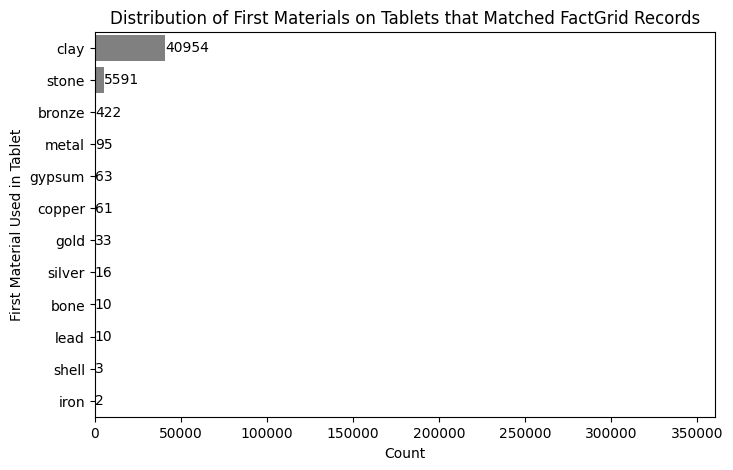

In [69]:
plt.figure(figsize = (8, 5))
ax = sns.barplot(data = first_m_df2, y = 'first_material', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 360000))
plt.xlabel('Count')
plt.ylabel('First Material Used in Tablet')
plt.title('Distribution of First Materials on Tablets that Matched FactGrid Records');

##### Distribution of finer categories within matched materials

We have recorded the big material labels for the matched tablets. The graph below summarizes the finer categories within those big labels.

In [70]:
finer_cat_df2 = pd.DataFrame(matched_mat_df2.groupby('first_mat_finer_category')['first_mat_finer_category'].count())
finer_cat_df2.index.name = None
finer_cat_df2 = finer_cat_df2.reset_index().rename(
    columns = {'index': 'material',
               'first_mat_finer_category': 'count'}).sort_values(by = 'count', ascending = False)
finer_cat_df2['material'] = finer_cat_df2['material'].replace([''], 'undetermined')
finer_cat_df2

,material,count
0,undetermined,45187
46,limestone,945
4,alabaster,249
25,diorite,166
14,calcite,143
...,...,...
22,cornelian,1
21,copper or bronze,1
55,porcelain,1
18,chalcedon,1


Note that there are unproportionately the most records that have NA value for their material. Since the purpose of this plot is to determine which labels to add into FactGrid, we will exclude the undetermined ones when we plot.

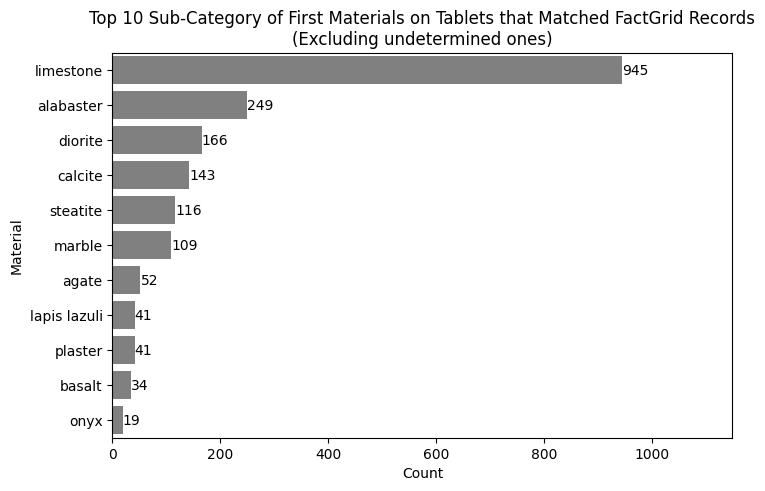

In [71]:
plt.figure(figsize = (8, 5))
ax = sns.barplot(data = finer_cat_df2.iloc[1:12,], y = 'material', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 1150))
plt.xlabel('Count')
plt.ylabel('Material')
plt.title('Top 10 Sub-Category of First Materials on Tablets that Matched FactGrid Records\n(Excluding undetermined ones)');

##### Distribution of unmatched materials
Select the top 10 of them.

In [72]:
unmatched_mats2 = mat_df2.iloc[no_match_indices_mat2]['oracc_material_dump']
unmatched_mats_clean2 = []

nancount = 0

for m in unmatched_mats2:
  m = str(m)
  # we only consider the non-empty ones
  if m == 'nan':
    nancount += 1
  elif m != '':
    # remove the unceratinty marks
    m = m.replace(' ?', '')

    # make sure that all multiple entries are separated by ;
    m = m.replace(',', ';')

    # split a multi-language statement, if yes
    lst = m.split('; ')

    unmatched_mats_clean2 += lst

# remove the space attached to some entries which are resulted from splitting by ;
unmatched_mats_clean2 = [x.rstrip() for x in unmatched_mats_clean2]

print('There are ' + str(nancount) + ' nans in the ORACC materials')
pd.unique(pd.Series(unmatched_mats_clean2))

There are 319626 nans in the ORACC materials


array(['bitumen', 'glass', 'composite', 'bituminous substance', 'ivory',
       'unknown', 'stone: alabaster', 'calcite',
       'yellow calcite (or alabaster)', 'rock'], dtype=object)

In [73]:
# get the frequencies of elements in the list
d_mat2 = collections.Counter(unmatched_mats_clean2)

# turn the langs and their counts into a dataframe
unmatched_mat_counts2 = pd.DataFrame.from_dict(d_mat2, orient = 'index').\
reset_index().\
rename(columns = {'index': 'material', 0: 'count'}).\
sort_values(by = 'count', ascending = False).\
reset_index().\
drop(columns = 'index')

print('There are ' + str(nancount) + ' nans in the ORACC materials')
unmatched_mat_counts2

There are 319626 nans in the ORACC materials


,material,count
0,bitumen,10
1,unknown,8
2,glass,5
3,ivory,3
4,composite,2
5,bituminous substance,1
6,stone: alabaster,1
7,calcite,1
8,yellow calcite (or alabaster),1
9,rock,1


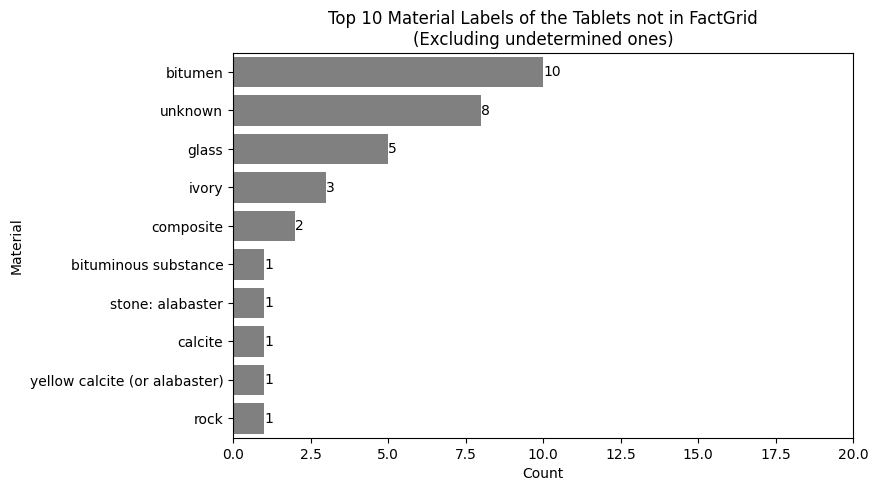

In [74]:
plt.figure(figsize = (8, 5))
ax = sns.barplot(data = unmatched_mat_counts2.iloc[0:11,], y = 'material', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 20))
plt.xlabel('Count')
plt.ylabel('Material')
plt.title('Top 10 Material Labels of the Tablets not in FactGrid\n(Excluding undetermined ones)');

In [75]:
print(matched_mat_df.shape)
matched_mat_df.head()

(344225, 9)


,id_text,cdli_material_dump,material,first_mat,first_mat_label,first_mat_qid,P155_mat,other_mat,first_mat_finer_category
0,P000001,clay,clay,clay,clay,Q471153,,,
1,P000002,clay,clay,clay,clay,Q471153,,,
2,P000003,clay,clay,clay,clay,Q471153,,,
3,P000004,clay,clay,clay,clay,Q471153,,,
4,P000005,clay,clay,clay,clay,Q471153,,,


In [76]:
print(matched_mat_df2.shape)
matched_mat_df2.head()

(47260, 9)


,id_text,oracc_material_dump,material,first_mat,first_mat_label,first_mat_qid,P155_mat,other_mat,first_mat_finer_category
0,P000001,clay,clay,clay,clay,Q471153,,,
1,P000002,clay,clay,clay,clay,Q471153,,,
2,P000003,clay,clay,clay,clay,Q471153,,,
3,P000004,clay,clay,clay,clay,Q471153,,,
4,P000005,clay,clay,clay,clay,Q471153,,,


#### **2.4 Combining CDLI and ORACC Material dataframes**

In [77]:
materials_df = pd.merge(mat_df, mat_df2, on="id_text", how = 'outer')
final_materials_df = materials_df[['id_text','material_x', 'material_y',
                             'first_mat_x','first_mat_y', 'first_mat_label_x','first_mat_label_y',
                             'first_mat_qid_x','first_mat_qid_y','P155_mat_x','P155_mat_y',
                             'other_mat_x','other_mat_y']]
final_materials_df

,id_text,material_x,material_y,first_mat_x,first_mat_y,first_mat_label_x,first_mat_label_y,first_mat_qid_x,first_mat_qid_y,P155_mat_x,P155_mat_y,other_mat_x,other_mat_y
0,P000001,clay,clay,clay,clay,clay,clay,Q471153,Q471153,,,,
1,P000002,clay,clay,clay,clay,clay,clay,Q471153,Q471153,,,,
2,P000003,clay,clay,clay,clay,clay,clay,Q471153,Q471153,,,,
3,P000004,clay,clay,clay,clay,clay,clay,Q471153,Q471153,,,,
4,P000005,clay,clay,clay,clay,clay,clay,Q471153,Q471153,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
366911,X096677,nan,nan,nan,nan,,,,,,,,
366912,X201001,nan,nan,nan,nan,,,,,,,,
366913,X201002,nan,nan,nan,nan,,,,,,,,
366914,X225104,nan,nan,nan,nan,,,,,,,,


## 3 __museum/collection = present holding [(P329)](https://database.factgrid.de/wiki/Property:P329)__

####3.1 CDLI collection

Next we list all the unique statements in the 'collection' field in a data frame, `museum_df` and match them with the FactGrid Q-ids.

We can use this dataset, which has the corresponding FactGrid Q-ids for some, but perhaps not all (after we see how many FG items are needed to match, Adam will finish making the necessary Q-ids in FactGrid): https://docs.google.com/spreadsheets/d/1BdRndVP3JFGWAtv1WTlXiYsGBuCADHnblYeoihfQcLI/edit?usp=sharing

In [78]:
collection_url = 'https://github.com/ancient-world-citation-analysis/CDLI2LoD/blob/main/data/Museum%20-%20LOD%20Tablet%20Dictionary%20(FG%20Cuneiform).csv?raw=true'

collection_reference = pd.read_csv(collection_url, sep = ',')
# only use a certain collection of columns
collection_reference = collection_reference[['collection', 'factgrid_id', 'wikidata_id', 'collection_name', 'collection_name_native', 'collection_url',
                                     'wiki_url_eng', 'wiki_url_native']]
# fill na values with space
collection_reference = collection_reference.fillna('')
# remove entries without a FactGrid QID
collection_reference = collection_reference[collection_reference['factgrid_id'] != ''].reset_index(drop = True)
# drop duplicated rows
collection_reference = collection_reference.drop_duplicates(keep = 'first')

collection_reference

,collection,factgrid_id,wikidata_id,collection_name,collection_name_native,collection_url,wiki_url_eng,wiki_url_native
0,"Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...
1,"Louvre Museum, Paris, France",Q511925,Q19675,Louvre,Louvre,https://www.louvre.fr,https://en.wikipedia.org/wiki/Louvre,https://ar.wikipedia.org/wiki/متحف_اللوفر
2,"British Museum, London, UK",Q102010,Q6373,British Museum,British Museum,https://www.britishmuseum.org,https://en.wikipedia.org/wiki/British_Museum,https://en.wikipedia.org/wiki/British_Museum
3,"Ashmolean Museum, Oxford, UK",Q511934,Q636400,Ashmolean Museum,Ashmolean Museum,https://www.ashmolean.org,https://en.wikipedia.org/wiki/Ashmolean_Museum,https://en.wikipedia.org/wiki/Ashmolean_Museum
4,"Metropolitan Museum of Art, New York, New York...",Q512004,Q160236,Metropolitan Museum of Art,Metropolitan Museum of Art,https://www.metmuseum.org,https://en.wikipedia.org/wiki/Metropolitan_Mus...,https://en.wikipedia.org/wiki/Metropolitan_Mus...
...,...,...,...,...,...,...,...,...
69,"Rubenstein Rare Book & Manuscript Library, Duk...",Q511884,Q74061200,David M. Rubenstein Rare Book & Manuscript Lib...,David M. Rubenstein Rare Book & Manuscript Lib...,https://library.duke.edu/rubenstein/about/library,https://en.wikipedia.org/wiki/Duke_University_...,https://en.wikipedia.org/wiki/Duke_University_...
70,"Università Cattolica del S. Cuore, Milan, Italy",Q511917,Q229022,Università Cattolica del Sacro Cuore,Università Cattolica del Sacro Cuore,https://www.unicatt.it,https://en.wikipedia.org/wiki/Università_Catto...,https://it.wikipedia.org/wiki/Università_Catto...
71,"University of Liège, Liège, Belgium",Q173222,Q1334582,University of Liège,Université de Liège,https://www.uliege.be,https://en.wikipedia.org/wiki/University_of_Liège,https://fr.wikipedia.org/wiki/Université_de_Liège
72,Oriental Institute Museum,Q511904,Q1276053,Oriental Institute Museum,Oriental Institute Museum,https://oi.uchicago.edu/museum-exhibits,https://en.wikipedia.org/wiki/Oriental_Institu...,https://en.wikipedia.org/wiki/Oriental_Institu...


##### 3.1.2 collection_df

Match on cdli label to obtain the corresponding FactGrid Q-id for 'collection' field and add matching data to `museum_df`.


From the cdil_cat.csv include a column / field for the corresponding __'museum_no' = 'inventory position' [(P10)](https://database.factgrid.de/wiki/Property:P10)__.

Format of the result: [Example](https://cdli.mpiwg-berlin.mpg.de/search?simple-value%5B%5D=P215773&simple-field%5B%5D=keyword)

| id_text | collection | museum_no | factgrid_id | wikidata_id | P155 |
| ------- | ---------- | --------- | ----------- | ----------- | ---- |
| P215773 |Eski Şark Eserleri Müzesi, Arkeoloji Müzeleri, Istanbul, Turkey |Ist EŞEM 00501 |Q511898 | Q636978 | |

  * If there are any question marks, we can use the P155 field and fill the cell with [Q22757](https://database.factgrid.de/wiki/Item:Q22757)
  * There are of course more fields in the dataset linked above which we will want to get once the matching stage is finalized (i.e. those fields highlighted in green)

In [79]:
collection_df = metacatalogue[['id_text', 'collection_x']]
collection_df = collection_df.rename(columns = {'collection_x': 'cdli_dump_collection'})
collection_df['cdli_dump_collection'].unique()

array(['Vorderasiatisches Museum, Berlin, Germany',
       'National Museum of Iraq, Baghdad, Iraq',
       'National Museum of Iraq, Baghdad, Iraq; Vorderasiatisches Museum, Berlin, Germany',
       ..., 'Mardin Museum, Mardin, Turkey', 'Oylum Höyük, Oylum, Turkey',
       'private: William T. Grant Jr., Pelham Manor, New York, USA'],
      dtype=object)

In [80]:
collection = []
collection_qid = []
collection_wikidata_id = []
collection_name = []
collection_name_native = []
collection_url = []
wiki_url_eng = []
wiki_url_native = []
P155_collection = [] # when there's a question mark
other_collection = [] # when there are multiple collections
no_match_indices_collection = [] # index of the row if there's no match


for index in range(len(collection_df['cdli_dump_collection'])):
  c = collection_df['cdli_dump_collection'][index]
  # split every entry by ;
  lst = str(c).split(';')

  # get the first collection
  first_c = lst[0].rstrip()

  # store the remaining ecollections (if exist) away
  other_collection += [', '.join(lst[1:])]

  # check for uncertainty
  if '?' in first_c:
    P155_collection += ['Q22757']
    first_c = first_c.replace('?', '').rstrip()
  else:
    P155_collection += ['']


  # add in qid and labels for the first_c

  # if the collection has a QID in FactGrid
  if first_c in collection_reference['collection'].unique():
    # record the period
    collection += [first_c]
    # get the corresponding QID (FG_item) and Wikidata_URI
    i = collection_reference['collection'].tolist().index(first_c)
    collection_qid += [collection_reference['factgrid_id'][i]]
    collection_wikidata_id += [collection_reference['wikidata_id'][i]]
    collection_name += [collection_reference['collection_name'][i]]
    collection_name_native += [collection_reference['collection_name_native'][i]]
    collection_url += [collection_reference['collection_url'][i]]
    wiki_url_eng += [collection_reference['wiki_url_eng'][i]]
    wiki_url_native += [collection_reference['wiki_url_native'][i]]

  # if the period does not have a FactGrid QID, put '' for everything for now
  else:
    collection += ['']
    collection_qid += ['']
    collection_wikidata_id += ['']
    collection_name += ['']
    collection_name_native += ['']
    collection_url += ['']
    wiki_url_eng += ['']
    wiki_url_native += ['']
    no_match_indices_collection += [index]


# append these columns to the dataframe
collection_df['collection'] = collection
collection_df['collection_qid'] = collection_qid
collection_df['collection_wikidata_id'] = collection_wikidata_id
collection_df['collection_name'] = collection_name
collection_df['collection_name_native'] = collection_name_native
collection_df['collection_url'] = collection_url
collection_df['wiki_url_eng'] = wiki_url_eng
collection_df['wiki_url_native'] = wiki_url_native
collection_df['P155_collection'] = P155_collection
collection_df['other_collection'] = other_collection

collection_df

,id_text,cdli_dump_collection,collection,collection_qid,collection_wikidata_id,collection_name,collection_name_native,collection_url,wiki_url_eng,wiki_url_native,P155_collection,other_collection
0,P000001,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
1,P000002,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
2,P000003,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
3,P000004,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
4,P000005,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
...,...,...,...,...,...,...,...,...,...,...,...,...
366911,X096677,NaN,,,,,,,,,,
366912,X201001,NaN,,,,,,,,,,
366913,X201002,NaN,,,,,,,,,,
366914,X225104,NaN,,,,,,,,,,


##### 3.1.3 matched_collection_df

In [81]:
matched_collection_df = collection_df[~collection_df.index.isin(no_match_indices_collection)].reset_index(drop = True)
matched_collection_df = matched_collection_df.rename(columns={'id_text': 'cdli_dump_id'})
matched_collection_df

,cdli_dump_id,cdli_dump_collection,collection,collection_qid,collection_wikidata_id,collection_name,collection_name_native,collection_url,wiki_url_eng,wiki_url_native,P155_collection,other_collection
0,P000001,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
1,P000002,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
2,P000003,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
3,P000004,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
4,P000005,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
...,...,...,...,...,...,...,...,...,...,...,...,...
237386,P532441,"National Museum of Syria, Damascus, Syria ?","National Museum of Syria, Damascus, Syria",Q511875,Q617254,Damascus National Museum,المتحف الوطني دمشق,http://dgam.gov.sy/المتاحف-الوطنية/المتحف-الوطني/,https://en.wikipedia.org/wiki/National_Museum_...,https://ar.wikipedia.org/wiki/المتحف_الوطني_بدمشق,Q22757,
237387,P532442,"National Museum of Iraq, Baghdad, Iraq","National Museum of Iraq, Baghdad, Iraq",Q511874,Q521251,Iraq Museum,المتحف العراقي,https://www.theiraqmuseum.com/index.html,https://en.wikipedia.org/wiki/Iraq_Museum,https://ar.wikipedia.org/wiki/المتحف_العراقي,,
237388,P532443,"National Museum of Iraq, Baghdad, Iraq","National Museum of Iraq, Baghdad, Iraq",Q511874,Q521251,Iraq Museum,المتحف العراقي,https://www.theiraqmuseum.com/index.html,https://en.wikipedia.org/wiki/Iraq_Museum,https://ar.wikipedia.org/wiki/المتحف_العراقي,,
237389,P532444,"National Museum of Iraq, Baghdad, Iraq","National Museum of Iraq, Baghdad, Iraq",Q511874,Q521251,Iraq Museum,المتحف العراقي,https://www.theiraqmuseum.com/index.html,https://en.wikipedia.org/wiki/Iraq_Museum,https://ar.wikipedia.org/wiki/المتحف_العراقي,,


In [82]:
matched_collection_df.shape

(237391, 12)

##### 3.1.4 no_match_collection_df

Make a separate data frame for the texts when there is no match / museum / collection: `no_collection_df`.

In [83]:
no_match_collection_df = metacatalogue.iloc[no_match_indices_collection]
no_match_collection_df.head()

,composite_id_x,id_text2,id_text,language_x,object_type_x,period_x,material_x,collection_x,museum_no_x,provenience_x,excavation_no_x,findspot_square_x,date_of_origin_x,dates_referenced_x,genre_x,subgenre_x,translation_source_x,id,language_y,material_y,object_type_y,period_y,provenience_y,excavation_no_y,findspot_square_y,dates_referenced_y,genre_y,subgenre_y,translation_source_y,archive,collection_y,museum-nos,mus_no,museum_no_y,cdli_museum_no,saa_cdli_museum,Mus_no,museum_number,museum,museum_URL,date_of_origin_y,dialect,date,supergenre,xproject,q_number,ancient_year,date_bce,cdli_id,OBJ_type,Period_culture,Script_type_1,Genre,Subgenre,S_s_genre,Language,Full_no,Tablet_number,Q_no,object,composite_id_y,project name,id_text_int,seal_id,cdli_composite_id,ancient_date,bdtns_id
148,Q000002,0.0,P000166,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"German Archaeological Institute, Berlin, Germa...","HD: W 19412,8",Uruk (mod. Warka),"W 19412,08","Nb XVI,3/4",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation,NaN,undetermined,clay,tablet,Uruk III,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"German Archaeological Institute, Berlin, Germa...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
152,Q000026,0.0,P000171,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"German Archaeological Institute, Berlin, Germa...","HD: W 19667,e",Uruk (mod. Warka),"W 19667,e","Nc XVI,5",00.00.00.00,00.00.00.00,Lexical,Archaic Metal (witness),no translation,NaN,undetermined,clay,tablet,Uruk III,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"German Archaeological Institute, Berlin, Germa...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
154,Q000023,0.0,P000173,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"German Archaeological Institute, Berlin, Germa...",HD: W 19724,Uruk (mod. Warka),W 19724,"Nb XVI,3",00.00.00.00,00.00.00.00,Lexical,Archaic Vessels and Garments (witness),no translation,NaN,undetermined,clay,tablet,Uruk III,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"German Archaeological Institute, Berlin, Germa...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
155,Q000002,0.0,P000174,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"German Archaeological Institute, Berlin, Germa...","HD: W 19726,b",Uruk (mod. Warka),"W 19726,b","Na XVI,3",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation,NaN,undetermined,clay,tablet,Uruk III,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"German Archaeological Institute, Berlin, Germa...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
156,Q000013,0.0,P000175,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"German Archaeological Institute, Berlin, Germa...","HD: W 19726,c",Uruk (mod. Warka),"W 19726,c","Na XVI,3",NaN,NaN,Lexical,Archaic Fish (witness),no translation,NaN,undetermined,clay,tablet,Uruk III,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"German Archaeological Institute, Berlin, Germa...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,S013836,NaN,NaN,NaN


In [84]:
no_match_collection_df.shape

(129525, 67)

In [85]:
matched_collection_df.shape[0] + no_match_collection_df.shape[0] == metacatalogue.shape[0]

True

##### 3.1.5 Visualization

###### Distribution of matched first collections

In [86]:
first_c_df = pd.DataFrame(matched_collection_df.groupby('collection')['collection'].count())
first_c_df.index.name = None
first_c_df = first_c_df.reset_index().rename(
    columns = {'index': 'first_collection',
               'collection': 'count'}).sort_values(by = 'count', ascending = False)
first_c_df = first_c_df.reset_index(drop = True)
first_c_df

,first_collection,count
0,"British Museum, London, UK",74943
1,University of Pennsylvania Museum of Archaeolo...,26377
2,"Arkeoloji Müzeleri, Istanbul, Turkey",19207
3,"National Museum of Iraq, Baghdad, Iraq",19072
4,"Yale Babylonian Collection, New Haven, Connect...",15823
...,...,...
57,"Rubenstein Rare Book & Manuscript Library, Duk...",9
58,"Museum and Art Gallery, Bristol, UK",9
59,"Boston Public Library, Boston, Massachusetts, USA",8
60,"Museon, The Hague, Holland",7


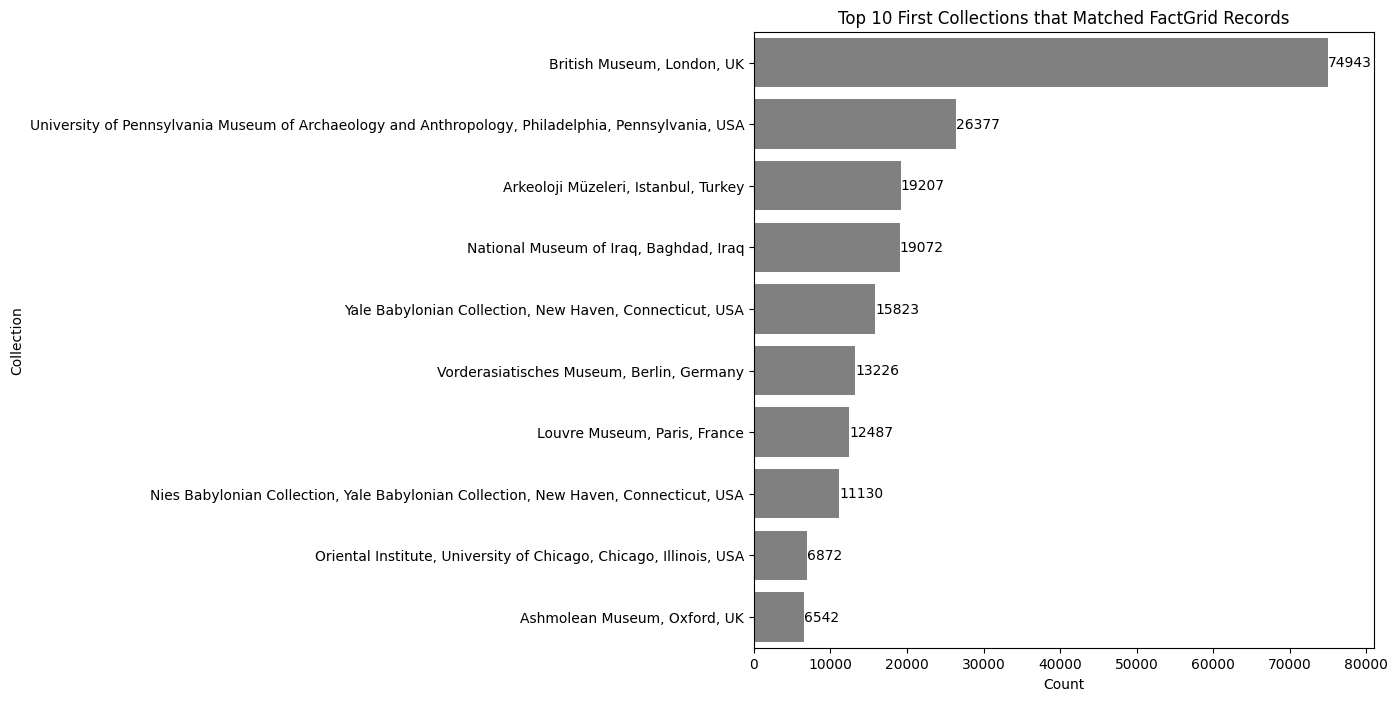

In [87]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(data = first_c_df[0:10], y = 'first_collection', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 81000))
plt.xlabel('Count')
plt.ylabel('Collection')
plt.title('Top 10 First Collections that Matched FactGrid Records');

###### Distribution of countries

of first collections that matched

In [88]:
collection_country = []

for j in range(first_c_df.shape[0]):
  current_country = first_c_df.loc[j, 'first_collection'].split(',')[-1].replace(' ', '')
  collection_country += [current_country]

first_c_df['collection_country'] = collection_country

first_c_df

,first_collection,count,collection_country
0,"British Museum, London, UK",74943,UK
1,University of Pennsylvania Museum of Archaeolo...,26377,USA
2,"Arkeoloji Müzeleri, Istanbul, Turkey",19207,Turkey
3,"National Museum of Iraq, Baghdad, Iraq",19072,Iraq
4,"Yale Babylonian Collection, New Haven, Connect...",15823,USA
...,...,...,...
57,"Rubenstein Rare Book & Manuscript Library, Duk...",9,USA
58,"Museum and Art Gallery, Bristol, UK",9,UK
59,"Boston Public Library, Boston, Massachusetts, USA",8,USA
60,"Museon, The Hague, Holland",7,Holland


In [89]:
first_c_country_count = first_c_df.groupby(['collection_country'])['collection_country', 'count'].agg(sum)\
.reset_index()\
.sort_values(by = 'count', ascending = False)\
.reset_index(drop = True)

first_c_country_count

<ipython-input-89-a59efc2431c5>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  first_c_country_count = first_c_df.groupby(['collection_country'])['collection_country', 'count'].agg(sum)\
<ipython-input-89-a59efc2431c5>:1: FutureWarning: The operation <built-in function sum> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  first_c_country_count = first_c_df.groupby(['collection_country'])['collection_country', 'count'].agg(sum)\


,collection_country,count
0,UK,83258
1,USA,73783
2,Turkey,20558
3,Iraq,19072
4,Germany,15023
5,France,12973
6,Syria,5106
7,RussianFederation,2187
8,Canada,1367
9,Italy,1366


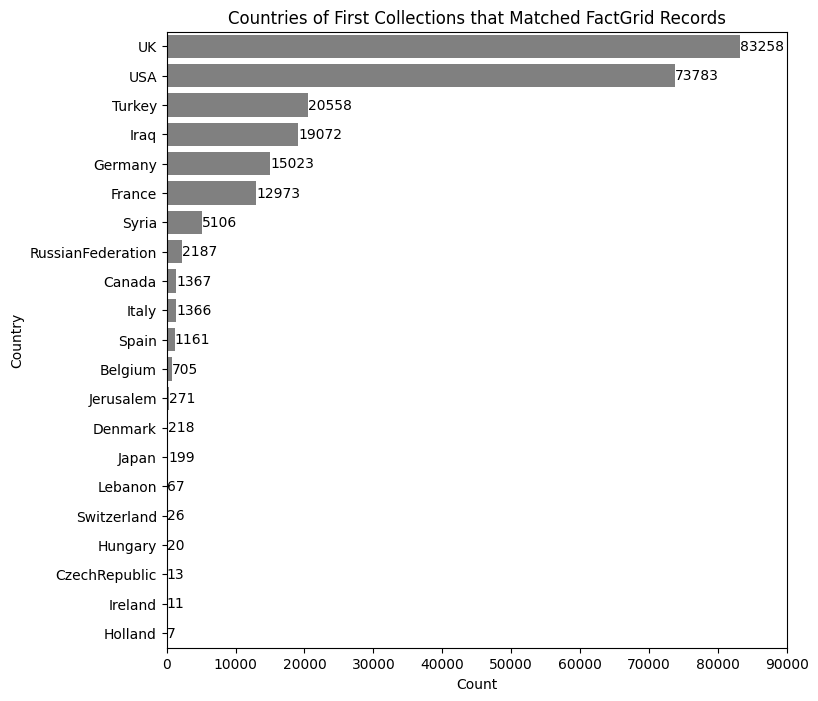

In [90]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(data = first_c_country_count, y = 'collection_country', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 90000))
plt.xlabel('Count')
plt.ylabel('Country')
plt.title('Countries of First Collections that Matched FactGrid Records');

###### Distribution of unmatched collections

In [91]:
collection_df.iloc[no_match_indices_collection].groupby('cdli_dump_collection')['cdli_dump_collection'].count()

cdli_dump_collection
 Institute of Archaeology, University of Turin, Turin, Italy                               1
A'ali, Bahrain                                                                             7
A. M. Chisholm Museum, Duluth, Minnesota, USA                                              1
A. V. Lane Museum, Bridwell Library, Southern Methodist University, Dallas, Texas, USA    11
Abbaye de Maredsous, Denée, Belgium                                                        1
                                                                                          ..
Übersee-Museum, Bremen, Germany                                                            2
Übersee-Museum, Bremen, Germany; École Pratique des Hautes Études, Paris, France           1
Şanlıurfa Archaeological Museum, Şanlıurfa, Turkey                                         2
Şanlıurfa Arkeoloji Müzesi, Şanlıurfa, Turkey                                              1
Šiauliai Aušros Museum, Šiauliai, Lithuania      

In [92]:
unmatched_collections = collection_df.iloc[no_match_indices_collection]['cdli_dump_collection']
unmatched_collections_clean = []

for c in unmatched_collections:
  # we only consider the non-empty ones
  if (c != '') & (c != '-'):
    # remove the unceratinty marks
    c = str(c).replace('?', '').rstrip()

    # split a multi statement, if yes
    lst = str(c).split('; ')

    unmatched_collections_clean += lst

# remove the space attached to some entries which are resulted from splitting by ;
unmatched_collections_clean = [x.rstrip() for x in unmatched_collections_clean]


pd.unique(pd.Series(unmatched_collections_clean))

array(['German Archaeological Institute, Berlin, Germany (on loan, University of Heidelberg)',
       'unlocated',
       'Royal Ontario Museum of Archaeology, Toronto, Ontario, Canada (cast)',
       ..., 'Mardin Museum, Mardin, Turkey', 'Oylum Höyük, Oylum, Turkey',
       'private: William T. Grant Jr., Pelham Manor, New York, USA'],
      dtype=object)

In [93]:
# get the frequencies of elements in the list
d = collections.Counter(unmatched_collections_clean)

# turn the langs and their counts into a dataframe
unmatched_c_df = pd.DataFrame.from_dict(d, orient = 'index').\
reset_index().\
rename(columns = {'index': 'collection', 0: 'count'}).\
sort_values(by = 'count', ascending = False).\
reset_index(drop = True)

unmatched_c_df

,collection,count
0,nan,26060
1,"Anadolu Medeniyetleri Müzesi, Ankara, Turkey",15950
2,"Department of Near Eastern Studies, Cornell Un...",10445
3,"National Museum of Syria, Der-ez-Zor, Syria",9506
4,"National Museum of Syria, Idlib, Syria",6852
...,...,...
1382,"Palace Museum, Beijing, PRC",1
1383,Meissner Collection,1
1384,"West Point Museum, West Point, New York USA",1
1385,"Garrett-Evangelical Theological Seminary, Evan...",1


In [94]:
unmatched_c_df.to_csv(folder + 'ORACC_DFS/unmatched_cdli_collections_df.csv')

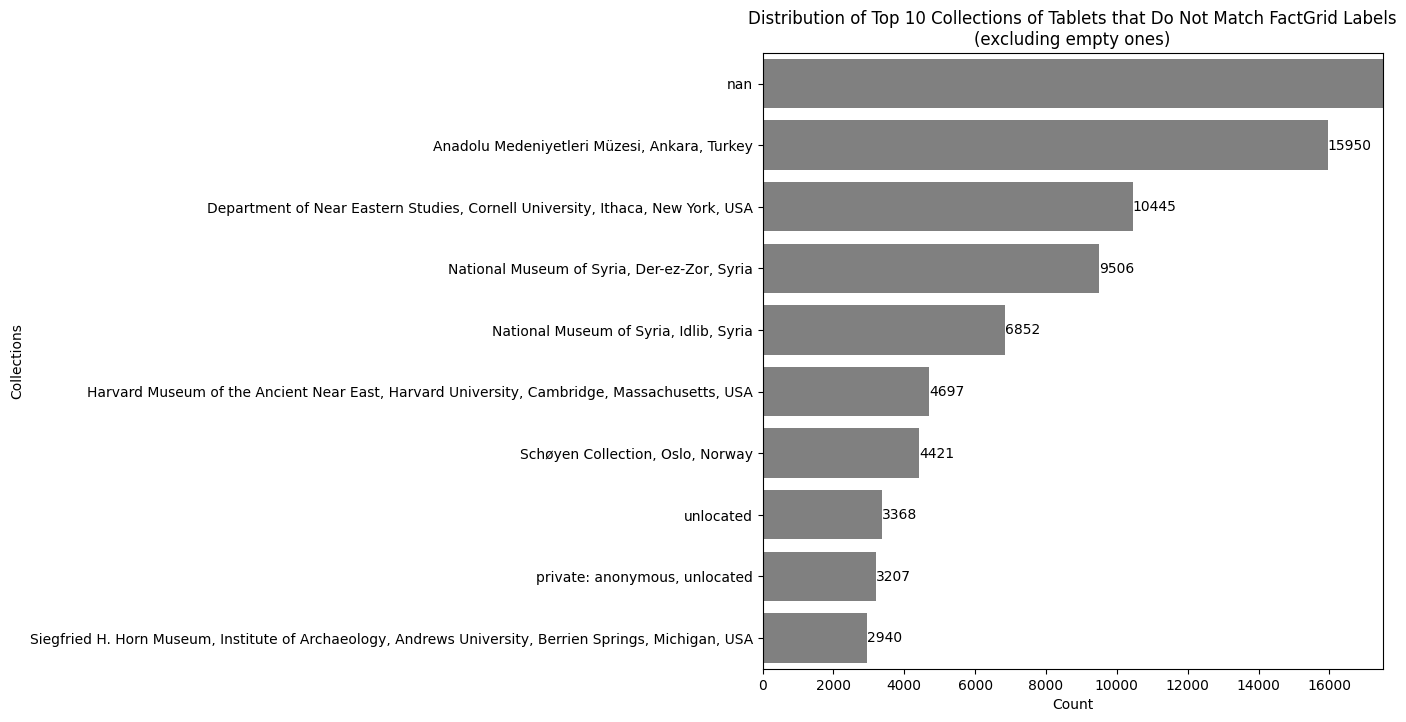

In [95]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(data = unmatched_c_df[0:10], y = 'collection', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 17500))
plt.xlabel('Count')
plt.ylabel('Collections')
plt.title('Distribution of Top 10 Collections of Tablets that Do Not Match FactGrid Labels\n(excluding empty ones)');

####3.2 ORACC collection
Repeating the process on the CDLI collection above for ORACC.

##### 3.2.1 collection_df2
Match on oracc label to obtain the corresponding FactGrid Q-id for 'collection' field and add matching data to `museum_df`.

In [96]:
collection_df2 = metacatalogue[['id_text', 'collection_y']]
collection_df2 = collection_df2.rename(columns = {'collection_y': 'oracc_dump_collection'})
collection_df2['oracc_dump_collection'].unique()

array(['Vorderasiatisches Museum, Berlin, Germany',
       'National Museum of Iraq, Baghdad, Iraq',
       'National Museum of Iraq, Baghdad, Iraq; Vorderasiatisches Museum, Berlin, Germany',
       'German Archaeological Institute, Berlin, Germany (on loan, University of Heidelberg)',
       'Ashmolean Museum, Oxford, UK', 'British Museum, London, UK',
       'University of Pennsylvania Museum of Archaeology and Anthropology, Philadelphia, Pennsylvania, USA',
       'unlocated', nan, 'private: anonymous, unlocated',
       'Arkeoloji Müzeleri, Istanbul, Turkey',
       'Musées royaux d’Art et d’Histoire, Brussels, Belgium',
       'private: Michail, Louise, Milan, Italy',
       'Arkeoloji Müzeleri, Istanbul, Turkey; Vorderasiatisches Museum, Berlin, Germany',
       'Mead Art Gallery, Amherst College, Amherst, Massacusetts, USA',
       'Nies Babylonian Collection, Yale Babylonian Collection, New Haven, Connecticut, USA',
       'Bible Lands Museum, Pittsburgh Theological Seminary, 

In [97]:
collection2 = []
collection_qid2 = []
collection_wikidata_id2 = []
collection_name2 = []
collection_name_native2 = []
collection_url2 = []
wiki_url_eng2 = []
wiki_url_native2 = []
P155_collection2 = [] # when there's a question mark
other_collection2 = [] # when there are multiple collections
no_match_indices_collection2 = [] # index of the row if there's no match


for index in range(len(collection_df2['oracc_dump_collection'])):
  c = collection_df2['oracc_dump_collection'][index]
  # split every entry by ;
  lst = str(c).split(';')

  # get the first collection
  first_c = lst[0].rstrip()

  # store the remaining ecollections (if exist) away
  other_collection2 += [', '.join(lst[1:])]

  # check for uncertainty
  if '?' in first_c:
    P155_collection2 += ['Q22757']
    first_c = first_c.replace('?', '').rstrip()
  else:
    P155_collection2 += ['']


  # add in qid and labels for the first_c

  # if the collection has a QID in FactGrid
  if first_c in collection_reference['collection'].unique():
    # record the period
    collection2 += [first_c]
    # get the corresponding QID (FG_item) and Wikidata_URI
    i = collection_reference['collection'].tolist().index(first_c)
    collection_qid2 += [collection_reference['factgrid_id'][i]]
    collection_wikidata_id2 += [collection_reference['wikidata_id'][i]]
    collection_name2 += [collection_reference['collection_name'][i]]
    collection_name_native2 += [collection_reference['collection_name_native'][i]]
    collection_url2 += [collection_reference['collection_url'][i]]
    wiki_url_eng2 += [collection_reference['wiki_url_eng'][i]]
    wiki_url_native2 += [collection_reference['wiki_url_native'][i]]

  # if the period does not have a FactGrid QID, put '' for everything for now
  else:
    collection2 += ['']
    collection_qid2 += ['']
    collection_wikidata_id2 += ['']
    collection_name2 += ['']
    collection_name_native2 += ['']
    collection_url2 += ['']
    wiki_url_eng2 += ['']
    wiki_url_native2 += ['']
    no_match_indices_collection2 += [index]


# append these columns to the dataframe
collection_df2['collection'] = collection2
collection_df2['collection_qid'] = collection_qid2
collection_df2['collection_wikidata_id'] = collection_wikidata_id2
collection_df2['collection_name'] = collection_name2
collection_df2['collection_name_native'] = collection_name_native2
collection_df2['collection_url'] = collection_url2
collection_df2['wiki_url_eng'] = wiki_url_eng2
collection_df2['wiki_url_native'] = wiki_url_native2
collection_df2['P155_collection'] = P155_collection2
collection_df2['other_collection'] = other_collection2

collection_df2

,id_text,oracc_dump_collection,collection,collection_qid,collection_wikidata_id,collection_name,collection_name_native,collection_url,wiki_url_eng,wiki_url_native,P155_collection,other_collection
0,P000001,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
1,P000002,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
2,P000003,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
3,P000004,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
4,P000005,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
...,...,...,...,...,...,...,...,...,...,...,...,...
366911,X096677,NaN,,,,,,,,,,
366912,X201001,NaN,,,,,,,,,,
366913,X201002,NaN,,,,,,,,,,
366914,X225104,NaN,,,,,,,,,,


##### 3.2.2 matched_collection_df2

In [98]:
matched_collection_df2 = collection_df2[~collection_df2.index.isin(no_match_indices_collection2)].reset_index(drop = True)
matched_collection_df2 = matched_collection_df2.rename(columns={'id_text': 'oracc_dump_id'})
matched_collection_df2

,oracc_dump_id,oracc_dump_collection,collection,collection_qid,collection_wikidata_id,collection_name,collection_name_native,collection_url,wiki_url_eng,wiki_url_native,P155_collection,other_collection
0,P000001,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
1,P000002,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
2,P000003,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
3,P000004,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
4,P000005,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
...,...,...,...,...,...,...,...,...,...,...,...,...
32452,Q008369,"British Museum, London, UK","British Museum, London, UK",Q102010,Q6373,British Museum,British Museum,https://www.britishmuseum.org,https://en.wikipedia.org/wiki/British_Museum,https://en.wikipedia.org/wiki/British_Museum,,
32453,P101902,"Ashmolean Museum, Oxford, UK","Ashmolean Museum, Oxford, UK",Q511934,Q636400,Ashmolean Museum,Ashmolean Museum,https://www.ashmolean.org,https://en.wikipedia.org/wiki/Ashmolean_Museum,https://en.wikipedia.org/wiki/Ashmolean_Museum,,
32454,P330624,"Ashmolean Museum, Oxford, UK","Ashmolean Museum, Oxford, UK",Q511934,Q636400,Ashmolean Museum,Ashmolean Museum,https://www.ashmolean.org,https://en.wikipedia.org/wiki/Ashmolean_Museum,https://en.wikipedia.org/wiki/Ashmolean_Museum,,
32455,P374078,"Oriental Institute, University of Chicago, Chi...","Oriental Institute, University of Chicago, Chi...",Q511904,Q1276053,"Oriental Institute, University of Chicago","Oriental Institute, University of Chicago",https://oi.uchicago.edu,https://en.wikipedia.org/wiki/Oriental_Institu...,https://en.wikipedia.org/wiki/Oriental_Institu...,Q22757,


In [99]:
matched_collection_df2.shape

(32457, 12)

##### 3.2.3 no_match_collection_df2

Make a separate data frame for the texts when there is no match / museum / collection: `no_collection_df`.

In [100]:
no_match_collection_df2 = metacatalogue.iloc[no_match_indices_collection2]
no_match_collection_df2.head()

,composite_id_x,id_text2,id_text,language_x,object_type_x,period_x,material_x,collection_x,museum_no_x,provenience_x,excavation_no_x,findspot_square_x,date_of_origin_x,dates_referenced_x,genre_x,subgenre_x,translation_source_x,id,language_y,material_y,object_type_y,period_y,provenience_y,excavation_no_y,findspot_square_y,dates_referenced_y,genre_y,subgenre_y,translation_source_y,archive,collection_y,museum-nos,mus_no,museum_no_y,cdli_museum_no,saa_cdli_museum,Mus_no,museum_number,museum,museum_URL,date_of_origin_y,dialect,date,supergenre,xproject,q_number,ancient_year,date_bce,cdli_id,OBJ_type,Period_culture,Script_type_1,Genre,Subgenre,S_s_genre,Language,Full_no,Tablet_number,Q_no,object,composite_id_y,project name,id_text_int,seal_id,cdli_composite_id,ancient_date,bdtns_id
148,Q000002,0.0,P000166,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"German Archaeological Institute, Berlin, Germa...","HD: W 19412,8",Uruk (mod. Warka),"W 19412,08","Nb XVI,3/4",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation,NaN,undetermined,clay,tablet,Uruk III,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"German Archaeological Institute, Berlin, Germa...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
152,Q000026,0.0,P000171,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"German Archaeological Institute, Berlin, Germa...","HD: W 19667,e",Uruk (mod. Warka),"W 19667,e","Nc XVI,5",00.00.00.00,00.00.00.00,Lexical,Archaic Metal (witness),no translation,NaN,undetermined,clay,tablet,Uruk III,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"German Archaeological Institute, Berlin, Germa...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
154,Q000023,0.0,P000173,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"German Archaeological Institute, Berlin, Germa...",HD: W 19724,Uruk (mod. Warka),W 19724,"Nb XVI,3",00.00.00.00,00.00.00.00,Lexical,Archaic Vessels and Garments (witness),no translation,NaN,undetermined,clay,tablet,Uruk III,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"German Archaeological Institute, Berlin, Germa...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
155,Q000002,0.0,P000174,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"German Archaeological Institute, Berlin, Germa...","HD: W 19726,b",Uruk (mod. Warka),"W 19726,b","Na XVI,3",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation,NaN,undetermined,clay,tablet,Uruk III,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"German Archaeological Institute, Berlin, Germa...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
156,Q000013,0.0,P000175,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"German Archaeological Institute, Berlin, Germa...","HD: W 19726,c",Uruk (mod. Warka),"W 19726,c","Na XVI,3",NaN,NaN,Lexical,Archaic Fish (witness),no translation,NaN,undetermined,clay,tablet,Uruk III,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"German Archaeological Institute, Berlin, Germa...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,S013836,NaN,NaN,NaN


In [101]:
no_match_collection_df2.shape

(334459, 67)

In [102]:
matched_collection_df2.shape[0] + no_match_collection_df2.shape[0] == metacatalogue.shape[0]

True

###### 3.2.4 Visualization

###### Distribution of matched first collections

In [103]:
first_c_df2 = pd.DataFrame(matched_collection_df2.groupby('collection')['collection'].count())
first_c_df2.index.name = None
first_c_df2 = first_c_df2.reset_index().rename(
    columns = {'index': 'first_collection',
               'collection': 'count'}).sort_values(by = 'count', ascending = False)
first_c_df2 = first_c_df2.reset_index(drop = True)
first_c_df2

,first_collection,count
0,"British Museum, London, UK",9464
1,University of Pennsylvania Museum of Archaeolo...,6171
2,"National Museum of Iraq, Baghdad, Iraq",4654
3,"Vorderasiatisches Museum, Berlin, Germany",2649
4,"Arkeoloji Müzeleri, Istanbul, Turkey",2232
5,"Louvre Museum, Paris, France",1812
6,"Eski Şark Eserleri Müzesi, Arkeoloji Müzeleri,...",1322
7,"Ashmolean Museum, Oxford, UK",957
8,"Oriental Institute, University of Chicago, Chi...",947
9,"Hilprecht Collection, University of Jena, Germany",369


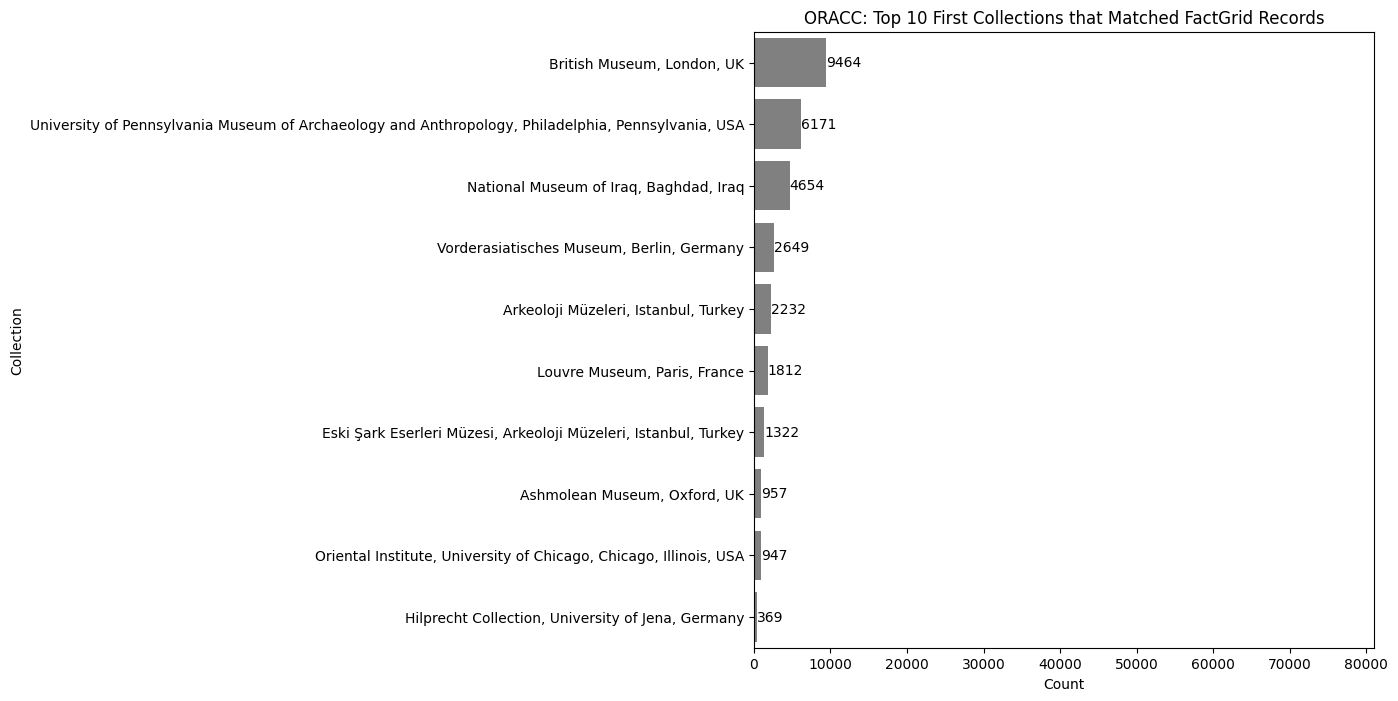

In [104]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(data = first_c_df2[0:10], y = 'first_collection', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 81000))
plt.xlabel('Count')
plt.ylabel('Collection')
plt.title('ORACC: Top 10 First Collections that Matched FactGrid Records');

###### Distribution of countries of first collections that matched

In [105]:
collection_country2 = []

for j in range(first_c_df2.shape[0]):
  current_country = first_c_df2.loc[j, 'first_collection'].split(',')[-1].replace(' ', '')
  collection_country2 += [current_country]

first_c_df2['collection_country'] = collection_country2

first_c_df2

,first_collection,count,collection_country
0,"British Museum, London, UK",9464,UK
1,University of Pennsylvania Museum of Archaeolo...,6171,USA
2,"National Museum of Iraq, Baghdad, Iraq",4654,Iraq
3,"Vorderasiatisches Museum, Berlin, Germany",2649,Germany
4,"Arkeoloji Müzeleri, Istanbul, Turkey",2232,Turkey
5,"Louvre Museum, Paris, France",1812,France
6,"Eski Şark Eserleri Müzesi, Arkeoloji Müzeleri,...",1322,Turkey
7,"Ashmolean Museum, Oxford, UK",957,UK
8,"Oriental Institute, University of Chicago, Chi...",947,USA
9,"Hilprecht Collection, University of Jena, Germany",369,Germany


In [106]:
first_c_country_count2 = first_c_df2.groupby(['collection_country'])['collection_country', 'count'].agg(sum)\
.reset_index()\
.sort_values(by = 'count', ascending = False)\
.reset_index(drop = True)

first_c_country_count2

<ipython-input-106-1a8b76927ae6>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  first_c_country_count2 = first_c_df2.groupby(['collection_country'])['collection_country', 'count'].agg(sum)\
<ipython-input-106-1a8b76927ae6>:1: FutureWarning: The operation <built-in function sum> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  first_c_country_count2 = first_c_df2.groupby(['collection_country'])['collection_country', 'count'].agg(sum)\


,collection_country,count
0,UK,10469
1,USA,8066
2,Iraq,4654
3,Turkey,3554
4,Germany,3029
5,France,1818
6,Syria,402
7,Spain,132
8,Belgium,121
9,RussianFederation,65


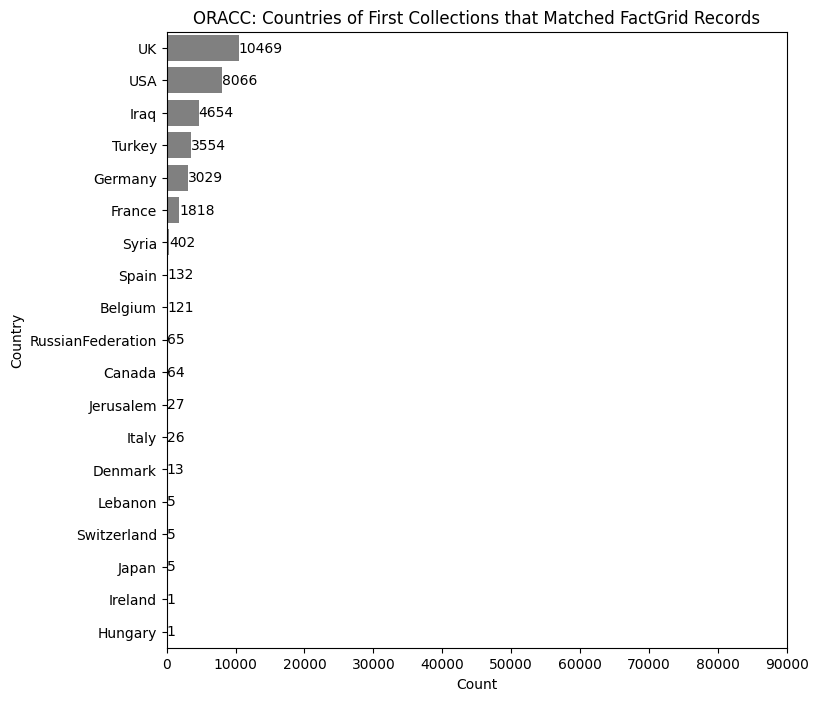

In [107]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(data = first_c_country_count2, y = 'collection_country', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 90000))
plt.xlabel('Count')
plt.ylabel('Country')
plt.title('ORACC: Countries of First Collections that Matched FactGrid Records');

###### Distribution of unmatched collections

In [108]:
collection_df2.iloc[no_match_indices_collection2].groupby('oracc_dump_collection')['oracc_dump_collection'].count()

oracc_dump_collection
A'ali, Bahrain                                                                                   6
Abbey Museum, Queensland, Australia                                                              1
Abu Shahrain, Iraq                                                                               4
Aichi Prefectural University, Aichi, Japan                                                       2
Albertson College of Idaho, Caldwell, Idaho, USA                                                 1
                                                                                                ..
unlocated: reconstructed parallel to Zb-02 (a)                                                   1
École Biblique et Archéologique Française, Jerusalem                                             2
École Pratique des Hautes Études, Paris, France                                                 10
École Pratique des Hautes Études, Paris, France; Vorderasiatisches Museum, Berlin, Germ

In [109]:
unmatched_collections2 = collection_df2.iloc[no_match_indices_collection2]['oracc_dump_collection']
unmatched_collections_clean2 = []

for c in unmatched_collections2:
  # we only consider the non-empty ones
  if (c != '') & (c != '-'):
    # remove the unceratinty marks
    c = str(c).replace('?', '').rstrip()

    # split a multi statement, if yes
    lst = str(c).split('; ')

    unmatched_collections_clean2 += lst

# remove the space attached to some entries which are resulted from splitting by ;
unmatched_collections_clean2 = [x.rstrip() for x in unmatched_collections_clean2]


pd.unique(pd.Series(unmatched_collections_clean2))

array(['German Archaeological Institute, Berlin, Germany (on loan, University of Heidelberg)',
       'unlocated', 'nan', 'private: anonymous, unlocated',
       'private: Michail, Louise, Milan, Italy',
       'Mead Art Gallery, Amherst College, Amherst, Massacusetts, USA',
       'Bible Lands Museum, Pittsburgh Theological Seminary, Pittsburgh, Pennsylvania, USA',
       'Kyoto University, Kyoto, Japan',
       'Crozer Theological Seminary, Rochester, New York, USA',
       'de Liagre Böhl Collection, Netherlands Institute for the Near East, Leiden, Holland',
       "Musées royaux d'Art et d'Histoire, Brussels, Belgium",
       'National Museum of Syria, Der-ez-Zor, Syria',
       'National Museum, Tehran, Iran',
       'private: de Serres, J. Mariaud, Paris, France',
       'private: Foroughi, Mohsen, Tehran, Iran',
       'J. Pierpont Morgan Library Collection, New York, New York, USA',
       'private: Frauenberger, K., Germany',
       'Kalamazoo Valley Museum, Kalamazoo, Michiga

In [110]:
# get the frequencies of elements in the list
d2 = collections.Counter(unmatched_collections_clean2)

# turn the langs and their counts into a dataframe
unmatched_c_df2 = pd.DataFrame.from_dict(d2, orient = 'index').\
reset_index().\
rename(columns = {'index': 'collection', 0: 'count'}).\
sort_values(by = 'count', ascending = False).\
reset_index(drop = True)

unmatched_c_df2

,collection,count
0,nan,327408
1,unlocated,1606
2,"Department of Near Eastern Studies, Cornell Un...",698
3,"Anadolu Medeniyetleri Müzesi, Ankara, Turkey",511
4,"Schøyen Collection, Oslo, Norway",453
...,...,...
672,unlocated: reconstructed according to unlocate...,1
673,"M.H. De Young Museum, San Francisco, Californi...",1
674,"Christ Church College, Oxford, UK (a)",1
675,"Museum Calouste Gulbenkian, Lisbon, Portugal (a)",1


In [111]:
unmatched_c_df2.to_csv(folder + 'ORACC_DFS/unmatched_oracc_collections_df.csv')

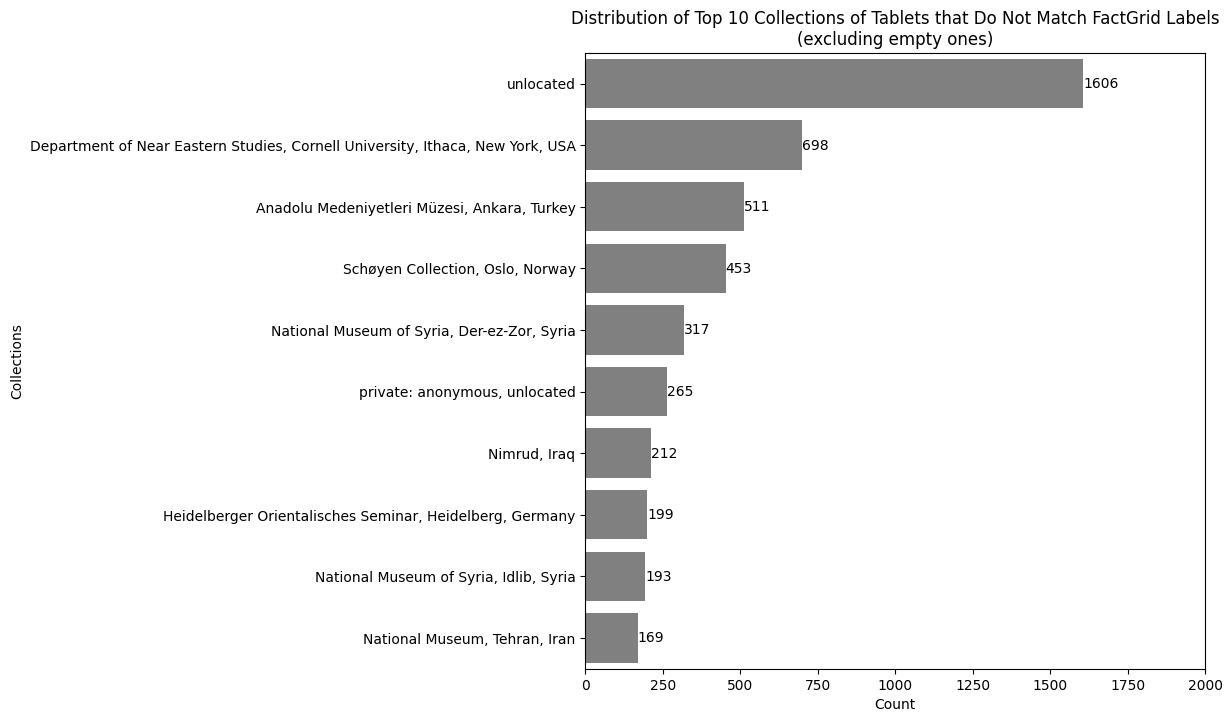

In [112]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(data = unmatched_c_df2[1:11], y = 'collection', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 2000))
plt.xlabel('Count')
plt.ylabel('Collections')
plt.title('Distribution of Top 10 Collections of Tablets that Do Not Match FactGrid Labels\n(excluding empty ones)');

#### 3.3 Merging collections of CDLI and ORACC

In [113]:
print(collection_df.shape)
collection_df.head()

(366916, 12)


,id_text,cdli_dump_collection,collection,collection_qid,collection_wikidata_id,collection_name,collection_name_native,collection_url,wiki_url_eng,wiki_url_native,P155_collection,other_collection
0,P000001,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
1,P000002,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
2,P000003,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
3,P000004,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
4,P000005,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,


In [114]:
print(collection_df2.shape)
collection_df2.head()

(366916, 12)


,id_text,oracc_dump_collection,collection,collection_qid,collection_wikidata_id,collection_name,collection_name_native,collection_url,wiki_url_eng,wiki_url_native,P155_collection,other_collection
0,P000001,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
1,P000002,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
2,P000003,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
3,P000004,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,
4,P000005,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,


In [115]:
collection_df.columns

Index(['id_text', 'cdli_dump_collection', 'collection', 'collection_qid',
       'collection_wikidata_id', 'collection_name', 'collection_name_native',
       'collection_url', 'wiki_url_eng', 'wiki_url_native', 'P155_collection',
       'other_collection'],
      dtype='object')

In [116]:
collections_df = pd.merge(collection_df, collection_df2, on="id_text", how = 'outer')
final_collections_df = collections_df[['id_text', 'collection_x', 'collection_y', 'collection_qid_x', 'collection_qid_y',
                                  'collection_wikidata_id_x', 'collection_wikidata_id_y', 'collection_name_x', 'collection_name_y', 'collection_name_native_x','collection_name_native_y',
                                  'collection_url_x', 'collection_url_y', 'wiki_url_eng_x','wiki_url_eng_y', 'wiki_url_native_x','wiki_url_native_y', 'P155_collection_x', 'P155_collection_y',
                                  'other_collection_x', 'other_collection_y']]

final_collections_df

,id_text,collection_x,collection_y,collection_qid_x,collection_qid_y,collection_wikidata_id_x,collection_wikidata_id_y,collection_name_x,collection_name_y,collection_name_native_x,collection_name_native_y,collection_url_x,collection_url_y,wiki_url_eng_x,wiki_url_eng_y,wiki_url_native_x,wiki_url_native_y,P155_collection_x,P155_collection_y,other_collection_x,other_collection_y
0,P000001,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q510658,Q542084,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,,,
1,P000002,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q510658,Q542084,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,,,
2,P000003,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q510658,Q542084,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,,,
3,P000004,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q510658,Q542084,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,,,
4,P000005,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q510658,Q542084,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366911,X096677,,,,,,,,,,,,,,,,,,,,
366912,X201001,,,,,,,,,,,,,,,,,,,,
366913,X201002,,,,,,,,,,,,,,,,,,,,
366914,X225104,,,,,,,,,,,,,,,,,,,,


## 4 __provenience = find spot [(P695)](https://database.factgrid.de/wiki/Property:P695)__

####4.1. Use this CSV to obtain the FactGrid Q-ids for each provenience location in the CDLI catalog:

https://drive.google.com/file/d/1C8hj2nVC8_qzFb8HbArbMpsx41OAV9-m/view?usp=share_link

####4.2. Matching can be done either on the cdli 'provenience' label, or on the 'cdli_id2' number [(P694)](https://database.factgrid.de/entity/P694), but we will need to add the `id_text2` from the original cdli_cat.csv

####4.3. make a data frame, called `provenience_df`, for all matches of the text's 'provenience' to  FactGrid Q-id for 'find spot'.

#### 4.4 Add two columns as qualifiers:
* 'excavation_no' = [P804](https://database.factgrid.de/entity/P804) Inventory number
* 'findspot_square' = [P425](https://database.factgrid.de/entity/P425) Precision of localisation

* Example text [P285665](https://cdli.mpiwg-berlin.mpg.de/artifacts/285665)

|id_text|P695|provenience|excavation_no|findspot_square|
|-------|------|-------------|-------------|-----------------|
|285665|Q390001|Assur (mod. Qalat Sherqat)|Ass 17861,d + Ass 17861,b + Ass 17861,g + Ass 17861,a|hD81 (house of the exorcist), excavation trench|

####4.5. make a separate data frame of all texts which were not matched (or no location identified): `no_provenience_df`.
#####4.5.1. export a CSV of all the unique values (done 7/11/23)
#####4.5.2. Resolve the non-matched labels for the occurance of '?' in the label, or ':' as a separator of joined labels.
* If there are any question marks, we can use the P155 field in a new column and fill the cell with [Q22757](https://database.factgrid.de/wiki/Item:Q22757), then remove the question mark from the label
* For labels with double entries, seaprated by a colon ':' we can add these to a new column named: find_spot_2, find_spot_3, etc.
#####4.5.3. Optional: when a provenience label consists of multiple labels joined by ':', we can add the separated labels to a new dataframe, which we can use for matching purposes. This will be useful for making a lookup table for future tasks as well, i.e. when matching with the toponyms for provenience from the ocr-output, where the spellings of these toponyms change depending on the langauge.

In [117]:
otest = pd.read_csv(folder + '/LOD Tablet Dictionary (FG Cuneiform) - FG_CIGS.csv', sep = ',', low_memory=False)
#otest_ref = otest.fillna(, inplace = True)
otest_ref = otest.drop_duplicates(keep = 'first').copy()
otest_ref['id_text2'] = otest_ref["id_text2"].astype(float)

cat_df1 = metacatalogue[['id_text','provenience_x']].copy().rename(columns = {'provenience_x':'provenience'})
cat_df2 = metacatalogue[['id_text','provenience_y']].copy().rename(columns = {'provenience_y':'provenience'})

In [118]:
otest_ref

,FG_qid,provenience,ancientplace,Len,id_text2
0,Q390152,NaN,https://database.factgrid.de/entity/Q390152,Muradiye,NaN
1,Q389888,Garšana (mod. uncertain),https://database.factgrid.de/entity/Q389888,Garshana,38.0
2,Q389722,uncertain (mod. Shahr-i Sokhta),https://database.factgrid.de/entity/Q389722,Shahr-i Sūkhta,309.0
3,Q390040,Samal (mod. Zinčirli),https://database.factgrid.de/entity/Q390040,Zinčirli,14.0
4,Q389604,Kourion (mod. Cyprus),https://database.factgrid.de/entity/Q389604,Kourion,375.0
...,...,...,...,...,...
602,Q390049,NaN,https://database.factgrid.de/entity/Q390049,Kenk Boǧazı,NaN
603,Q390089,NaN,https://database.factgrid.de/entity/Q390089,Kotanlı,NaN
604,Q390008,NaN,https://database.factgrid.de/entity/Q390008,Kāmid al-Lūz,NaN
605,Q390009,NaN,https://database.factgrid.de/entity/Q390009,Kānī Shāyah,NaN


In [119]:
cat_df1

,id_text,provenience
0,P000001,Uruk (mod. Warka)
1,P000002,Uruk (mod. Warka)
2,P000003,Uruk (mod. Warka)
3,P000004,Uruk (mod. Warka)
4,P000005,Uruk (mod. Warka)
...,...,...
366911,X096677,NaN
366912,X201001,NaN
366913,X201002,NaN
366914,X225104,NaN


In [120]:
cdli_proveniences_df = cat_df1.merge(otest_ref, how = "left", on = "provenience")
cdli_proveniences_df = cdli_proveniences_df.drop_duplicates(subset=['id_text'],ignore_index=True)

cdli_proveniences_df

,id_text,provenience,FG_qid,ancientplace,Len,id_text2
0,P000001,Uruk (mod. Warka),Q390030,https://database.factgrid.de/entity/Q390030,Warkāʼ,105.0
1,P000002,Uruk (mod. Warka),Q390030,https://database.factgrid.de/entity/Q390030,Warkāʼ,105.0
2,P000003,Uruk (mod. Warka),Q390030,https://database.factgrid.de/entity/Q390030,Warkāʼ,105.0
3,P000004,Uruk (mod. Warka),Q390030,https://database.factgrid.de/entity/Q390030,Warkāʼ,105.0
4,P000005,Uruk (mod. Warka),Q390030,https://database.factgrid.de/entity/Q390030,Warkāʼ,105.0
...,...,...,...,...,...,...
366911,X096677,NaN,Q390152,https://database.factgrid.de/entity/Q390152,Muradiye,NaN
366912,X201001,NaN,Q390152,https://database.factgrid.de/entity/Q390152,Muradiye,NaN
366913,X201002,NaN,Q390152,https://database.factgrid.de/entity/Q390152,Muradiye,NaN
366914,X225104,NaN,Q390152,https://database.factgrid.de/entity/Q390152,Muradiye,NaN


In [121]:
oracc_proveniences_df = cat_df2.merge(otest_ref, how = "left", on = "provenience")
oracc_proveniences_df = oracc_proveniences_df.drop_duplicates(subset=['id_text'],ignore_index=True)[["id_text","provenience"]]

oracc_proveniences_df

,id_text,provenience
0,P000001,Warka (Uruk)
1,P000002,Warka (Uruk)
2,P000003,Warka (Uruk)
3,P000004,Warka (Uruk)
4,P000005,Warka (Uruk)
...,...,...
366911,X096677,Unknown
366912,X201001,Unknown
366913,X201002,Unknown
366914,X225104,Unknown


In [122]:
final_proveniences_df = cdli_proveniences_df.merge(oracc_proveniences_df, how = "left", on="id_text")
final_proveniences_df = final_proveniences_df[['id_text','FG_qid','provenience_x','provenience_y','ancientplace','Len']]

## 5 __object_type = Instance of [(P2)](https://database.factgrid.de/wiki/Property:P2)__
####5.1 Use this CSV to obtain the FactGrid Q-ids for each object type in the CDLI catalog:
https://drive.google.com/file/d/12yQ8rI-_WRSOQIcwV3TBs5xyPRHliFeK/view?usp=share_link

####5.2. Match on the cdli label for 'object_type' to obtain the FactGrid Q-id

####5.3. Make a data frame, called `object_type_df`, for all matches.

####5.4. Make a separate data frame of the texts / artifacts which were not matched: `no_object_type_df`.


note: dont have objects that overlap live as a separate class

In [123]:
object_url = 'https://raw.githubusercontent.com/ancient-world-citation-analysis/CDLI2LoD/main/data/Object%20-%20LOD%20Tablet%20Dictionary%20(FG%20Cuneiform).csv?raw=true'

otest = pd.read_csv(object_url, sep = ',')
otest_ref = otest.fillna('')
otest_ref = otest.drop_duplicates(keep = 'first')

otest_ref

,object_type,FG_qid,FG_Label
0,barrel,Q512054,Clay barrel
1,block,Q512055,Clay block
2,brick,Q512056,Clay brick
3,bulla,Q512057,Clay bulla
4,cone,Q512058,Clay cone
5,cylinder,Q512059,Clay cylinder
6,docket,Q512060,Clay docket
7,envelope,Q512061,Clay envelope
8,lentil,Q512062,Clay lentil tablet
9,prism,Q512063,Clay prism


### 5.1 CDLI objects

In [124]:
selected_cols = ['id_text', 'object_type_x']
cat = metacatalogue[selected_cols].copy().rename(columns = {'object_type_x': 'object_type'})
cat = cat.assign(object_type=cat['object_type'].str.split(' & ')).explode('object_type')
cat = cat.assign(object_type=cat['object_type'].str.split(' in ')).explode('object_type')
cat['object_type'] = cat['object_type'].replace("tablet ", "tablet")
cat['object_type'] = cat['object_type'].str.lower()
otest_ref['object_type'] = otest_ref['object_type'].replace("stamp seal", "seal")

merged_df = pd.merge(otest_ref, cat, on='object_type', how='outer', indicator=True)
merged_df
non_merged_rows = merged_df[merged_df['_merge'] != 'both']
merged_df = merged_df[merged_df['_merge'] == 'both']
merged_df = merged_df.drop('_merge', axis=1)


non_merged_rows

,object_type,FG_qid,FG_Label,id_text,_merge
357625,NaN,NaN,NaN,P290089,right_only
357626,NaN,NaN,NaN,P298619,right_only
357627,NaN,NaN,NaN,P298627,right_only
357628,NaN,NaN,NaN,P303687,right_only
357629,NaN,NaN,NaN,P312678,right_only
...,...,...,...,...,...
375143,NaN,NaN,NaN,X096677,right_only
375144,NaN,NaN,NaN,X201001,right_only
375145,NaN,NaN,NaN,X201002,right_only
375146,NaN,NaN,NaN,X225104,right_only


##### N.B. for double entries:
When an item has two object types, we will add an additional column for each id_text and fill the double / triple entires in these additional columns.

|id_text|object_type_1|object_type_2|object_type_3|
|--|--|--|--|



In [125]:
merged_df

,object_type,FG_qid,FG_Label,id_text
0,barrel,Q512054,Clay barrel,P225433
1,barrel,Q512054,Clay barrel,P225458
2,barrel,Q512054,Clay barrel,P225594
3,barrel,Q512054,Clay barrel,P225700
4,barrel,Q512054,Clay barrel,P225779
...,...,...,...,...
357620,seal (not impression),Q512065,seal,P530789
357621,seal (not impression),Q512065,seal,P530790
357622,seal (not impression),Q512065,seal,P530791
357623,seal (not impression),Q512065,seal,P530792


### 5.2 ORACC objects

In [126]:
selected_cols = ['id_text', 'object_type_y']
cat2 = metacatalogue[selected_cols].copy().rename(columns = {'object_type_y': 'object_type'})
cat2 = cat2.assign(object_type=cat2['object_type'].str.split(' & ')).explode('object_type')
cat2 = cat2.assign(object_type=cat2['object_type'].str.split(' in ')).explode('object_type')
cat2['object_type'] = cat2['object_type'].replace("tablet ", "tablet")
cat2['object_type'] = cat2['object_type'].str.lower()
otest_ref['object_type'] = otest_ref['object_type'].replace("stamp seal", "seal")

merged_df2 = pd.merge(otest_ref, cat2, on='object_type', how='outer', indicator=True)
merged_df2
non_merged_rows2 = merged_df2[merged_df2['_merge'] != 'both']
merged_df2 = merged_df2[merged_df2['_merge'] == 'both']
merged_df2 = merged_df2.drop('_merge', axis=1, )

non_merged_rows2

,object_type,FG_qid,FG_Label,id_text,_merge
11349,seal,Q512065,seal,NaN,left_only
11350,seal,Q512065,seal,NaN,left_only
122262,NaN,NaN,NaN,P000730,right_only
122263,NaN,NaN,NaN,P000731,right_only
122264,NaN,NaN,NaN,P000732,right_only
...,...,...,...,...,...
367127,rock inscription,NaN,NaN,X003038,right_only
367128,tablet &amp; envelope,NaN,NaN,X000507,right_only
367129,bowl (with sculpture),NaN,NaN,Q008358,right_only
367130,beaker,NaN,NaN,Q008359,right_only


#### N.B. for double entries:
When an item has two object types, we will add an additional column for each id_text and fill the double / triple entires in these additional columns.

|id_text|object_type_1|object_type_2|object_type_3|
|--|--|--|--|



In [127]:
merged_df2

,object_type,FG_qid,FG_Label,id_text
0,barrel,Q512054,Clay barrel,P225433
1,barrel,Q512054,Clay barrel,P225458
2,barrel,Q512054,Clay barrel,P225594
3,barrel,Q512054,Clay barrel,P225700
4,barrel,Q512054,Clay barrel,P225779
...,...,...,...,...
122257,seal (not impression),Q512065,seal,Q008907
122258,seal (not impression),Q512065,seal,Q008908
122259,seal (not impression),Q512065,seal,Q009185
122260,seal (not impression),Q512065,seal,Q009353


### Merging object dfs of CDLI and ORACC

In [128]:
objects_df = pd.merge(merged_df, merged_df2, on = 'id_text', how = 'outer')
final_objects_df = objects_df[['id_text', 'object_type_x', 'object_type_y', 'FG_qid_x', 'FG_qid_y', 'FG_Label_x', 'FG_Label_y']]
final_objects_df

,id_text,object_type_x,object_type_y,FG_qid_x,FG_qid_y,FG_Label_x,FG_Label_y
0,P225433,barrel,barrel,Q512054,Q512054,Clay barrel,Clay barrel
1,P225458,barrel,barrel,Q512054,Q512054,Clay barrel,Clay barrel
2,P225594,barrel,barrel,Q512054,Q512054,Clay barrel,Clay barrel
3,P225700,barrel,barrel,Q512054,Q512054,Clay barrel,Clay barrel
4,P225779,barrel,barrel,Q512054,Q512054,Clay barrel,Clay barrel
...,...,...,...,...,...,...,...
364784,Q008907,NaN,seal (not impression),NaN,Q512065,NaN,seal
364785,Q008908,NaN,seal (not impression),NaN,Q512065,NaN,seal
364786,Q009185,NaN,seal (not impression),NaN,Q512065,NaN,seal
364787,Q009353,NaN,seal (not impression),NaN,Q512065,NaN,seal


## 6 __genre = Field of Knowledge [(P608)](https://database.factgrid.de/wiki/Property:P608)__



#### 6.1 Use this [CSV](https://drive.google.com/file/d/1Xo-Wh0JCRDMRTpYEm5GYz_tOljUtiyLo/view?usp=drive_link) to obtain the FactGrid Q-ids for each object type in the CDLI catalog:

N.B. some items have double entries, e.g. 'prayer/incantation' or 'lexical; literary'. We can either separate these before performing the match and duplicate the item's `id_text` or we can use the additional columns for matches with multiple entries. Either way we will need to resolve the double entries in batches when using QuickStatements.

In [129]:
genre_url = 'https://github.com/ancient-world-citation-analysis/CDLI2LoD/blob/main/data/Genre%20-%20LOD%20Tablet%20Dictionary%20(FG%20Cuneiform).csv?raw=true'

genre_reference = pd.read_csv(genre_url, sep = ',', header = 1) # use the second row as column name

# fill na values with space
genre_reference = genre_reference.fillna('')
# rename the columns
genre_reference.rename(columns={'Typeofwork': 'FG_qid'}, inplace=True)
# remove entries without a FactGrid QID
genre_reference = genre_reference[genre_reference['FG_qid'] != ''].reset_index(drop = True)
# remove the question marks as we will deal with it later
genre_reference['genre'] = genre_reference['cdli_genre'].map(lambda x: x.replace('?', '').rstrip())
# drop duplicated rows
genre_reference = genre_reference.drop_duplicates(subset=['genre'])
# drop P155 and cdli_genre and reorder the dataframe
genre_reference = genre_reference[['genre', 'FG_qid', 'FG_qid_2', 'FG_qid_3', 'current_count']]


# for now, we will not consider the ones with multiple entires
# so remove the ones with ; or , in the record
genre_reference = genre_reference[[(';' not in i)&(',' not in i) for i in genre_reference['genre']]]
# drop FG_qid_2 and 3
genre_reference = genre_reference.drop(columns = ['FG_qid_2', 'FG_qid_3'])
# reset_index
genre_reference = genre_reference.reset_index(drop = True)

# standardize format to prepare for the match
genre_reference['genre'] = [g.capitalize() for g in genre_reference['genre']]
# drop rows with typo
genre_reference = genre_reference.drop([19, 20])
# reset_index
genre_reference = genre_reference.reset_index(drop = True)

genre_reference


,genre,FG_qid,current_count
0,Administrative,Q394396,10k+
1,Astronomical,Q390194,0
2,Historical,Q39130,55
3,Legal,Q388465,10k+
4,Letter,Q10510,10k+
5,Lexical,Q537054,8273
6,Literary,Q245823,10k+
7,Mathematical,Q146582,2098
8,Medical,Q76112,1054
9,Monumental,Q537039,0


#### 6.2 CDLI Genres

##### 6.2.1 Match on the cdli label 'genre' to obtain the FactGrid Q-id.

In [130]:
genre_df = metacatalogue[['id_text', 'genre_x']]
genre_df = genre_df.rename(columns = {'genre_x': 'cdli_dump_genre'})
genre_df['cdli_dump_genre'].unique()

array(['Lexical', 'Administrative', 'School', 'uncertain', 'Legal',
       'Royal/Monumental', 'Literary', 'Administrative ?', 'Mathematical',
       'Prayer/Incantation', 'Mathematical ?', 'Letter', 'School ?',
       'fake (modern)', 'Literary ?', 'Ritual', 'Private/Votive',
       'Other (see subgenre)', 'Scientific', nan, 'Royal/Monumental ?',
       'Legal ?', 'Omen', 'Uncertain', 'Literary; Mathematical',
       'Lexical; Literary', 'Lexical; Mathematical', 'Lexical; School',
       'Lexical; Literary; Mathematical', 'Literary; Lexical',
       'Literary; Letter', 'Lexical ?', 'Ritual ?', 'Royal/Votive',
       'Letter ?', 'fake (modern) ?', 'Astronomical',
       'Literary; Administrative', 'Scientific ?',
       'Royal/Monumental; Literary', 'Historical', 'Legal\x0b',
       'Private/Votive ?', 'School; Literary', 'literary', 'Omen ?',
       'Prayer/Incantation ?', 'letter', 'lexical', 'Astronomical ?',
       'Astronomical, Omen', 'Pottery (seal)', 'administrative', 'Votive',

In [131]:
genre = []
genre_qid = []
genre_count = []
P155_genre = [] # when there's a question mark
other_genre = [] # when there are multiple genres
no_match_indices_genre = [] # index of the row if there's no match


for index in range(len(genre_df['cdli_dump_genre'])):
  g = genre_df['cdli_dump_genre'][index]
  # make sure the first letter is capitalized
  g = str(g).capitalize()
  # split every entry by ;
  lst = g.replace(',', ';').split(';')

  # get the first collection
  first_g = lst[0].rstrip()

  # store the remaining ecollections (if exist) away
  other_genre += [', '.join(lst[1:])]

  # check for uncertainty
  if '?' in first_g:
    P155_genre += ['Q22757']
    first_g = first_g.replace('?', '').rstrip()
  else:
    P155_genre += ['']


  # add in qid and labels for the first_g

  # account for typos
  if first_g == 'Administative' or first_g == 'Administrative record':
    first_g = 'Administrative'

  # if the genre has a QID in FactGrid
  if first_g in genre_reference['genre'].unique():
    # record the genre
    genre += [first_g]
    # get the corresponding QID (FG_item) and Wikidata_URI
    i = genre_reference['genre'].tolist().index(first_g)
    genre_qid += [genre_reference['FG_qid'][i]]
    genre_count += [genre_reference['current_count'][i]]

  # if the period does not have a FactGrid QID, put '' for everything for now
  else:
    genre += ['']
    genre_qid += ['']
    genre_count += ['']
    no_match_indices_genre += [index]


# append these columns to the dataframe
genre_df['genre'] = genre
genre_df['genre_qid'] = genre_qid
genre_df['genre_current_count'] = genre_count
genre_df['P155_genre'] = P155_genre
genre_df['other_genre'] = other_genre

genre_df

,id_text,cdli_dump_genre,genre,genre_qid,genre_current_count,P155_genre,other_genre
0,P000001,Lexical,Lexical,Q537054,8273,,
1,P000002,Lexical,Lexical,Q537054,8273,,
2,P000003,Lexical,Lexical,Q537054,8273,,
3,P000004,Lexical,Lexical,Q537054,8273,,
4,P000005,Lexical,Lexical,Q537054,8273,,
...,...,...,...,...,...,...,...
366911,X096677,NaN,,,,,
366912,X201001,NaN,,,,,
366913,X201002,NaN,,,,,
366914,X225104,NaN,,,,,


##### 6.2.2 matched_genre_df

Make a data frame, called `matched_genre_df`, for all matches.

In [132]:
matched_genre_df = genre_df[~genre_df.index.isin(no_match_indices_genre)].reset_index(drop = True)
matched_genre_df = matched_genre_df.rename(columns={'id_text': 'cdli_dump_id'})
matched_genre_df

,cdli_dump_id,cdli_dump_genre,genre,genre_qid,genre_current_count,P155_genre,other_genre
0,P000001,Lexical,Lexical,Q537054,8273,,
1,P000002,Lexical,Lexical,Q537054,8273,,
2,P000003,Lexical,Lexical,Q537054,8273,,
3,P000004,Lexical,Lexical,Q537054,8273,,
4,P000005,Lexical,Lexical,Q537054,8273,,
...,...,...,...,...,...,...,...
285670,P532443,Legal,Legal,Q388465,10k+,,
285671,P532444,Administrative,Administrative,Q394396,10k+,,
285672,P532445,Administrative,Administrative,Q394396,10k+,,
285673,P532446,Legal,Legal,Q388465,10k+,,


In [133]:
matched_genre_df.shape

(285675, 7)

##### 6.2.3 no_match_genre_df

Make a separate data frame of the texts which were not matched: `no_match_genre_df`.

In [134]:
no_match_genre_df = metacatalogue.iloc[no_match_indices_genre]
no_match_genre_df.head()

,composite_id_x,id_text2,id_text,language_x,object_type_x,period_x,material_x,collection_x,museum_no_x,provenience_x,excavation_no_x,findspot_square_x,date_of_origin_x,dates_referenced_x,genre_x,subgenre_x,translation_source_x,id,language_y,material_y,object_type_y,period_y,provenience_y,excavation_no_y,findspot_square_y,dates_referenced_y,genre_y,subgenre_y,translation_source_y,archive,collection_y,museum-nos,mus_no,museum_no_y,cdli_museum_no,saa_cdli_museum,Mus_no,museum_number,museum,museum_URL,date_of_origin_y,dialect,date,supergenre,xproject,q_number,ancient_year,date_bce,cdli_id,OBJ_type,Period_culture,Script_type_1,Genre,Subgenre,S_s_genre,Language,Full_no,Tablet_number,Q_no,object,composite_id_y,project name,id_text_int,seal_id,cdli_composite_id,ancient_date,bdtns_id
3943,NaN,0.0,P004142,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"German Archaeological Institute, Berlin, Germa...",HD: W 20938,Uruk (mod. Warka),W 20938,"Nc XV,1",NaN,NaN,uncertain,"unclear if proto-cuneiform, other (in cartouch...",no translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8091,NaN,0.0,P010072,Sumerian,tablet,ED IIIa (ca. 2600-2500 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VA 10004,Šuruppak (mod. Fara),NaN,NaN,NaN,NaN,uncertain,NaN,no translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8092,NaN,0.0,P010073,Sumerian,tablet,ED IIIa (ca. 2600-2500 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VA 10005,Šuruppak (mod. Fara),NaN,NaN,NaN,NaN,uncertain,NaN,no translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11524,NaN,0.0,P102634,Sumerian,bulla,Ur III (ca. 2100-2000 BC),clay,"Oakland Museum of California, Oakland, Califor...",OPM 28-225,Puzriš-Dagan (mod. Drehem),NaN,NaN,Amar-Suen.03.07.00,Amar-Suen.03.07.00,uncertain,NaN,no translation,NaN,Sumerian,NaN,Bulla,Ur III,Puzriš-Dagan,NaN,NaN,NaN,uncertain,NaN,NaN,NaN,NaN,NaN,NaN,OPM 28-255,NaN,NaN,NaN,NaN,NaN,NaN,AS03 - 07 - 00,NaN,NaN,unknown,CDLI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,babcity,NaN,NaN,NaN,NaN,38784.0
11547,NaN,0.0,P102657,Sumerian,tablet & envelope,Ur III (ca. 2100-2000 BC),clay,"Hearst Museum of Anthropology, University of C...",HMA 9-00069a & HMA 9-00069b,Nippur (mod. Nuffar),NaN,NaN,Šū-Suen.08.05.13,Šū-Suen.08.05.13,uncertain,NaN,no translation,NaN,Sumerian,NaN,Envelope - Closed,Ur III,Nippur,NaN,NaN,NaN,uncertain,NaN,NaN,NaN,NaN,NaN,NaN,HMA 9-69AB,NaN,NaN,NaN,NaN,NaN,NaN,SS08 - 05 - 13,NaN,NaN,unknown,CDLI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,babcity,NaN,NaN,NaN,NaN,38807.0


In [135]:
no_match_genre_df.shape

(81241, 67)

In [136]:
matched_genre_df.shape[0] + no_match_genre_df.shape[0] == metacatalogue.shape[0]

True

##### 6.2.4 Visualization

###### Distribution of matched genre

Please note that we are calling it "genre" instead of "first genre" here because, unlike most other columns in this dump of data, there is no multi-entry of genre.

In [137]:
first_g_df = pd.DataFrame(matched_genre_df.groupby('genre')['genre'].count())
first_g_df.index.name = None
first_g_df = first_g_df.reset_index().rename(
    columns = {'index': 'genre',
               'genre': 'count'}).sort_values(by = 'count', ascending = False)
first_g_df = first_g_df.reset_index(drop = True)
first_g_df

,genre,count
0,Administrative,199275
1,Royal/monumental,22315
2,Legal,16757
3,Letter,15983
4,Literary,9816
5,Lexical,8597
6,School,3966
7,Omen,3043
8,Mathematical,1983
9,Astronomical,1631


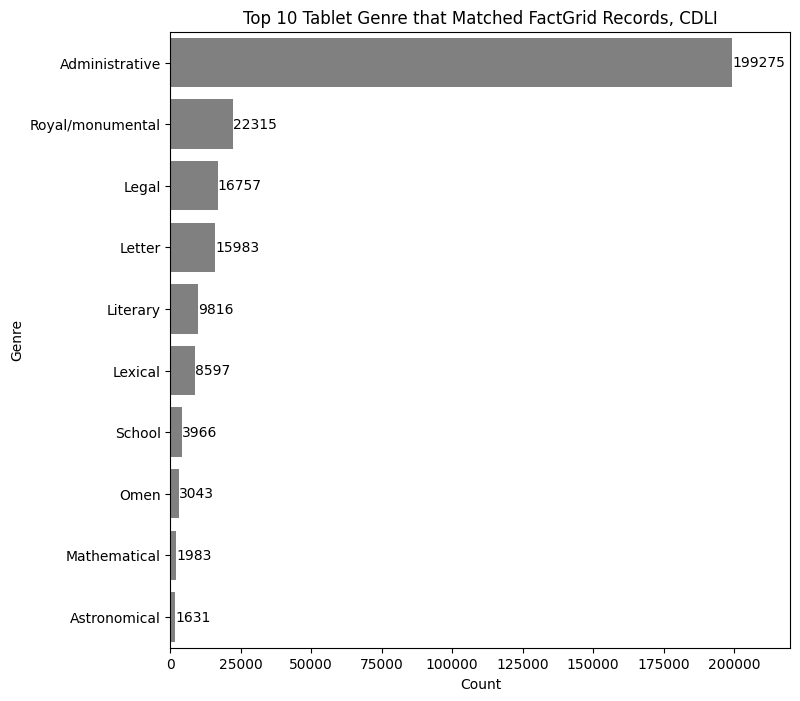

In [138]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(data = first_g_df[0:10], y = 'genre', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 220000))
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Top 10 Tablet Genre that Matched FactGrid Records, CDLI');

###### Distribution of matched genre for tablets that have text on them

In [139]:
lang_genre_matched_df = genre_df[~language_df.index.isin(no_match_indices_lang)]
lang_genre_matched_df

,id_text,cdli_dump_genre,genre,genre_qid,genre_current_count,P155_genre,other_genre
662,P000723,Lexical,Lexical,Q537054,8273,,
663,P000724,Lexical,Lexical,Q537054,8273,,
664,P000725,Lexical,Lexical,Q537054,8273,,
665,P000726,Lexical,Lexical,Q537054,8273,,
666,P000727,Lexical,Lexical,Q537054,8273,,
...,...,...,...,...,...,...,...
353278,P532443,Legal,Legal,Q388465,10k+,,
353279,P532444,Administrative,Administrative,Q394396,10k+,,
353280,P532445,Administrative,Administrative,Q394396,10k+,,
353281,P532446,Legal,Legal,Q388465,10k+,,


In [140]:
# slice the matched_mat_df with no_match_indices_lang
lang_genre_matched_df = genre_df[~language_df.index.isin(no_match_indices_lang)]
# count the materials and create a df for the material with corresponding count
lang_genre_matched_counts = pd.DataFrame(lang_genre_matched_df.groupby('genre')['genre'].count())
# rename the columns
lang_genre_matched_counts.rename(columns={lang_genre_matched_counts.columns[0]: 'count'}, inplace = True)
lang_genre_matched_counts = lang_genre_matched_counts.reset_index()
# sort the rows by count
lang_genre_matched_counts = lang_genre_matched_counts.sort_values(by = 'count', ascending = False).reset_index(drop = True)
# drop the empty one
lang_genre_matched_counts = lang_genre_matched_counts.drop(1).reset_index(drop = True)
lang_genre_matched_counts

,genre,count
0,Administrative,161871
1,Royal/monumental,18989
2,Letter,13848
3,Legal,9520
4,Literary,7721
5,Lexical,4171
6,Omen,2743
7,School,1130
8,Prayer/incantation,793
9,Ritual,302


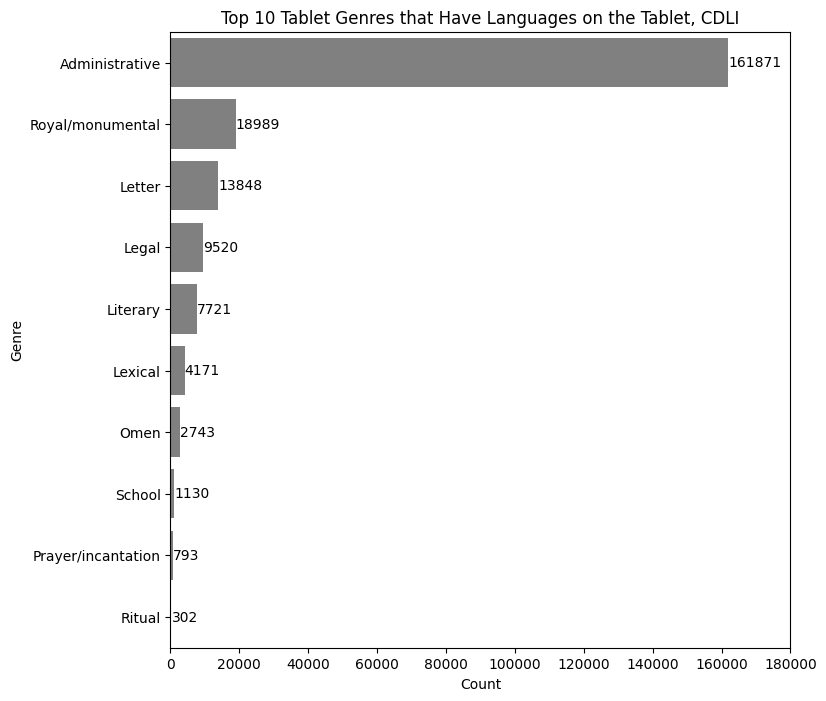

In [141]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(data = lang_genre_matched_counts[0:10], y = 'genre', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 180000))
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Top 10 Tablet Genres that Have Languages on the Tablet, CDLI');

###### Distribution of unmatched genre

In [142]:
genre_df.iloc[no_match_indices_genre].groupby('cdli_dump_genre')['cdli_dump_genre'].count()

cdli_dump_genre
Other (see subgenre)      39
Uncertain                 10
fake (modern)            230
fake (modern) ?           16
uncertain               2793
Name: cdli_dump_genre, dtype: int64

we can see that the matching of genre is actually done really well.

#### 6.3 ORACC Genres

##### 6.3.1 Match on the oracc label 'genre' to obtain the FactGrid Q-id.

In [143]:
genre_df2 = metacatalogue[['id_text', 'genre_y']]
genre_df2 = genre_df2.rename(columns = {'genre_y': 'oracc_dump_genre'})
genre_df2['oracc_dump_genre'].unique()

array(['Lexical', nan, 'mathematical', 'Administrative',
       'Royal Inscription', 'Literary', 'Legal', 'School', 'Letter',
       'uncertain', 'Royal/Monumental', 'lexical', 'fake (modern)',
       'Mathematical', 'Prayer/Incantation', 'Signlists', 'Scientific',
       'Literary Work', 'Ritual', 'Liturgy', 'Royal lnscription',
       'school', 'Administrative Letter', 'Legal Transaction',
       'Administrative Record', 'Uncertain', 'Ritual Text',
       'Lexical Text', 'Literary Text', 'Incantation',
       'Literary; Mathematical', 'Astrological Report', 'Extispicy Query',
       'Scholarly Letter', 'Priestly Letter', 'Extispicy Report',
       'Treaty', 'Divination', 'Medical', 'Miscellanea', 'Omen',
       'Lexical; Mathematical', 'Literary; Administrative',
       'Divination (astrological)', 'letter', 'scholarly',
       'administrative', 'Lexical; Literary', 'Royal Ritual',
       'technical procedure', 'Eponym List', 'Votive Donation', 'Decree',
       'Grant', 'Magic', 'Inc

In [144]:
genre2 = []
genre_qid2 = []
genre_count2 = []
P155_genre2 = [] # when there's a question mark
other_genre2 = [] # when there are multiple genres
no_match_indices_genre2 = [] # index of the row if there's no match


for index in range(len(genre_df2['oracc_dump_genre'])):
  g = genre_df2['oracc_dump_genre'][index]
  # make sure the first letter is capitalized
  g = str(g).capitalize()
  # split every entry by ;
  lst = g.replace(',', ';').split(';')

  # get the first collection
  first_g = lst[0].rstrip()

  # store the remaining ecollections (if exist) away
  other_genre2 += [', '.join(lst[1:])]

  # check for uncertainty
  if '?' in first_g:
    P155_genre2 += ['Q22757']
    first_g = first_g.replace('?', '').rstrip()
  else:
    P155_genre2 += ['']


  # add in qid and labels for the first_g

  # account for typos
  if first_g == 'Administative' or first_g == 'Administrative record':
    first_g = 'Administrative'

  # if the genre has a QID in FactGrid
  if first_g in genre_reference['genre'].unique():
    # record the genre
    genre2 += [first_g]
    # get the corresponding QID (FG_item) and Wikidata_URI
    i = genre_reference['genre'].tolist().index(first_g)
    genre_qid2 += [genre_reference['FG_qid'][i]]
    genre_count2 += [genre_reference['current_count'][i]]

  # if the period does not have a FactGrid QID, put '' for everything for now
  else:
    genre2 += ['']
    genre_qid2 += ['']
    genre_count2 += ['']
    no_match_indices_genre2 += [index]


# append these columns to the dataframe
genre_df2['genre'] = genre2
genre_df2['genre_qid'] = genre_qid2
genre_df2['genre_current_count'] = genre_count2
genre_df2['P155_genre'] = P155_genre2
genre_df2['other_genre'] = other_genre2

genre_df2

,id_text,oracc_dump_genre,genre,genre_qid,genre_current_count,P155_genre,other_genre
0,P000001,Lexical,Lexical,Q537054,8273,,
1,P000002,Lexical,Lexical,Q537054,8273,,
2,P000003,Lexical,Lexical,Q537054,8273,,
3,P000004,Lexical,Lexical,Q537054,8273,,
4,P000005,Lexical,Lexical,Q537054,8273,,
...,...,...,...,...,...,...,...
366911,X096677,NaN,,,,,
366912,X201001,NaN,,,,,
366913,X201002,NaN,,,,,
366914,X225104,NaN,,,,,


##### 6.3.2 matched_genre_df2

Make a data frame, called `matched_genre_df2`, for all matches.

In [145]:
matched_genre_df2 = genre_df2[~genre_df2.index.isin(no_match_indices_genre2)].reset_index(drop = True)
matched_genre_df2 = matched_genre_df2.rename(columns={'id_text': 'oracc_dump_id'})
matched_genre_df2

,oracc_dump_id,oracc_dump_genre,genre,genre_qid,genre_current_count,P155_genre,other_genre
0,P000001,Lexical,Lexical,Q537054,8273,,
1,P000002,Lexical,Lexical,Q537054,8273,,
2,P000003,Lexical,Lexical,Q537054,8273,,
3,P000004,Lexical,Lexical,Q537054,8273,,
4,P000005,Lexical,Lexical,Q537054,8273,,
...,...,...,...,...,...,...,...
112655,P512808,Administrative,Administrative,Q394396,10k+,,
112656,P512821,Administrative,Administrative,Q394396,10k+,,
112657,P512822,Administrative,Administrative,Q394396,10k+,,
112658,P515099,Administrative,Administrative,Q394396,10k+,,


In [146]:
matched_genre_df2.shape

(112660, 7)

##### 6.3.3 no_match_genre_df

Make a separate data frame of the texts which were not matched: `no_match_genre_df`.

In [147]:
no_match_genre_df2 = metacatalogue.iloc[no_match_indices_genre2]
no_match_genre_df2.head()

,composite_id_x,id_text2,id_text,language_x,object_type_x,period_x,material_x,collection_x,museum_no_x,provenience_x,excavation_no_x,findspot_square_x,date_of_origin_x,dates_referenced_x,genre_x,subgenre_x,translation_source_x,id,language_y,material_y,object_type_y,period_y,provenience_y,excavation_no_y,findspot_square_y,dates_referenced_y,genre_y,subgenre_y,translation_source_y,archive,collection_y,museum-nos,mus_no,museum_no_y,cdli_museum_no,saa_cdli_museum,Mus_no,museum_number,museum,museum_URL,date_of_origin_y,dialect,date,supergenre,xproject,q_number,ancient_year,date_bce,cdli_id,OBJ_type,Period_culture,Script_type_1,Genre,Subgenre,S_s_genre,Language,Full_no,Tablet_number,Q_no,object,composite_id_y,project name,id_text_int,seal_id,cdli_composite_id,ancient_date,bdtns_id
669,NaN,0.0,P000730,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15316,Uruk (mod. Warka),"W 01872,1","Od XV,5",NaN,NaN,Administrative,NaN,no translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
670,NaN,0.0,P000731,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15315,Uruk (mod. Warka),"W 01872,2","Od XV,5",NaN,NaN,Administrative,NaN,no translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
671,NaN,0.0,P000732,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15345,Uruk (mod. Warka),W 02134,?,NaN,NaN,Administrative,NaN,no translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
672,NaN,0.0,P000733,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15289,Uruk (mod. Warka),W 02352,"Oc XV,5",NaN,NaN,Administrative,NaN,no translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
673,NaN,0.0,P000734,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15245,Uruk (mod. Warka),"W 05233,a","Pd XVI,4",NaN,NaN,Administrative,NaN,no translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
no_match_genre_df2.shape

(254256, 67)

In [149]:
matched_genre_df2.shape[0] + no_match_genre_df2.shape[0] == metacatalogue.shape[0]

True

##### 6.3.4 Visualization

###### Distribution of matched genre

Please note that we are calling it "genre" instead of "first genre" here because, unlike most other columns in this dump of data, there is no multi-entry of genre.

In [150]:
first_g_df2 = pd.DataFrame(matched_genre_df2.groupby('genre')['genre'].count())
first_g_df2.index.name = None
first_g_df2 = first_g_df2.reset_index().rename(
    columns = {'index': 'genre',
               'genre': 'count'}).sort_values(by = 'count', ascending = False)
first_g_df2 = first_g_df2.reset_index(drop = True)
first_g_df2

,genre,count
0,Administrative,91116
1,Lexical,7583
2,Literary,6107
3,Legal,2640
4,Mathematical,1193
5,Letter,1187
6,School,870
7,Prayer/incantation,846
8,Omen,554
9,Medical,265


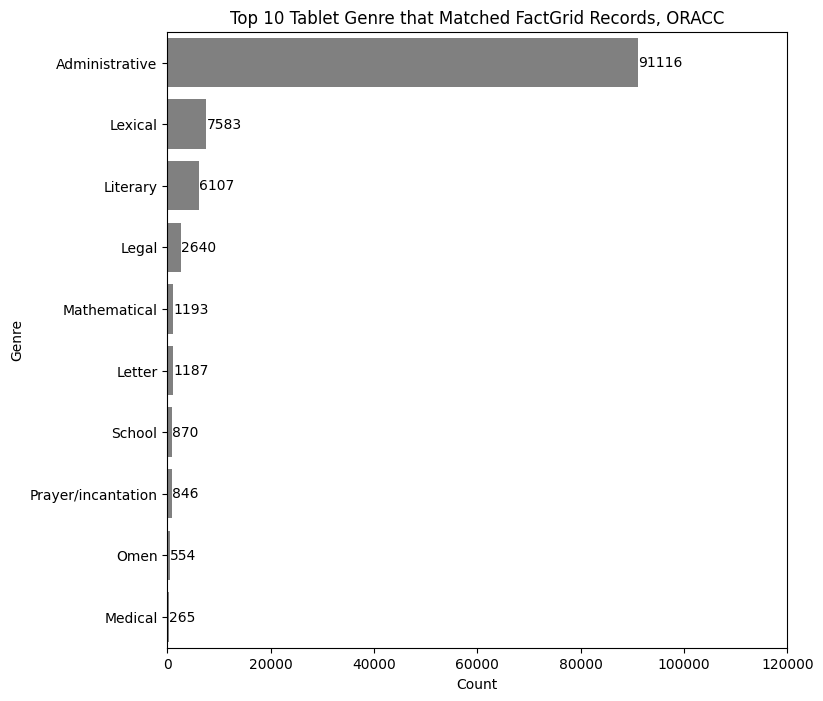

In [151]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(data = first_g_df2[0:10], y = 'genre', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 120000))
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Top 10 Tablet Genre that Matched FactGrid Records, ORACC');

###### Distribution of matched genre for tablets that have text on them

In [152]:
lang_genre_matched_df2 = genre_df2[~language_df.index.isin(no_match_indices_lang2)]
lang_genre_matched_df2

,id_text,oracc_dump_genre,genre,genre_qid,genre_current_count,P155_genre,other_genre
662,P000723,Lexical,Lexical,Q537054,8273,,
663,P000724,Lexical,Lexical,Q537054,8273,,
664,P000725,Lexical,Lexical,Q537054,8273,,
665,P000726,Lexical,Lexical,Q537054,8273,,
666,P000727,Lexical,Lexical,Q537054,8273,,
...,...,...,...,...,...,...,...
366883,P512808,Administrative,Administrative,Q394396,10k+,,
366884,P512821,Administrative,Administrative,Q394396,10k+,,
366885,P512822,Administrative,Administrative,Q394396,10k+,,
366886,P515099,Administrative,Administrative,Q394396,10k+,,


In [153]:
# slice the matched_mat_df with no_match_indices_lang
lang_genre_matched_df2 = genre_df2[~language_df.index.isin(no_match_indices_lang2)]
# count the materials and create a df for the material with corresponding count
lang_genre_matched_counts2 = pd.DataFrame(lang_genre_matched_df2.groupby('genre')['genre'].count())
# rename the columns
lang_genre_matched_counts2.rename(columns={lang_genre_matched_counts2.columns[0]: 'count'}, inplace = True)
lang_genre_matched_counts2 = lang_genre_matched_counts2.reset_index()
# sort the rows by count
lang_genre_matched_counts2 = lang_genre_matched_counts2.sort_values(by = 'count', ascending = False).reset_index(drop = True)
# drop the empty one
lang_genre_matched_counts2 = lang_genre_matched_counts2.drop(1).reset_index(drop = True)
lang_genre_matched_counts2

,genre,count
0,Administrative,90783
1,Literary,5751
2,Lexical,3495
3,Legal,2553
4,Prayer/incantation,844
5,Letter,838
6,School,268
7,Omen,173
8,Astronomical,140
9,Ritual,91


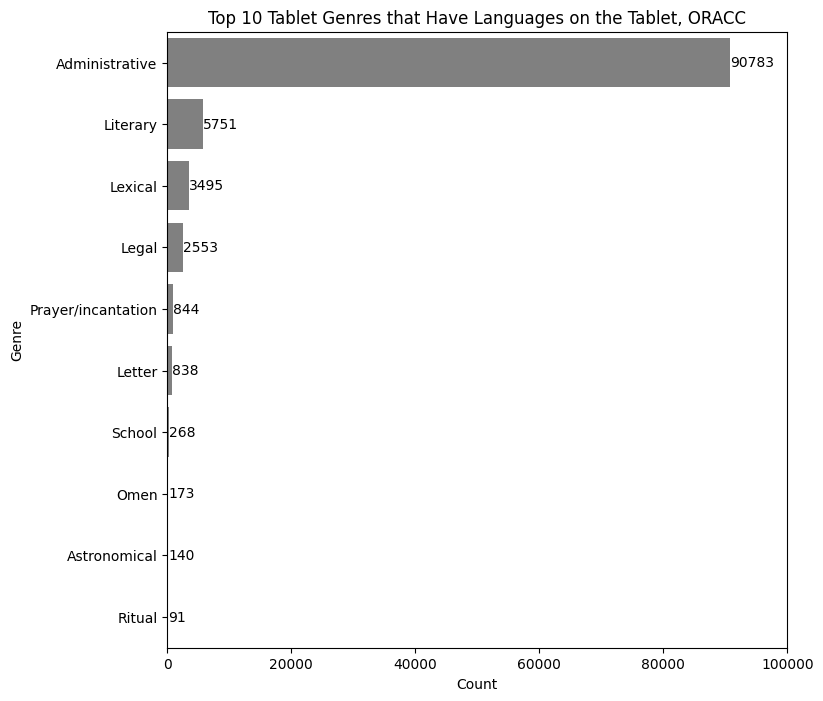

In [154]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(data = lang_genre_matched_counts2[0:10], y = 'genre', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 100000))
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Top 10 Tablet Genres that Have Languages on the Tablet, ORACC');

###### Distribution of unmatched genre

In [155]:
genre_df2.iloc[no_match_indices_genre2].groupby('oracc_dump_genre')['oracc_dump_genre'].count()

oracc_dump_genre
Administrative Letter    2099
Appointment                 4
Astrological               20
Astrological Report       567
Astronomical Diary        417
                         ... 
planetary text             55
scholarly                  34
technical procedure         1
uncertain                  64
unknown                   135
Name: oracc_dump_genre, Length: 73, dtype: int64

we can see that the matching of genre is actually done really well.

#### Merging genre dfs of CDLI and ORACC

In [156]:
genres_df = pd.merge(genre_df, genre_df2, on = 'id_text', how = 'outer')
final_genres_df = genres_df[['id_text','genre_x', 'genre_y','genre_qid_x','genre_qid_y','genre_current_count_x','genre_current_count_y','P155_genre_x','P155_genre_y','other_genre_x','other_genre_y']]
final_genres_df

,id_text,genre_x,genre_y,genre_qid_x,genre_qid_y,genre_current_count_x,genre_current_count_y,P155_genre_x,P155_genre_y,other_genre_x,other_genre_y
0,P000001,Lexical,Lexical,Q537054,Q537054,8273,8273,,,,
1,P000002,Lexical,Lexical,Q537054,Q537054,8273,8273,,,,
2,P000003,Lexical,Lexical,Q537054,Q537054,8273,8273,,,,
3,P000004,Lexical,Lexical,Q537054,Q537054,8273,8273,,,,
4,P000005,Lexical,Lexical,Q537054,Q537054,8273,8273,,,,
...,...,...,...,...,...,...,...,...,...,...,...
366911,X096677,,,,,,,,,,
366912,X201001,,,,,,,,,,
366913,X201002,,,,,,,,,,
366914,X225104,,,,,,,,,,


## 7 __period = Period [(P853)](https://database.factgrid.de/wiki/Property:P853)__

#### 7.1 Use this CSV to obtain the FactGrid Q-ids for each period of each texts in the CDLI catalog

 https://drive.google.com/file/d/1GCYneZi-SVA49iRfVMP_mH-0LFLRpIaQ/view?usp=share_link

* note that this CSV contains Wikidata Q-ids, along with the begin / end of the other chronologies (high, low, middle, etc.)

In [157]:
period_url = 'https://github.com/ancient-world-citation-analysis/CDLI2LoD/blob/main/data/Period%20-%20LOD%20Tablet%20Dictionary%20(FG%20Cuneiform).csv?raw=true'

# read in the data
# note that we fill.na with 99999999 here so that we can edit the data type of years later
period_reference = pd.read_csv(period_url, sep = ',').fillna('')

# select only the columns we want
period_reference = period_reference[['Factgrid-Q', 'cdli_period',
                                     'Wikidata_URI']]
# clean the column names
period_reference = period_reference.rename(columns = {'Factgrid-Q': 'FG_qid'})
# drop the first row that is empty
period_reference = period_reference.iloc[1: , :]
# use only rows with a QID
period_reference = period_reference[period_reference['FG_qid'] != ''].reset_index(drop = True)

period_reference

,FG_qid,cdli_period,Wikidata_URI
0,Q512118,Pre-Writing (ca. 8500-3500 BC),Q114877825
1,Q512131,Uruk V (ca. 3500-3350 BC),Q114877817
2,Q512132,Uruk IV (ca. 3350-3200 BC),Q114877809
3,Q512133,Egyptian 0 (ca. 3300-3000 BC),Q187979
4,Q512134,Uruk III (ca. 3200-3000 BC),Q114877803
5,Q512135,Proto-Elamite (ca. 3100-2900 BC),Q1196237
6,Q512136,Early Dynastic Period,Q716742
7,Q512137,ED I,Q99299898
8,Q512137,ED I-II (ca. 2900-2700 BC),Q99299898
9,Q512139,ED II,Q99299906


### 7.2 CDLI Periods

####7.2.1 Match on the CDLI 'period' label to obtain the FactGrid Q-id.

 Make a data frame, called `period_df`, for all matches.
* if there's a question mark in the CDLI for period, you can use the same method as the `language_df` above, by adding the following column:

| id_text | period | [(P155)](https://database.factgrid.de/wiki/Property:P155)|
| -- | ------- | ------ |
|  'id_text' in cdli_cat.csv |'period' in cdli_cat.csv | [Q22757](https://database.factgrid.de/wiki/Item:Q22757)|

Make a separate data from of the texts which were not matched: `no_period_df`.

In [158]:
period_df = metacatalogue[['id_text', 'period_x']]
period_df = period_df.rename(columns = {'period_x': 'cdli_dump_period'})
period_df['cdli_dump_period'].unique()

array(['Uruk III (ca. 3200-3000 BC)', 'Uruk IV (ca. 3350-3200 BC)',
       'ED I-II (ca. 2900-2700 BC)', 'Uruk V (ca. 3500-3350 BC)',
       'Uruk V (ca. 3500-3350 BC) ?', 'ED IIIa (ca. 2600-2500 BC)',
       'Proto-Elamite (ca. 3100-2900 BC)', 'uncertain',
       'Pre-Uruk V (ca. 8500-3500 BC)',
       'Old Babylonian (ca. 1900-1600 BC)',
       'ED I-II (ca. 2900-2700 BC) ?', 'ED IIIb (ca. 2500-2340 BC)',
       'Ur III (ca. 2100-2000 BC)', 'Old Akkadian (ca. 2340-2200 BC)',
       'Lagash II (ca. 2200-2100 BC)', 'Lagash II (ca. 2200-2100 BC) ?',
       'Old Babylonian (ca. 1900-1600 BC) ?',
       'Ur III (ca. 2100-2000 BC) ?',
       'Early Old Babylonian (ca. 2000-1900 BC)',
       'Old Akkadian (ca. 2340-2200 BC) ?',
       'Neo-Babylonian (ca. 626-539 BC)',
       'Early Old Babylonian (ca. 2000-1900 BC) ?',
       'Old Assyrian (ca. 1950-1850 BC)', 'Achaemenid (547-331 BC)',
       'ED IIIb (ca. 2500-2340 BC) ?', 'Neo-Assyrian (ca. 911-612 BC)',
       'Old Akkadian (ca. 2340-2

Typically, we need to clean this first, but the period data looks pretty neat after manual inspection so we will skip for now. We dealt with some special cases according to this csv file: [link](https://docs.google.com/spreadsheets/d/1ttueqlFrtNE4eaZDdDq80Ksc4Wg8pwxXeS8eCiiHjmQ/edit#gid=714968975).

In [159]:
period = []
period_qid = []
period_wikidata_URI = []
P155_period = [] # when there's a question mark
other_possible_period = [] # when there are multiple estimations of period
no_match_indices_period = [] # index of the row if there's no match


for index in range(len(period_df['cdli_dump_period'])):
  p = period_df['cdli_dump_period'][index]
  # split every entry by ;
  lst = str(p).replace(',', ';').replace('or', ';').split(';')

  # get the first estimated period
  first_p = lst[0].rstrip()

  # store the remaining estimations (if exist) away
  other_possible_period += [', '.join(lst[1:])]

  # check for uncertainty
  if '?' in first_p:
    P155_period += ['Q22757']
    first_p = first_p.replace('?', '').rstrip()
  else:
    P155_period += ['']


  # add in qid and label for the first_p

  # deal with some typo first
  if (first_p == 'Neo-Babylonian (626-539 BC)')|(first_p == 'Neo-Babylonian (ca. 626-539 BC).'):
    first_p = 'Neo-Babylonian (ca. 626-539 BC)'
  elif first_p == 'Achaemenid (547–331 BC)':
    first_p = 'Achaemenid (547-331 BC)'
  elif first_p == 'Old Babylonian':
    first_p = 'Old Babylonian (ca. 1900-1600 BC)'
  elif 'Parthian' in first_p:
    first_p = 'Parthian (247 BC - 224 AD)'
  elif 'Pre-Uruk V' in first_p:
    first_p = 'Pre-Writing (ca. 8500-3500 BC)'
    other_possible_period[-1] = ['Uruk V (ca. 3500-3350 BC)',
                                 'Uruk IV (ca. 3350-3200 BC)',
                                 'Early Dynastic Period of Egypt']

  # if the period has a QID in FactGrid
  if first_p in period_reference['cdli_period'].unique():
    # record the period
    period += [first_p]
    # get the corresponding QID (FG_item) and Wikidata_URI
    i = period_reference['cdli_period'].tolist().index(first_p)
    period_qid += [period_reference['FG_qid'][i]]
    period_wikidata_URI += [period_reference['Wikidata_URI'][i]]

  # if the period does not have a FactGrid QID, put '' for everything for now
  else:
    period += ['']
    period_qid += ['']
    period_wikidata_URI += ['']
    no_match_indices_period += [index]


# append these columns to the dataframe
period_df['period'] = period
period_df['period_qid'] = period_qid
period_df['period_wikidata_URI'] = period_wikidata_URI
period_df['P155_period'] = P155_period
period_df['other_possible_period'] = other_possible_period

# update the names of columns to be clearer
period_df = period_df.rename(columns={'cdli_period': 'cdli_dump_period'})

period_df

,id_text,cdli_dump_period,period,period_qid,period_wikidata_URI,P155_period,other_possible_period
0,P000001,Uruk III (ca. 3200-3000 BC),Uruk III (ca. 3200-3000 BC),Q512134,Q114877803,,
1,P000002,Uruk III (ca. 3200-3000 BC),Uruk III (ca. 3200-3000 BC),Q512134,Q114877803,,
2,P000003,Uruk IV (ca. 3350-3200 BC),Uruk IV (ca. 3350-3200 BC),Q512132,Q114877809,,
3,P000004,Uruk IV (ca. 3350-3200 BC),Uruk IV (ca. 3350-3200 BC),Q512132,Q114877809,,
4,P000005,Uruk IV (ca. 3350-3200 BC),Uruk IV (ca. 3350-3200 BC),Q512132,Q114877809,,
...,...,...,...,...,...,...,...
366911,X096677,NaN,,,,,
366912,X201001,NaN,,,,,
366913,X201002,NaN,,,,,
366914,X225104,NaN,,,,,


#### 7.2.2 matched_period_df

In [160]:
matched_period_df = period_df[~period_df.index.isin(no_match_indices_period)].reset_index(drop = True)
matched_period_df = matched_period_df.rename(columns={'id_text': 'cdli_dump_id'})
matched_period_df

,cdli_dump_id,cdli_dump_period,period,period_qid,period_wikidata_URI,P155_period,other_possible_period
0,P000001,Uruk III (ca. 3200-3000 BC),Uruk III (ca. 3200-3000 BC),Q512134,Q114877803,,
1,P000002,Uruk III (ca. 3200-3000 BC),Uruk III (ca. 3200-3000 BC),Q512134,Q114877803,,
2,P000003,Uruk IV (ca. 3350-3200 BC),Uruk IV (ca. 3350-3200 BC),Q512132,Q114877809,,
3,P000004,Uruk IV (ca. 3350-3200 BC),Uruk IV (ca. 3350-3200 BC),Q512132,Q114877809,,
4,P000005,Uruk IV (ca. 3350-3200 BC),Uruk IV (ca. 3350-3200 BC),Q512132,Q114877809,,
...,...,...,...,...,...,...,...
330118,P532443,Old Babylonian (ca. 1900-1600 BC),Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,
330119,P532444,Old Babylonian (ca. 1900-1600 BC),Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,
330120,P532445,Old Babylonian (ca. 1900-1600 BC),Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,
330121,P532446,Old Babylonian (ca. 1900-1600 BC),Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,


In [161]:
matched_period_df.shape

(330123, 7)

#### 7.2.3 no_match_period_df

In [162]:
no_match_period_df = metacatalogue.iloc[no_match_indices_period]
no_match_period_df.head()

,composite_id_x,id_text2,id_text,language_x,object_type_x,period_x,material_x,collection_x,museum_no_x,provenience_x,excavation_no_x,findspot_square_x,date_of_origin_x,dates_referenced_x,genre_x,subgenre_x,translation_source_x,id,language_y,material_y,object_type_y,period_y,provenience_y,excavation_no_y,findspot_square_y,dates_referenced_y,genre_y,subgenre_y,translation_source_y,archive,collection_y,museum-nos,mus_no,museum_no_y,cdli_museum_no,saa_cdli_museum,Mus_no,museum_number,museum,museum_URL,date_of_origin_y,dialect,date,supergenre,xproject,q_number,ancient_year,date_bce,cdli_id,OBJ_type,Period_culture,Script_type_1,Genre,Subgenre,S_s_genre,Language,Full_no,Tablet_number,Q_no,object,composite_id_y,project name,id_text_int,seal_id,cdli_composite_id,ancient_date,bdtns_id
6917,NaN,0.0,P009167,undetermined,tablet,uncertain,clay,"National Museum, Tehran, Iran",NMI BK 03533,Susa (mod. Shush),NaN,NaN,NaN,NaN,Administrative,NaN,no translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7182,NaN,0.0,P009446,undetermined,tablet,uncertain,clay,unlocated,unknown,uncertain (mod. Hissar),NaN,NaN,NaN,NaN,Administrative,NaN,no translation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68793,NaN,0.0,P217673,NaN,tablet,uncertain,clay,"Oriental Institute, University of Chicago, Chi...",OIM A05443,Uruk (mod. Warka) ?,NaN,NaN,NaN,NaN,Mathematical,NaN,no translation,NaN,NaN,NaN,NaN,Old Akkadian,Girsu,NaN,NaN,NaN,mathematical,word-problem,NaN,NaN,NaN,NaN,NaN,A 05443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,CDLI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,babcity,NaN,NaN,NaN,NaN,NaN
68794,NaN,0.0,P217674,NaN,tablet,uncertain,clay,"Oriental Institute, University of Chicago, Chi...",OIM A05446,uncertain (mod. uncertain),NaN,NaN,NaN,NaN,Mathematical,NaN,no translation,NaN,NaN,NaN,NaN,Old Akkadian,Girsu,NaN,NaN,NaN,mathematical,word-problem,NaN,NaN,NaN,NaN,NaN,A 05446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,CDLI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,babcity,NaN,NaN,NaN,NaN,NaN
70955,NaN,0.0,P222233,Sumerian,seal (not impression),NaN,stone,"Arkeoloji Müzeleri, Istanbul, Turkey",Ist —,Girsu (mod. Tello),NaN,NaN,NaN,NaN,Administrative,physical seal,no translation,NaN,Sumerian,NaN,seal (not impression),NaN,Girsu,NaN,NaN,NaN,Administrative,physical seal,NaN,NaN,NaN,NaN,NaN,Ist —,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ELA,CDLI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,babcity,NaN,NaN,NaN,NaN,NaN


In [163]:
no_match_period_df.shape

(36793, 67)

In [164]:
matched_period_df.shape[0] + no_match_period_df.shape[0] == metacatalogue.shape[0]

True

#### Visualization

##### Distribution of matched periods

In [165]:
matched_period_counts = pd.DataFrame(matched_period_df.groupby('period')['period'].count())
matched_period_counts.index.name = None
matched_period_counts = matched_period_counts.reset_index().rename(
    columns = {'index': 'period',
               'period': 'count'}
    ).sort_values(by = 'count', ascending = False).reset_index(drop = True)
matched_period_counts

,period,count
0,Ur III (ca. 2100-2000 BC),111285
1,Old Babylonian (ca. 1900-1600 BC),66833
2,Neo-Assyrian (ca. 911-612 BC),35661
3,Neo-Babylonian (ca. 626-539 BC),17775
4,Middle Hittite (ca. 1500-1100 BC),14692
5,Middle Babylonian (ca. 1400-1100 BC),12915
6,Old Akkadian (ca. 2340-2200 BC),10200
7,Early Old Babylonian (ca. 2000-1900 BC),8630
8,Ebla (ca. 2350-2250 BC),7112
9,Old Assyrian (ca. 1950-1850 BC),6620


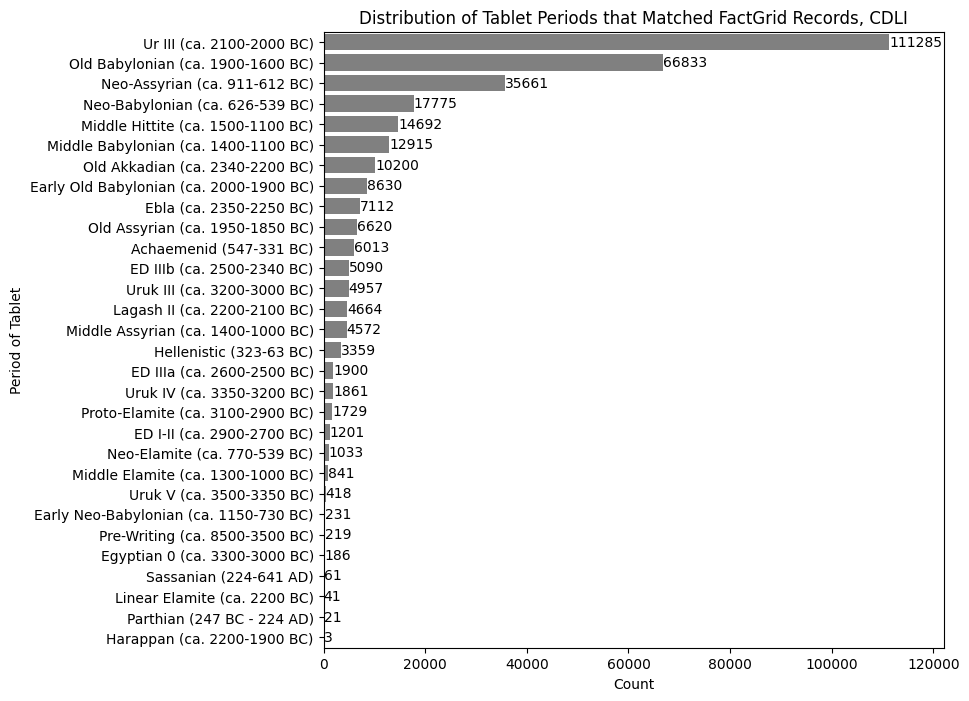

In [166]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(data = matched_period_counts, y = 'period', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 122000))
plt.xlabel('Count')
plt.ylabel('Period of Tablet')
plt.title('Distribution of Tablet Periods that Matched FactGrid Records, CDLI');

##### Distribution of matched tablets over time

In [167]:
start_year_of_period = []

for i in range(matched_period_counts.shape[0]):
  current_period = matched_period_counts.loc[i, 'period']
  # only take what's between ()
  year_range = re.search('\(([^\)]+)\)', string = current_period).group(1)
  # remove 'ca.' and space to prepare for string manipulation
  year_range = year_range.replace('ca. ', '').replace(' ', '')

  if 'BC' in year_range:
    if '-' not in year_range: # i.e., this is not a range
      start_year = year_range.split('BC')[0]
    elif 'AD' in year_range: # i.e., this range crosses AD and BC
      start_year = year_range.split('BC')[0]
    else: #i.e., this is a normal range within BC
      start_year = year_range.split('-')[0]
    # since this is a BC year, make it negative
    start_year = -abs(int(start_year))

  else: #'AD' only years
    if '-' not in year_range: # i.e., this is not a range
      start_year = year_range.split('AD')[0]
    else:
      start_year = year_range.split('-')[0]
  start_year = int(start_year)

  start_year_of_period += [start_year]

matched_period_counts['start_year_of_period'] = start_year_of_period
# order the df by start_year_of_period
matched_period_counts = matched_period_counts.sort_values('start_year_of_period', ascending = True)

matched_period_counts

,period,count,start_year_of_period
24,Pre-Writing (ca. 8500-3500 BC),219,-8500
22,Uruk V (ca. 3500-3350 BC),418,-3500
17,Uruk IV (ca. 3350-3200 BC),1861,-3350
25,Egyptian 0 (ca. 3300-3000 BC),186,-3300
12,Uruk III (ca. 3200-3000 BC),4957,-3200
18,Proto-Elamite (ca. 3100-2900 BC),1729,-3100
19,ED I-II (ca. 2900-2700 BC),1201,-2900
16,ED IIIa (ca. 2600-2500 BC),1900,-2600
11,ED IIIb (ca. 2500-2340 BC),5090,-2500
8,Ebla (ca. 2350-2250 BC),7112,-2350


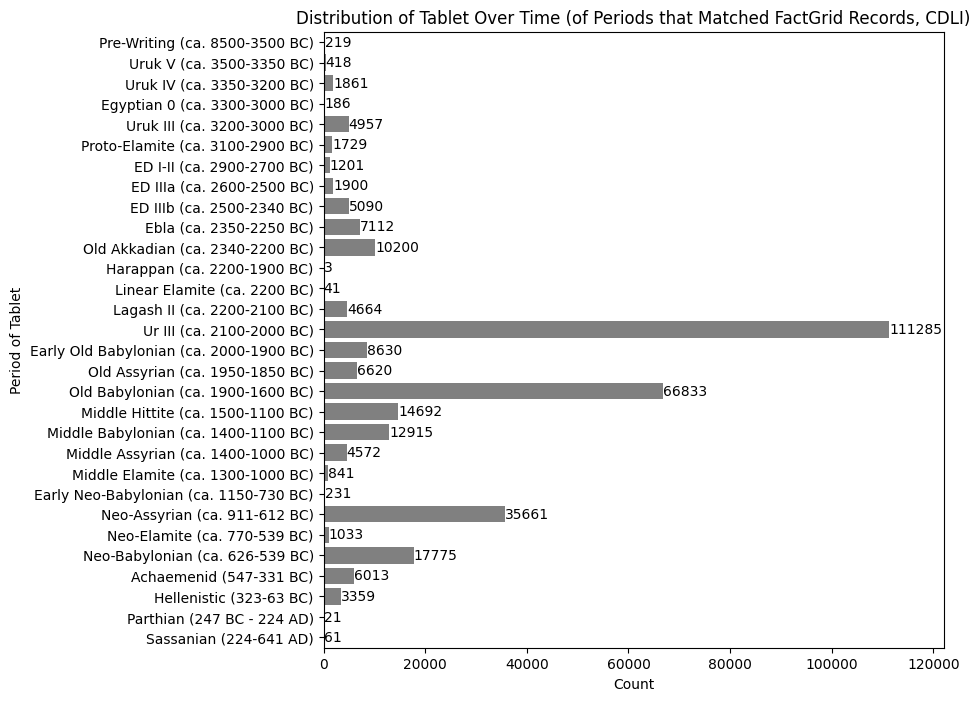

In [168]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(data = matched_period_counts, y = 'period', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 122000))
plt.xlabel('Count')
plt.ylabel('Period of Tablet')
plt.title('Distribution of Tablet Over Time (of Periods that Matched FactGrid Records, CDLI)');

##### Distribution of Unmatched Periods

In [169]:
period_df.iloc[no_match_indices_period].groupby('cdli_dump_period')['cdli_dump_period'].count()

cdli_dump_period
1200-700 BC                                                               1
Achaemenid?                                                               4
Early Dynastic IIIA (c. 2700-2500 BC)                                     1
Early Old Babylonian (ca. 1900-1600 BC)                                   1
Middle Babylonian (ca. 1400-1100 BC))                                     1
Old Elamite (ca. 2700-1500 BC)                                            1
Uruk III (ca. 3200-3000 BC) - Early Dynastic I-II (ca. 2900-2700 BC)      1
copy (modern)                                                             1
fake (ancient) ?                                                          1
fake (modern)                                                           114
fake (modern) ?                                                          69
modern                                                                    5
modern?                                                                

In [170]:
unmatched_periods = period_df.iloc[no_match_indices_period]['cdli_dump_period']
unmatched_periods_clean = []

for p in unmatched_periods:
  p = str(p)
  if 'modern' in p:
    unmatched_periods_clean += ['modern']

  # we only consider the non-empty ones
  elif (p != '') & (p != '-'):
    # remove the unceratinty marks
    p = p.replace('?', '').rstrip()

    # make sure that all multiple entries are separated by ;
    p = p.replace(',', ';')

    # split a multi-period statement, if yes
    lst = p.split('; ')

    unmatched_periods_clean += lst

# remove the space attached to some entries which are resulted from splitting by ;
unmatched_periods_clean = [x.rstrip() for x in unmatched_periods_clean]


pd.unique(pd.Series(unmatched_periods_clean))

array(['uncertain', 'nan', 'modern', 'fake (ancient)',
       'Old Elamite (ca. 2700-1500 BC)', 'Achaemenid',
       'Early Old Babylonian (ca. 1900-1600 BC)',
       'Early Dynastic IIIA (c. 2700-2500 BC)',
       'Uruk III (ca. 3200-3000 BC) - Early Dynastic I-II (ca. 2900-2700 BC)',
       '1200-700 BC', 'Middle Babylonian (ca. 1400-1100 BC))'],
      dtype=object)

In [171]:
# get the frequencies of elements in the list
d = collections.Counter(unmatched_periods_clean)

# turn the langs and their counts into a dataframe
unmatched_p_df = pd.DataFrame.from_dict(d, orient = 'index').\
reset_index().\
rename(columns = {'index': 'period', 0: 'count'}).\
sort_values(by = 'count', ascending = False).\
reset_index().\
drop(columns = 'index')

unmatched_p_df

,period,count
0,nan,35743
1,uncertain,847
2,modern,192
3,Achaemenid,4
4,fake (ancient),1
5,Old Elamite (ca. 2700-1500 BC),1
6,Early Old Babylonian (ca. 1900-1600 BC),1
7,Early Dynastic IIIA (c. 2700-2500 BC),1
8,Uruk III (ca. 3200-3000 BC) - Early Dynastic I...,1
9,1200-700 BC,1


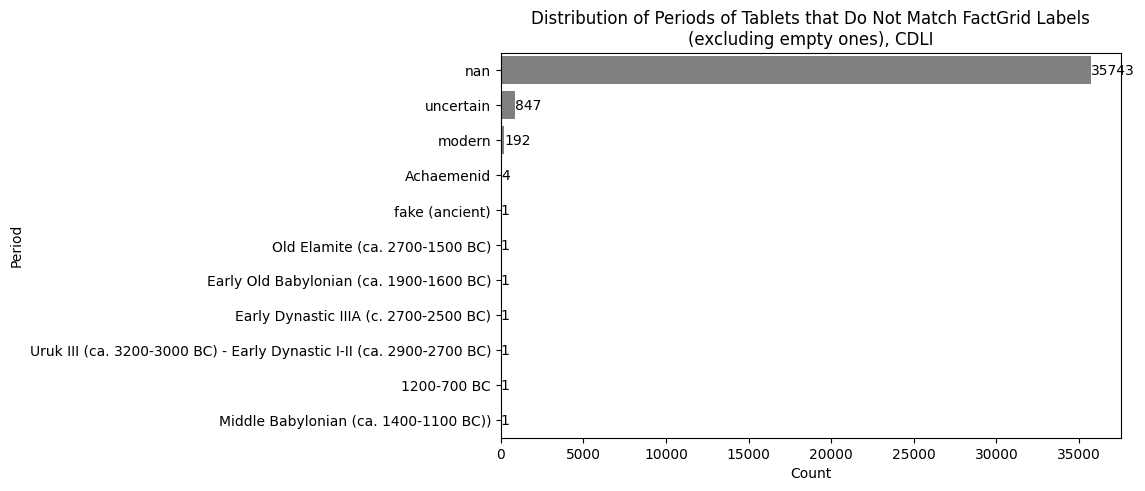

In [172]:
plt.figure(figsize = (8, 5))
sns.barplot(data = unmatched_p_df, y = 'period', x = 'count',
            color = 'grey')
ax = sns.barplot(data = unmatched_p_df, y = 'period', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlabel('Count')
plt.ylabel('Period')
plt.title('Distribution of Periods of Tablets that Do Not Match FactGrid Labels\n(excluding empty ones), CDLI');

### 7.3 ORACC Periods

####7.3.1 Match on the ORACC 'period' label to obtain the FactGrid Q-id.

 Make a data frame, called `period_df`, for all matches.
* if there's a question mark in the CDLI for period, you can use the same method as the `language_df` above, by adding the following column:

| id_text | period | [(P155)](https://database.factgrid.de/wiki/Property:P155)|
| -- | ------- | ------ |
|  'id_text' in cdli_cat.csv |'period' in cdli_cat.csv | [Q22757](https://database.factgrid.de/wiki/Item:Q22757)|

Make a separate data from of the texts which were not matched: `no_period_df`.

In [173]:
period_df2 = metacatalogue[['id_text', 'period_y']]
period_df2 = period_df2.rename(columns = {'period_y': 'oracc_dump_period'})
period_df2['oracc_dump_period'].unique()

array(['Uruk III', 'Uruk IV', 'ED I-II', nan, 'Early Dynastic IIIa',
       'Early Dynastic I-II', 'Early Dynastic', 'ED IIIa',
       'Old Babylonian', 'Early Dynastic IIIb', 'Ur III', 'Old Akkadian',
       'ED IIIb', 'Lagash II', 'Early Old Babylonian', 'Lagaš II',
       'Achaemenid', 'Neo-Babylonian', 'Middle Babylonian',
       'Old Akkadian; Early Dynastic or Old Akkadian', 'Middle Assyrian',
       'Old Akkadian; Ur III', 'Early Dynastic; Old Akkadian', 'Ebla',
       'Neo-Assyrian', 'First Millennium', 'Hellenistic',
       'Ur III; Old Akkadian', 'Early Dynastic; Ur III', 'uncertain',
       'fake', 'Neo/Late Babylonian', 'Seleucid', 'Uncertain',
       'Old Assyrian', 'unclear', 'Standard Babylonian', 'Middle Hittite',
       'Pre-Uruk V', 'Late Babylonian', 'Pre-Writing', 'Hittite',
       'Late Middle Assyrian or early Neo-Assyrian', 'Mitanni',
       'Parthian', 'Archaic', 'Early Dynastic or Old Akkadian',
       'Late Antique', 'ED IIIa; Old Babylonian',
       'Urartian

Typically, we need to clean this first, but the period data looks pretty neat after manual inspection so we will skip for now. We dealt with some special cases according to this csv file: [link](https://docs.google.com/spreadsheets/d/1ttueqlFrtNE4eaZDdDq80Ksc4Wg8pwxXeS8eCiiHjmQ/edit#gid=714968975).

In [174]:
period2 = []
period_qid2 = []
period_wikidata_URI2 = []
P155_period2 = [] # when there's a question mark
other_possible_period2 = [] # when there are multiple estimations of period
no_match_indices_period2 = [] # index of the row if there's no match


for index in range(len(period_df2['oracc_dump_period'])):
  p = period_df2['oracc_dump_period'][index]
  # split every entry by ;
  lst = str(p).replace(',', ';').replace('or', ';').split(';')

  # get the first estimated period
  first_p = lst[0].rstrip()

  # store the remaining estimations (if exist) away
  other_possible_period2 += [', '.join(lst[1:])]

  # check for uncertainty
  if '?' in first_p:
    P155_period2 += ['Q22757']
    first_p = first_p.replace('?', '').rstrip()
  else:
    P155_period2 += ['']


  # add in qid and label for the first_p

  # deal with some typo first
  if (first_p == 'Neo-Babylonian (626-539 BC)')|(first_p == 'Neo-Babylonian (ca. 626-539 BC).'):
    first_p = 'Neo-Babylonian (ca. 626-539 BC)'
  elif first_p == 'Achaemenid (547–331 BC)':
    first_p = 'Achaemenid (547-331 BC)'
  elif first_p == 'Old Babylonian':
    first_p = 'Old Babylonian (ca. 1900-1600 BC)'
  elif 'Parthian' in first_p:
    first_p = 'Parthian (247 BC - 224 AD)'
  elif 'Pre-Uruk V' in first_p:
    first_p = 'Pre-Writing (ca. 8500-3500 BC)'
    other_possible_period2[-1] = ['Uruk V (ca. 3500-3350 BC)',
                                 'Uruk IV (ca. 3350-3200 BC)',
                                 'Early Dynastic Period of Egypt']

  # if the period has a QID in FactGrid
  if first_p in period_reference['cdli_period'].unique():
    # record the period
    period2 += [first_p]
    # get the corresponding QID (FG_item) and Wikidata_URI
    i = period_reference['cdli_period'].tolist().index(first_p)
    period_qid2 += [period_reference['FG_qid'][i]]
    period_wikidata_URI2 += [period_reference['Wikidata_URI'][i]]

  # if the period does not have a FactGrid QID, put '' for everything for now
  else:
    period2 += ['']
    period_qid2 += ['']
    period_wikidata_URI2 += ['']
    no_match_indices_period2 += [index]


# append these columns to the dataframe
period_df2['period'] = period2
period_df2['period_qid'] = period_qid2
period_df2['period_wikidata_URI'] = period_wikidata_URI2
period_df2['P155_period'] = P155_period2
period_df2['other_possible_period'] = other_possible_period2

# update the names of columns to be clearer
period_df2 = period_df2.rename(columns={'oracc_period': 'oracc_dump_period'})

period_df2

,id_text,oracc_dump_period,period,period_qid,period_wikidata_URI,P155_period,other_possible_period
0,P000001,Uruk III,,,,,
1,P000002,Uruk III,,,,,
2,P000003,Uruk IV,,,,,
3,P000004,Uruk IV,,,,,
4,P000005,Uruk IV,,,,,
...,...,...,...,...,...,...,...
366911,X096677,Unknown,,,,,
366912,X201001,Unknown,,,,,
366913,X201002,Unknown,,,,,
366914,X225104,Unknown,,,,,


#### 7.2.2 matched_period_df

In [175]:
matched_period_df2 = period_df2[~period_df2.index.isin(no_match_indices_period2)].reset_index(drop = True)
matched_period_df2 = matched_period_df2.rename(columns={'id_text': 'oracc_dump_id'})
matched_period_df2

,oracc_dump_id,oracc_dump_period,period,period_qid,period_wikidata_URI,P155_period,other_possible_period
0,P010733,Old Babylonian,Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,
1,P101741,Old Babylonian,Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,
2,P142806,Old Babylonian,Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,
3,P102551,Old Babylonian,Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,
4,P102659,Old Babylonian,Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,
...,...,...,...,...,...,...,...
16647,X130506,Old Babylonian,Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,
16648,X130507,Old Babylonian,Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,
16649,X130519,Old Babylonian,Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,
16650,Q002229,Old Babylonian,Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,


In [176]:
matched_period_df2.shape

(16652, 7)

#### 7.2.3 no_match_period_df

In [177]:
no_match_period_df2 = metacatalogue.iloc[no_match_indices_period2]
no_match_period_df2.head()

,composite_id_x,id_text2,id_text,language_x,object_type_x,period_x,material_x,collection_x,museum_no_x,provenience_x,excavation_no_x,findspot_square_x,date_of_origin_x,dates_referenced_x,genre_x,subgenre_x,translation_source_x,id,language_y,material_y,object_type_y,period_y,provenience_y,excavation_no_y,findspot_square_y,dates_referenced_y,genre_y,subgenre_y,translation_source_y,archive,collection_y,museum-nos,mus_no,museum_no_y,cdli_museum_no,saa_cdli_museum,Mus_no,museum_number,museum,museum_URL,date_of_origin_y,dialect,date,supergenre,xproject,q_number,ancient_year,date_bce,cdli_id,OBJ_type,Period_culture,Script_type_1,Genre,Subgenre,S_s_genre,Language,Full_no,Tablet_number,Q_no,object,composite_id_y,project name,id_text_int,seal_id,cdli_composite_id,ancient_date,bdtns_id
0,Q000002,0.0,P000001,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 01533,Uruk (mod. Warka),"W 06435,a","M XVIII,?",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation,NaN,undetermined,clay,tablet,Uruk III,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
1,Q000002,0.0,P000002,undetermined,tablet,Uruk III (ca. 3200-3000 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15263,Uruk (mod. Warka),"W 06435,b","M XVIII,?",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation,NaN,undetermined,clay,tablet,Uruk III,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
2,NaN,0.0,P000003,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15253,Uruk (mod. Warka),"W 09123,d","Qa XVI,2",NaN,NaN,Lexical,Archaic Vocabulary (witness),no translation,NaN,undetermined,clay,tablet,Uruk IV,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
3,Q000002,0.0,P000004,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15168,Uruk (mod. Warka),"W 09169,d","Qa XVI,2",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation,NaN,undetermined,clay,tablet,Uruk IV,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN
4,Q000002,0.0,P000005,undetermined,tablet,Uruk IV (ca. 3350-3200 BC),clay,"Vorderasiatisches Museum, Berlin, Germany",VAT 15153,Uruk (mod. Warka),"W 09206,k","Qa XVI,2",00.00.00.00,00.00.00.00,Lexical,Archaic Lu2 A (witness),no translation,NaN,undetermined,clay,tablet,Uruk IV,Warka (Uruk),NaN,NaN,NaN,Lexical,NaN,NaN,NaN,"Vorderasiatisches Museum, Berlin, Germany",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEX,CDLI,NaN,NaN,NaN,P000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,armep,NaN,NaN,NaN,NaN,NaN


In [178]:
no_match_period_df2.shape

(350264, 67)

In [179]:
matched_period_df2.shape[0] + no_match_period_df2.shape[0] == metacatalogue.shape[0]

True

#### Visualization

##### Distribution of matched periods

In [180]:
matched_period_counts2 = pd.DataFrame(matched_period_df2.groupby('period')['period'].count())
matched_period_counts2.index.name = None
matched_period_counts2 = matched_period_counts2.reset_index().rename(
    columns = {'index': 'period',
               'period': 'count'}
    ).sort_values(by = 'count', ascending = False).reset_index(drop = True)
matched_period_counts2

,period,count
0,Old Babylonian (ca. 1900-1600 BC),16363
1,Late Babylonian,170
2,Parthian (247 BC - 224 AD),118
3,Pre-Writing (ca. 8500-3500 BC),1


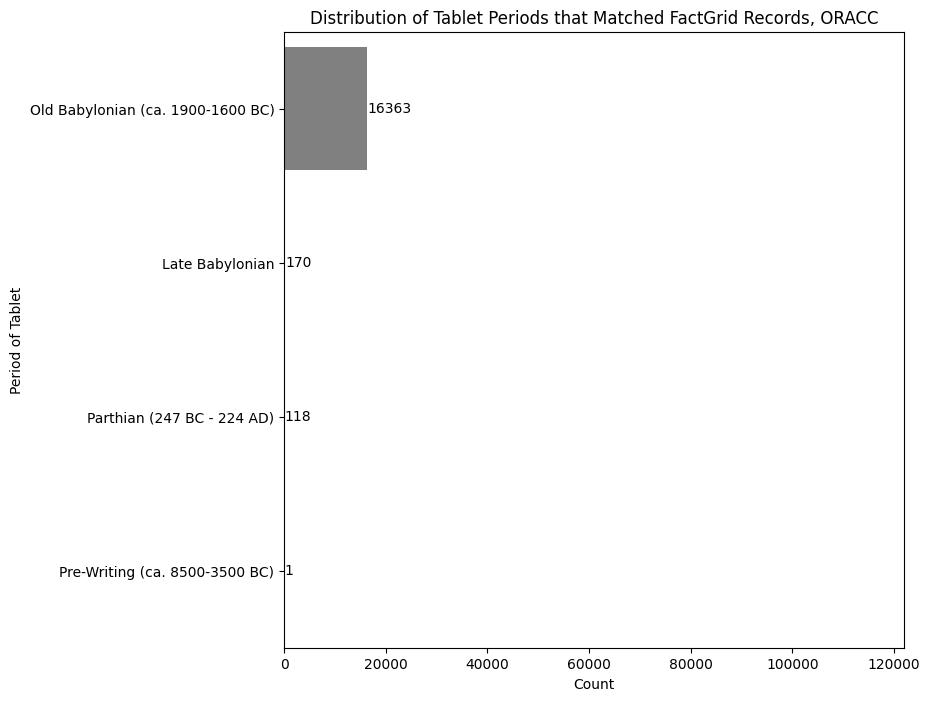

In [181]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(data = matched_period_counts2, y = 'period', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 122000))
plt.xlabel('Count')
plt.ylabel('Period of Tablet')
plt.title('Distribution of Tablet Periods that Matched FactGrid Records, ORACC');

##### Distribution of matched tablets over time

In [182]:
start_year_of_period2 = []

for i in range(matched_period_counts2.shape[0]):
  current_period = matched_period_counts2.loc[i, 'period']
  # only take what's between ()
  if re.search('\(([^\)]+)\)', string = current_period) != None:
    year_range = re.search('\(([^\)]+)\)', string = current_period).group(1)
  # remove 'ca.' and space to prepare for string manipulation
  year_range = year_range.replace('ca. ', '').replace(' ', '')

  if 'BC' in year_range:
    if '-' not in year_range: # i.e., this is not a range
      start_year = year_range.split('BC')[0]
    elif 'AD' in year_range: # i.e., this range crosses AD and BC
      start_year = year_range.split('BC')[0]
    else: #i.e., this is a normal range within BC
      start_year = year_range.split('-')[0]
    # since this is a BC year, make it negative
    start_year = -abs(int(start_year))

  else: #'AD' only years
    if '-' not in year_range: # i.e., this is not a range
      start_year = year_range.split('AD')[0]
    else:
      start_year = year_range.split('-')[0]
  start_year = int(start_year)

  start_year_of_period2 += [start_year]

matched_period_counts2['start_year_of_period'] = start_year_of_period2
# order the df by start_year_of_period
matched_period_counts2 = matched_period_counts2.sort_values('start_year_of_period', ascending = True)

matched_period_counts2

,period,count,start_year_of_period
3,Pre-Writing (ca. 8500-3500 BC),1,-8500
0,Old Babylonian (ca. 1900-1600 BC),16363,-1900
1,Late Babylonian,170,-1900
2,Parthian (247 BC - 224 AD),118,-247


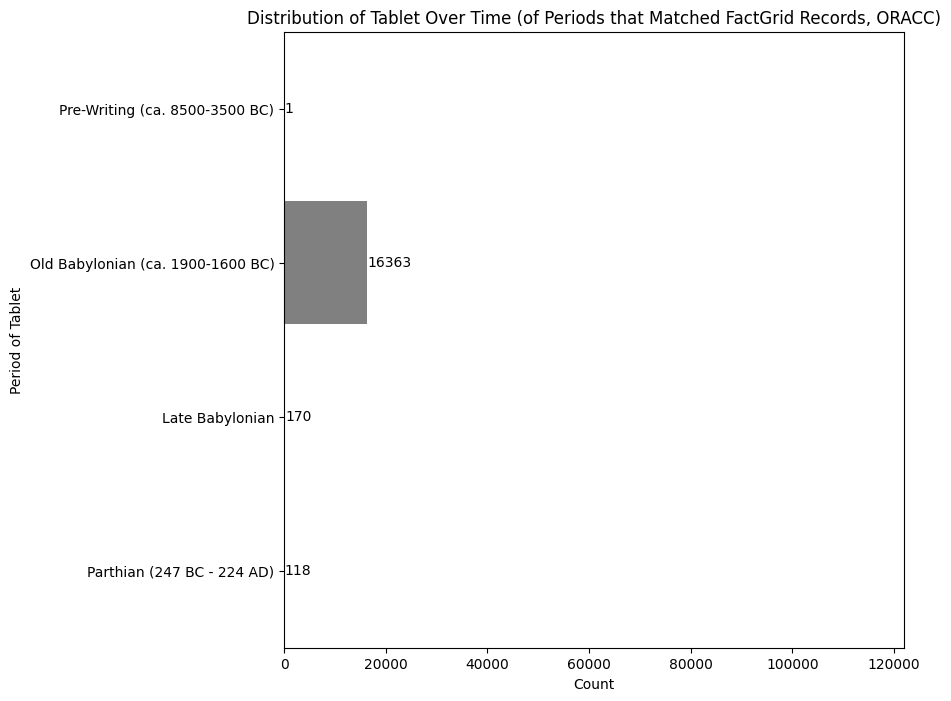

In [183]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(data = matched_period_counts2, y = 'period', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlim((0, 122000))
plt.xlabel('Count')
plt.ylabel('Period of Tablet')
plt.title('Distribution of Tablet Over Time (of Periods that Matched FactGrid Records, ORACC)');

##### Distribution of Unmatched Periods

In [184]:
period_df2.iloc[no_match_indices_period2].groupby('oracc_dump_period')['oracc_dump_period'].count()

oracc_dump_period
Achaemenid                                        855
Archaic                                            14
ED I-II                                             9
ED IIIa                                           318
ED IIIa; Old Babylonian                             1
ED IIIb                                           210
Early Dynastic                                   1188
Early Dynastic I-II                                87
Early Dynastic IIIa                               826
Early Dynastic IIIb                              3457
Early Dynastic or Old Akkadian                      1
Early Dynastic or Ur III                            1
Early Dynastic; Old Akkadian                        2
Early Dynastic; Ur III                              1
Early Old Babylonian                             2699
Ebla                                              220
First Millennium                                  792
Hellenistic                                      1013
Hittite   

In [185]:
unmatched_periods2 = period_df2.iloc[no_match_indices_period2]['oracc_dump_period']
unmatched_periods_clean2 = []

for p in unmatched_periods:
  p = str(p)
  if 'modern' in p:
    unmatched_periods_clean += ['modern']

  # we only consider the non-empty ones
  elif (p != '') & (p != '-'):
    # remove the unceratinty marks
    p = p.replace('?', '').rstrip()

    # make sure that all multiple entries are separated by ;
    p = p.replace(',', ';')

    # split a multi-period statement, if yes
    lst = p.split('; ')

    unmatched_periods_clean2 += lst

# remove the space attached to some entries which are resulted from splitting by ;
unmatched_periods_clean2 = [x.rstrip() for x in unmatched_periods_clean2]


pd.unique(pd.Series(unmatched_periods_clean2))

array(['uncertain', 'nan', 'fake (ancient)',
       'Old Elamite (ca. 2700-1500 BC)', 'Achaemenid',
       'Early Old Babylonian (ca. 1900-1600 BC)',
       'Early Dynastic IIIA (c. 2700-2500 BC)',
       'Uruk III (ca. 3200-3000 BC) - Early Dynastic I-II (ca. 2900-2700 BC)',
       '1200-700 BC', 'Middle Babylonian (ca. 1400-1100 BC))'],
      dtype=object)

In [186]:
# get the frequencies of elements in the list
d2 = collections.Counter(unmatched_periods_clean2)

# turn the langs and their counts into a dataframe
unmatched_p_df2 = pd.DataFrame.from_dict(d2, orient = 'index').\
reset_index().\
rename(columns = {'index': 'period', 0: 'count'}).\
sort_values(by = 'count', ascending = False).\
reset_index().\
drop(columns = 'index')

unmatched_p_df2

,period,count
0,nan,35743
1,uncertain,847
2,Achaemenid,4
3,fake (ancient),1
4,Old Elamite (ca. 2700-1500 BC),1
5,Early Old Babylonian (ca. 1900-1600 BC),1
6,Early Dynastic IIIA (c. 2700-2500 BC),1
7,Uruk III (ca. 3200-3000 BC) - Early Dynastic I...,1
8,1200-700 BC,1
9,Middle Babylonian (ca. 1400-1100 BC)),1


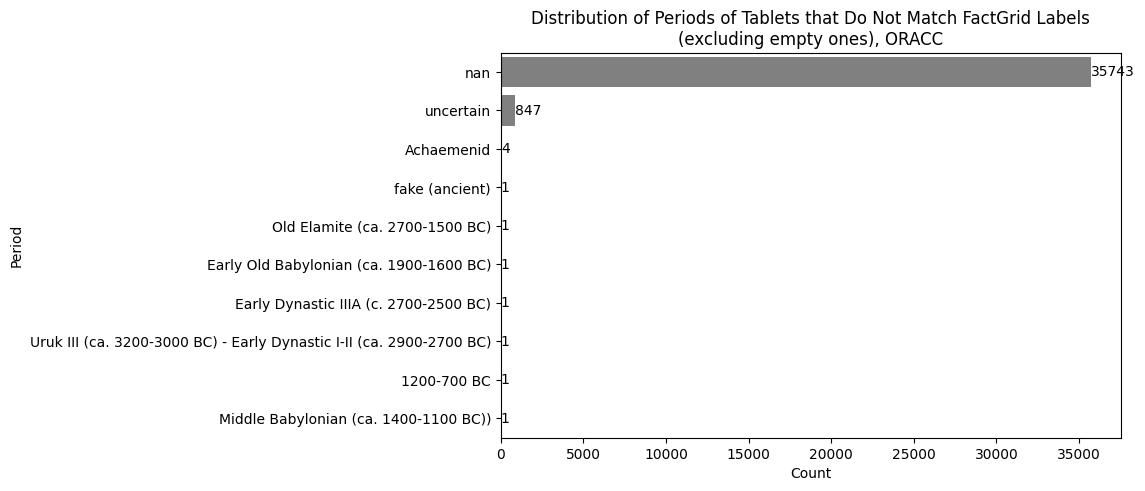

In [187]:
plt.figure(figsize = (8, 5))
sns.barplot(data = unmatched_p_df2, y = 'period', x = 'count',
            color = 'grey')
ax = sns.barplot(data = unmatched_p_df2, y = 'period', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlabel('Count')
plt.ylabel('Period')
plt.title('Distribution of Periods of Tablets that Do Not Match FactGrid Labels\n(excluding empty ones), ORACC');

#### Merging period dfs of CDLI and ORACC

In [188]:
periods_df = pd.merge(period_df, period_df2, on = 'id_text', how = 'outer')
final_periods_df = periods_df[['id_text','period_x','period_y','period_qid_x','period_qid_y','period_wikidata_URI_x','period_wikidata_URI_y','P155_period_x','P155_period_y','other_possible_period_x','other_possible_period_y']]
final_periods_df

,id_text,period_x,period_y,period_qid_x,period_qid_y,period_wikidata_URI_x,period_wikidata_URI_y,P155_period_x,P155_period_y,other_possible_period_x,other_possible_period_y
0,P000001,Uruk III (ca. 3200-3000 BC),,Q512134,,Q114877803,,,,,
1,P000002,Uruk III (ca. 3200-3000 BC),,Q512134,,Q114877803,,,,,
2,P000003,Uruk IV (ca. 3350-3200 BC),,Q512132,,Q114877809,,,,,
3,P000004,Uruk IV (ca. 3350-3200 BC),,Q512132,,Q114877809,,,,,
4,P000005,Uruk IV (ca. 3350-3200 BC),,Q512132,,Q114877809,,,,,
...,...,...,...,...,...,...,...,...,...,...,...
366911,X096677,,,,,,,,,,
366912,X201001,,,,,,,,,,
366913,X201002,,,,,,,,,,
366914,X225104,,,,,,,,,,


#Preparing for Statements
Merging all final merged dfs, merge column values if same, title with QID.

CDLI = Q393513, ORACC = Q425152, header 'qal131'

merge all of the final dataframes into one big dataframe as raw information

In [ ]:
all_merged = metacatalogue['id_text']
dfs = [final_languages_df, final_materials_df, final_collections_df, final_proveniences_df, final_objects_df, final_genres_df, final_periods_df]
for i in range(len(dfs)):
  all_merged = pd.merge(all_merged, dfs[i], on = 'id_text', how = 'outer')

In [ ]:
all_merged

,id_text,first_lang_x,first_lang_y,first_lang_qid_x,first_lang_qid_y,first_lang_parent_x,first_lang_parent_y,P155_lang_x,P155_lang_y,other_lang_x,other_lang_y,material_x,material_y,first_mat_x,first_mat_y,first_mat_label_x,first_mat_label_y,first_mat_qid_x,first_mat_qid_y,P155_mat_x,P155_mat_y,other_mat_x,other_mat_y,collection_x,collection_y,collection_qid_x,collection_qid_y,collection_wikidata_id_x,collection_wikidata_id_y,collection_name_x,collection_name_y,collection_name_native_x,collection_name_native_y,collection_url_x,collection_url_y,wiki_url_eng_x,wiki_url_eng_y,wiki_url_native_x,wiki_url_native_y,P155_collection_x,P155_collection_y,other_collection_x,other_collection_y,id_text2,provenience_x,provenience_y,excavation_no_x,excavation_no_y,findspot_square_x,findspot_square_y,provenience,ancientplace,Len,_merge,object_type_x,object_type_y,FG_qid_x,FG_qid_y,FG_Label_x,FG_Label_y,genre_x,genre_y,genre_qid_x,genre_qid_y,genre_current_count_x,genre_current_count_y,P155_genre_x,P155_genre_y,other_genre_x,other_genre_y,period_x,period_y,period_qid_x,period_qid_y,period_wikidata_URI_x,period_wikidata_URI_y,P155_period_x,P155_period_y,other_possible_period_x,other_possible_period_y
0,P000001,,,,,,,,,,,clay,clay,clay,clay,clay,clay,Q471153,Q471153,,,,,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q510658,Q542084,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,,,,0.0,Uruk (mod. Warka),Warka (Uruk),"W 06435,a",NaN,"M XVIII,?",NaN,NaN,NaN,NaN,left_only,tablet,tablet,Q512006,Q512006,Clay tablet,Clay tablet,Lexical,Lexical,Q537054,Q537054,8273,8273,,,,,Uruk III (ca. 3200-3000 BC),,Q512134,,Q114877803,,,,,
1,P000002,,,,,,,,,,,clay,clay,clay,clay,clay,clay,Q471153,Q471153,,,,,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q510658,Q542084,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,,,,0.0,Uruk (mod. Warka),Warka (Uruk),"W 06435,b",NaN,"M XVIII,?",NaN,NaN,NaN,NaN,left_only,tablet,tablet,Q512006,Q512006,Clay tablet,Clay tablet,Lexical,Lexical,Q537054,Q537054,8273,8273,,,,,Uruk III (ca. 3200-3000 BC),,Q512134,,Q114877803,,,,,
2,P000003,,,,,,,,,,,clay,clay,clay,clay,clay,clay,Q471153,Q471153,,,,,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q510658,Q542084,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,,,,0.0,Uruk (mod. Warka),Warka (Uruk),"W 09123,d",NaN,"Qa XVI,2",NaN,NaN,NaN,NaN,left_only,tablet,tablet,Q512006,Q512006,Clay tablet,Clay tablet,Lexical,Lexical,Q537054,Q537054,8273,8273,,,,,Uruk IV (ca. 3350-3200 BC),,Q512132,,Q114877809,,,,,
3,P000004,,,,,,,,,,,clay,clay,clay,clay,clay,clay,Q471153,Q471153,,,,,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q510658,Q542084,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,h

## CDLI and Qualifier is ORACC
CDLI will always be the identifier and ORACC will always be the qualifier value

In [ ]:
p18q = []   #languages
p401q = []  #materials
p329q = []  #museum/collection
p695q = []  #provenience, P804 for excavation_no and P425 for findspot_square qualifiers
p804q = []    #excavation_no
p425q = []    #findspot_square
p2q = []    #object_type
p608q = []  #genre
p853q =[]   #period


for i in range(all_merged.shape[0]):
  #LANGUAGE
  if all_merged['first_lang_qid_x'][i] == all_merged['first_lang_qid_y'][i]:  #if the languages for cdli and oracc are the same
    p18q.append('')                                                           #set the qualifier for that text to nothing [nothing to differentiate]
  else:                                                                       #if they are different
    p18q.append(all_merged['first_lang_qid_y'][i])                            #set qualifier to the oracc identification

  #MATERIAL
  if all_merged['first_mat_qid_x'][i] == all_merged['first_mat_qid_y'][i]:
    p401q.append('')
  else:
    p401q.append(all_merged['first_mat_qid_y'][i])

  #COLLECTION
  if all_merged['collection_qid_x'][i] == all_merged['collection_qid_y'][i]:
    p329q.append('')
  else:
    p329q.append(all_merged['collection_qid_y'][i])

  #PROVENIENCE
  if all_merged['provenience_x'][i] == all_merged['provenience_y'][i]:
    p695q.append('')
  else:
    p695q.append(all_merged['provenience_y'][i])

  if all_merged['excavation_no_x'][i] == all_merged['excavation_no_y'][i]:
    p804q.append('')
  else:
    p804q.append(all_merged['excavation_no_y'][i])

  if all_merged['findspot_square_x'][i] == all_merged['findspot_square_y'][i]:
    p425q.append('')
  else:
    p425q.append(all_merged['findspot_square_y'][i])

  #OBJECT TYPE
  if all_merged['FG_qid_x'][i] == all_merged['FG_qid_y'][i]:
    p2q.append('')
  else:
    p2q.append(all_merged['FG_qid_y'][i])

  #GENRE
  if all_merged['genre_qid_x'][i] == all_merged['genre_qid_y'][i]:
    p608q.append('')
  else:
    p608q.append(all_merged['genre_qid_y'][i])

  #PERIOD
  if all_merged['period_qid_x'][i] == all_merged['period_qid_y'][i]:
    p853q.append('')
  else:
    p853q.append(all_merged['period_qid_y'][i])

In [ ]:
tester_export = pd.DataFrame({'qid': np.empty(all_merged.shape[0]),
                         'P18':all_merged['first_lang_qid_x'], 'qal131_18': p18q,
                         'P401':all_merged['first_mat_qid_x'], 'qal131_401': p401q,
                         'P329':all_merged['collection_qid_x'], 'qal131_329': p329q,
                         'P695':all_merged['provenience_x'], 'qal131_695':p695q,
                         'P804':all_merged['excavation_no_x'],'qal131_804':p804q,
                         'P425':all_merged['findspot_square_x'],'qal131_425':p425q,
                         'P2':all_merged['FG_qid_x'], 'qal131_2': p2q,
                         'P608':all_merged['genre_qid_x'], 'qal131_608': p608q,
                         'P853':all_merged['period_qid_x'], 'qal131_853': p853q
                         })
tester_export

,qid,P18,qal131_18,P401,qal131_401,P329,qal131_329,P695,qal131_695,P804,qal131_804,P425,qal131_425,P2,qal131_2,P608,qal131_608,P853,qal131_853
0,4.995110e-310,,,Q471153,,Q510658,,Uruk (mod. Warka),Warka (Uruk),"W 06435,a",NaN,"M XVIII,?",NaN,Q512006,,Q537054,,Q512134,
1,4.995106e-310,,,Q471153,,Q510658,,Uruk (mod. Warka),Warka (Uruk),"W 06435,b",NaN,"M XVIII,?",NaN,Q512006,,Q537054,,Q512134,
2,4.995110e-310,,,Q471153,,Q510658,,Uruk (mod. Warka),Warka (Uruk),"W 09123,d",NaN,"Qa XVI,2",NaN,Q512006,,Q537054,,Q512132,
3,4.995106e-310,,,Q471153,,Q510658,,Uruk (mod. Warka),Warka (Uruk),"W 09169,d",NaN,"Qa XVI,2",NaN,Q512006,,Q537054,,Q512132,
4,6.602449e-310,,,Q471153,,Q510658,,Uruk (mod. Warka),Warka (Uruk),"W 09206,k",NaN,"Qa XVI,2",NaN,Q512006,,Q537054,,Q512132,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4520278,2.233314e-317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4520279,2.233315e-317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4520280,2.233315e-317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4520281,2.233316e-317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
all_merged.to_csv(folder+'ORACC_DFS/all_merged.csv')
tester_export.to_csv(folder + 'ORACC_DFS/tester_export.csv')

# Prepare for __FactGrid__ QuickStatement batch processing

Once the `all_merged` df is properly joined together, the last step before we export the resulting CSV is to include the FactGrid statements into the data frame, which we will call `factgrid_df`.

Most of this process is straightforward, but the one statement we need to create is a __description__ for each object.

###1 To do so we will use a couple of the cleaned up fields from `all_merged` df above and add a new field with header 'Den' which will join three existing columns together to form a descriptive sentence.

In [ ]:
#import all_merged as den_df
den_df = pd.read_csv(folder + '/ORACC_DFS/all_merged.csv', low_memory=False, index_col=0)

In [ ]:
#fill null values with ''
den_df.fillna('', inplace = True)
den_df

,id_text,first_lang_x,first_lang_y,first_lang_qid_x,first_lang_qid_y,first_lang_parent_x,first_lang_parent_y,P155_lang_x,P155_lang_y,other_lang_x,other_lang_y,material_x,material_y,first_mat_x,first_mat_y,first_mat_label_x,first_mat_label_y,first_mat_qid_x,first_mat_qid_y,P155_mat_x,P155_mat_y,other_mat_x,other_mat_y,collection_x,collection_y,collection_qid_x,collection_qid_y,collection_wikidata_id_x,collection_wikidata_id_y,collection_name_x,collection_name_y,collection_name_native_x,collection_name_native_y,collection_url_x,collection_url_y,wiki_url_eng_x,wiki_url_eng_y,wiki_url_native_x,wiki_url_native_y,P155_collection_x,P155_collection_y,other_collection_x,other_collection_y,id_text2,provenience_x,provenience_y,excavation_no_x,excavation_no_y,findspot_square_x,findspot_square_y,provenience,ancientplace,Len,_merge,object_type_x,object_type_y,FG_qid_x,FG_qid_y,FG_Label_x,FG_Label_y,genre_x,genre_y,genre_qid_x,genre_qid_y,genre_current_count_x,genre_current_count_y,P155_genre_x,P155_genre_y,other_genre_x,other_genre_y,period_x,period_y,period_qid_x,period_qid_y,period_wikidata_URI_x,period_wikidata_URI_y,P155_period_x,P155_period_y,other_possible_period_x,other_possible_period_y
0,P000001,,,,,,,,,,,clay,clay,clay,clay,clay,clay,Q471153,Q471153,,,,,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q510658,Q542084,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,,,,0.0,Uruk (mod. Warka),Warka (Uruk),"W 06435,a",,"M XVIII,?",,,,,left_only,tablet,tablet,Q512006,Q512006,Clay tablet,Clay tablet,Lexical,Lexical,Q537054,Q537054,8273,8273,,,,,Uruk III (ca. 3200-3000 BC),,Q512134,,Q114877803,,,,,
1,P000002,,,,,,,,,,,clay,clay,clay,clay,clay,clay,Q471153,Q471153,,,,,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q510658,Q542084,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,,,,0.0,Uruk (mod. Warka),Warka (Uruk),"W 06435,b",,"M XVIII,?",,,,,left_only,tablet,tablet,Q512006,Q512006,Clay tablet,Clay tablet,Lexical,Lexical,Q537054,Q537054,8273,8273,,,,,Uruk III (ca. 3200-3000 BC),,Q512134,,Q114877803,,,,,
2,P000003,,,,,,,,,,,clay,clay,clay,clay,clay,clay,Q471153,Q471153,,,,,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q510658,Q542084,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,,,,0.0,Uruk (mod. Warka),Warka (Uruk),"W 09123,d",,"Qa XVI,2",,,,,left_only,tablet,tablet,Q512006,Q512006,Clay tablet,Clay tablet,Lexical,Lexical,Q537054,Q537054,8273,8273,,,,,Uruk IV (ca. 3350-3200 BC),,Q512132,,Q114877809,,,,,
3,P000004,,,,,,,,,,,clay,clay,clay,clay,clay,clay,Q471153,Q471153,,,,,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q510658,Q542084,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo

###2 For each object with a 'cdli_id' + 'designation' we will make the description by joining the following fields:
 * 'lang' + ( and 'lang2') [if questionable, exclude 'lang']
 * 'genre' +
 * 'object' +
 * " from " +
 * 'provenience = Len' + (the CDLI 'provenience' field has many missing fields, so we will use the 'Len' field instead)
 * ", dated to " +
 * 'period' +
 * " and currently held in the" +
 * 'collection'



###3 The result should look something like this: __"Sumerian administrative tablet from Girsu, dated to Ur III (ca. 2100-2000 BC) and currently held in the British Museum, London, UK"__

In [ ]:
den = []

for i in range(den_df.shape[0]):

  d = ''

  ####### language ########

  # only includes lang if first_lang is not questionable
  if den_df.loc[i, 'P155_lang_x'] == '':
    first_l = den_df['first_lang_x'][i].capitalize()
    d = d + first_l

  # check if other language exists
  # note that this way of adding up is only feasible because there happens to be no multiple other languages in this batch
  if den_df.loc[i, 'other_lang_x'] != '':
    # split multiple other languages
    other_l_lst = den_df.loc[i, 'other_lang_x'].split(',')

    # if only one other language
    if len(other_l_lst) == 1:
      other_l = other_l_lst[0]
      if '?' in other_l:
        other_l = other_l.replace('?', '').rstrip().capitalize()
        d = d + ' and possibly ' + other_l
      else:
        d = d + ' and ' + other_l.capitalize()

    # if more than one other languages
    else:
      # for all but the last one
      for other_l in other_l_lst[0:(len(other_l_lst)-1)]:
        # remove spaces
        other_l = other_l.replace(' ', '')
        if '?' in other_l:
          other_l = other_l.replace('?', '').rstrip().capitalize()
          d = d + ', possibly ' + other_l
        else:
          d = d + ', ' + other_l.capitalize()
      # for the last one
      last_other_l = other_l_lst[-1]
      if '?' in last_other_l:
        last_other_l = last_other_l.replace('?', '').rstrip().capitalize()
        d = d + ', and possibly ' + last_other_l
      else:
        d = d + ', and ' + last_other_l.capitalize()


  ######## genre ########

  g = den_df.loc[i, 'genre_x'].lower()

  # if genre is questionable
  if den_df.loc[i, 'P155_genre_x'] != '':
    # if genre starts the sentence
    if d == '':
      d = d + g.capitalize() + ' (?)'
    else:
      d = d + ' ' + g + ' (?)'

  # if genre is certain
  else:
    # if genre starts the sentence
    if d == '':
      d = d + g.capitalize()
    else:
      d = d + ' ' + g


  ######## object ########

  o = den_df.loc[i,'object_type_x'].lower()

  # if object is questionable
  if o == '':
    if len(d) == 0:
      d = d + 'An'
    d = d + ' object of an unknown type'
  else:
    d = d + ' ' + o

  ######## provenience ########

  p = den_df.loc[i, 'Len']

  if p == '':
    d = d + ' from an unspecified location'
  else:
    d = d + ' found in the ' + p + ' provenience'

  ######## period ########

  # if period is questionable
  if den_df.loc[i, 'P155_period_x'] != '':
    d = d + ', dated to ' + den_df.loc[i, 'period_x'] + ' (?)'
  else:
    if den_df.loc[i, 'period_x'] != '':
      d = d + ', dated to ' + den_df.loc[i, 'period_x']
    else:
      d = d + ', dated to an unspecified period'

  ######## collection ########

  d = d + ' and currently held in '

  # if the collection is questionable
  if den_df.loc[i, 'P155_collection_x'] != '':
    d = d + 'the ' + den_df.loc[i, 'P155_collection_x'] + ' (?)'
  else:
    if den_df.loc[i,'collection_x'] != '':
      d = d + 'the ' + den_df.loc[i, 'collection_x']
    else:
      d = d + 'an unspecified location'

  d = d + '.'
  den += [d]

In [ ]:
pd.unique(pd.Series(den))

array(['Lexical tablet from an unspecified location, dated to Uruk III (ca. 3200-3000 BC) and currently held in the Vorderasiatisches Museum, Berlin, Germany.',
       'Lexical tablet from an unspecified location, dated to Uruk IV (ca. 3350-3200 BC) and currently held in the Vorderasiatisches Museum, Berlin, Germany.',
       'Lexical tablet from an unspecified location, dated to Uruk III (ca. 3200-3000 BC) and currently held in the National Museum of Iraq, Baghdad, Iraq.',
       ...,
       'An object of an unknown type found in the Aşağı Yarımca provenience, dated to an unspecified period and currently held in an unspecified location.',
       'An object of an unknown type found in the Yāsūj provenience, dated to an unspecified period and currently held in an unspecified location.',
       'An object of an unknown type found in the Nigūb provenience, dated to an unspecified period and currently held in an unspecified location.'],
      dtype=object)

In [ ]:
den_df['den'] = den

den_df

,id_text,first_lang_x,first_lang_y,first_lang_qid_x,first_lang_qid_y,first_lang_parent_x,first_lang_parent_y,P155_lang_x,P155_lang_y,other_lang_x,other_lang_y,material_x,material_y,first_mat_x,first_mat_y,first_mat_label_x,first_mat_label_y,first_mat_qid_x,first_mat_qid_y,P155_mat_x,P155_mat_y,other_mat_x,other_mat_y,collection_x,collection_y,collection_qid_x,collection_qid_y,collection_wikidata_id_x,collection_wikidata_id_y,collection_name_x,collection_name_y,collection_name_native_x,collection_name_native_y,collection_url_x,collection_url_y,wiki_url_eng_x,wiki_url_eng_y,wiki_url_native_x,wiki_url_native_y,P155_collection_x,P155_collection_y,other_collection_x,other_collection_y,id_text2,provenience_x,provenience_y,excavation_no_x,excavation_no_y,findspot_square_x,findspot_square_y,provenience,ancientplace,Len,_merge,object_type_x,object_type_y,FG_qid_x,FG_qid_y,FG_Label_x,FG_Label_y,genre_x,genre_y,genre_qid_x,genre_qid_y,genre_current_count_x,genre_current_count_y,P155_genre_x,P155_genre_y,other_genre_x,other_genre_y,period_x,period_y,period_qid_x,period_qid_y,period_wikidata_URI_x,period_wikidata_URI_y,P155_period_x,P155_period_y,other_possible_period_x,other_possible_period_y,den
0,P000001,,,,,,,,,,,clay,clay,clay,clay,clay,clay,Q471153,Q471153,,,,,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q510658,Q542084,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,,,,0.0,Uruk (mod. Warka),Warka (Uruk),"W 06435,a",,"M XVIII,?",,,,,left_only,tablet,tablet,Q512006,Q512006,Clay tablet,Clay tablet,Lexical,Lexical,Q537054,Q537054,8273,8273,,,,,Uruk III (ca. 3200-3000 BC),,Q512134,,Q114877803,,,,,,"Lexical tablet from an unspecified location, d..."
1,P000002,,,,,,,,,,,clay,clay,clay,clay,clay,clay,Q471153,Q471153,,,,,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q510658,Q542084,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,,,,0.0,Uruk (mod. Warka),Warka (Uruk),"W 06435,b",,"M XVIII,?",,,,,left_only,tablet,tablet,Q512006,Q512006,Clay tablet,Clay tablet,Lexical,Lexical,Q537054,Q537054,8273,8273,,,,,Uruk III (ca. 3200-3000 BC),,Q512134,,Q114877803,,,,,,"Lexical tablet from an unspecified location, d..."
2,P000003,,,,,,,,,,,clay,clay,clay,clay,clay,clay,Q471153,Q471153,,,,,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q510658,Q542084,Q542084,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,Vorderasiatisches Museum,https://www.smb.museum/museen-einrichtungen/vo...,https://www.smb.museum/museen-einrichtungen/vo...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://en.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,https://de.wikipedia.org/wiki/Vorderasiatische...,,,,,0.0,Uruk (mod. Warka),Warka (Uruk),"W 09123,d",,"Qa XVI,2",,,,,left_only,tablet,tablet,Q512006,Q512006,Clay tablet,Clay tablet,Lexical,Lexical,Q537054,Q537054,8273,8273,,,,,Uruk IV (ca. 3350-3200 BC),,Q512132,,Q114877809,,,,,,"Lexical tablet from an unspecified location, d..."
3,P000004,,,,,,,,,,,clay,clay,clay,clay,clay,clay,Q471153,Q471153,,,,,"Vorderasiatisches Museum, Berlin, Germany","Vorderasiatisches Museum, Berlin, Germany",Q510658,Q510658,Q5

In [ ]:
#export den_df
den_df.to_csv(folder+'ORACC_DFS/den_df.csv')

###4 The final resulting data frame (`factgrid_df`) will include the following fields, with data from `all_merged_df` in single quotation marks (' '). This includes a total of 15 columns new columns added at the beginning of the data frame:





In [ ]:
#import den_df
den_df = pd.read_csv(folder + '/ORACC_DFS/den_df.csv', low_memory=False, index_col=0)

#### 4.1 Initial fields with __description__:

| qid | Len | Den | P2 | P131 | id_text_P692 |
| --- | --- | --- | ---- | --- | --- |
| (blank) | 'designation' | __description__ | [Q512006](https://database.factgrid.de/wiki/Item:Q512006) (for all) | [Q389597](https://database.factgrid.de/wiki/Item:Q389597) (for all) | (id_text) |

`len`: language in english

`den`: description

For each object with a 'cdli_id' + 'designation' we will make the description by joining the following fields:

'lang' +

'genre' +

'object' +

" from " +

'provenience = Len' + (the CDLI 'provenience' field has many missing fields, so we will use the 'Len' field instead)

", dated to " +

'period' +

" and currently held in the" +
'collection'

In [ ]:
# get existing columns we need
ini = den_df[['first_lang_x', 'den', 'id_text']]

# add columns we need
ini['qid'] = np.empty(ini.shape[0])
ini['P2'] = ['Q390181'] * ini.shape[0]
ini['P131'] = ['Q389597'] * ini.shape[0]

# rename the columns accordingly
ini = ini.rename(columns={'first_lang_x': 'Len',
                          'den': 'Den',
                          'id_text': 'id_text_P692'})

# reorder the columns accordingly
ini = ini[['qid', 'Len', 'Den', 'P2', 'P131', 'id_text_P692']]

ini

<ipython-input-5-b389872f1002>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ini['qid'] = np.empty(ini.shape[0])
<ipython-input-5-b389872f1002>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ini['P2'] = ['Q390181'] * ini.shape[0]
<ipython-input-5-b389872f1002>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

,qid,Len,Den,P2,P131,id_text_P692
0,0.0,NaN,"Lexical tablet from an unspecified location, d...",Q390181,Q389597,P000001
1,0.0,NaN,"Lexical tablet from an unspecified location, d...",Q390181,Q389597,P000002
2,0.0,NaN,"Lexical tablet from an unspecified location, d...",Q390181,Q389597,P000003
3,0.0,NaN,"Lexical tablet from an unspecified location, d...",Q390181,Q389597,P000004
4,0.0,NaN,"Lexical tablet from an unspecified location, d...",Q390181,Q389597,P000005
...,...,...,...,...,...,...
4520278,0.0,NaN,An object of an unknown type found in the Nihā...,Q390181,Q389597,NaN
4520279,0.0,NaN,An object of an unknown type found in the Nahr...,Q390181,Q389597,NaN
4520280,0.0,NaN,An object of an unknown type found in the Aşağ...,Q390181,Q389597,NaN
4520281,0.0,NaN,An object of an unknown type found in the Yāsū...,Q390181,Q389597,NaN


#### 4.2 __language_df_final__ (continued):

|id_text_P692| Language | P18 | qal155 | P18_2 | qal18 |
|--| ----- |------ | ---- | ---- | --- |
|(id_text)| Akkadian (for example) | [Q471146](https://database.factgrid.de/wiki/Item:Q471146) | [Q22757](https://database.factgrid.de/wiki/Item:Q22757) (if questionable)| Sumerian (for example) |[Q471149](https://database.factgrid.de/wiki/Item:Q471149) (for example)|

* For those with multiple language statements, we can save the second for batch 2
* For those with questionable statements, we can save them for batch 2+ as well



In [ ]:
# get existing columns we need
language_df_final = den_df[['first_lang_x', 'first_lang_qid_x', 'P155_lang_x',
                            'other_lang_x', 'id_text']]

# rename the columns accordingly
language_df_final = language_df_final.rename(columns={'first_lang_x': 'Language',
                          'first_lang_qid_x': 'P18',
                          'P155_lang_x': 'qal155_lang',
                          'other_lang_x': 'Lang2',
                          'id_text': 'id_text_P692'})

# reorder the columns accordingly
language_df_final = language_df_final[['id_text_P692', 'Language', 'P18',
                                       'qal155_lang', 'Lang2']]

language_df_final

,id_text_P692,Language,P18,qal155_lang,Lang2
0,P000001,NaN,NaN,NaN,NaN
1,P000002,NaN,NaN,NaN,NaN
2,P000003,NaN,NaN,NaN,NaN
3,P000004,NaN,NaN,NaN,NaN
4,P000005,NaN,NaN,NaN,NaN
...,...,...,...,...,...
4520278,NaN,NaN,NaN,NaN,NaN
4520279,NaN,NaN,NaN,NaN,NaN
4520280,NaN,NaN,NaN,NaN,NaN
4520281,NaN,NaN,NaN,NaN,NaN


#### 4.3 __material_df__ (continued):

|id_text_P692| Material composition | P401 |
|--| ------ | ---- |
|(id_text)|clay (for example) | [Q471153](https://database.factgrid.de/wiki/Item:Q471153) |



In [ ]:
# get existing columns we need
material_df_final = den_df[['first_mat_x', 'first_mat_qid_x', 'P155_mat_x', 'id_text']]

# rename the columns accordingly
material_df_final = material_df_final.rename(columns={'first_mat_x': 'Material composition',
                          'first_mat_qid_x': 'P401',
                          'P155_mat_x': 'qal155_mat',
                          'id_text': 'id_text_P692'})

# reorder the columns accordingly
material_df_final = material_df_final[['id_text_P692', 'Material composition',
                                       'P401','qal155_mat']]

material_df_final

,id_text_P692,Material composition,P401,qal155_mat
0,P000001,clay,Q471153,NaN
1,P000002,clay,Q471153,NaN
2,P000003,clay,Q471153,NaN
3,P000004,clay,Q471153,NaN
4,P000005,clay,Q471153,NaN
...,...,...,...,...
4520278,NaN,NaN,NaN,NaN
4520279,NaN,NaN,NaN,NaN
4520280,NaN,NaN,NaN,NaN
4520281,NaN,NaN,NaN,NaN


#### 4.4 __museum_df__ (continued):

|id_text_P692| Present holding | P329 | [qal10](https://database.factgrid.de/wiki/Item:Q499887#) |
|--| ------ | ---- | ----------- |
|(id_text)| British Museum (for example) | [Q102010](https://database.factgrid.de/wiki/Item:Q102010) | 'museum_no' |

* For those with questionable statements, we can save them for batch 2



In [ ]:
# get existing columns we need
museum_df_final = den_df[['collection_x', 'collection_qid_x', 'P155_collection_x', 'id_text']]

# rename the columns accordingly
museum_df_final = museum_df_final.rename(columns={'collection_x': 'Present holding',
                          'collection_qid_x': 'P329',
                          'P155_collection_x': 'qal155_museum',
                          'id_text': 'id_text_P692'})

# reorder the columns accordingly
museum_df_final = museum_df_final[['id_text_P692', 'Present holding',
                                   'P329','qal155_museum']]

museum_df_final

,id_text_P692,Present holding,P329,qal155_museum
0,P000001,"Vorderasiatisches Museum, Berlin, Germany",Q510658,NaN
1,P000002,"Vorderasiatisches Museum, Berlin, Germany",Q510658,NaN
2,P000003,"Vorderasiatisches Museum, Berlin, Germany",Q510658,NaN
3,P000004,"Vorderasiatisches Museum, Berlin, Germany",Q510658,NaN
4,P000005,"Vorderasiatisches Museum, Berlin, Germany",Q510658,NaN
...,...,...,...,...
4520278,NaN,NaN,NaN,NaN
4520279,NaN,NaN,NaN,NaN
4520280,NaN,NaN,NaN,NaN
4520281,NaN,NaN,NaN,NaN


#### 4.5 __provenience_df__ (continued):
|id_text_P692| Provenience | P695 | qal804 | qal425 |
|--| ----------- | ---- | ---- | ---- |
|(id_text)| 'Len' = Kanesh (for example)| [Q390036](https://database.factgrid.de/wiki/Item:Q390036) | "kt a/k 0353" |  |

  * Note: the qualifiers P425 for 'findspot_square' could make issues for QuickStatements, because there will be a lot of null values. We can add the texts that have this statement first, and then add those that don't in batch 2




In [ ]:
# get existing columns we need
provenience_df_final = den_df[['Len', 'findspot_square_x', 'id_text']]

# rename the columns accordingly
provenience_df_final = provenience_df_final.rename(columns={'Len': 'Provenience',
                          'findspot_square_x': 'qal425',
                          'id_text': 'id_text_P692'})

# reorder the columns accordingly
provenience_df_final = provenience_df_final[['id_text_P692', 'Provenience',
                                   'qal425']]

provenience_df_final

,id_text_P692,Provenience,qal425
0,P000001,NaN,"M XVIII,?"
1,P000002,NaN,"M XVIII,?"
2,P000003,NaN,"Qa XVI,2"
3,P000004,NaN,"Qa XVI,2"
4,P000005,NaN,"Qa XVI,2"
...,...,...,...
4520278,NaN,Nihāwand,NaN
4520279,NaN,Nahr al-Kalb,NaN
4520280,NaN,Aşağı Yarımca,NaN
4520281,NaN,Yāsūj,NaN


#### 4.6 __object_type_df__ (continued): to be added in batch 2

|id_text_P692| Instance of | P2 |
|--| ---- | ---- |
|(id_text)| Tablet (for example) | [Q512006](https://database.factgrid.de/wiki/Item:Q512006) |



In [ ]:
# get existing columns we need
object_type_df_final = den_df[['object_type_x','FG_qid_x','id_text']]

# rename the columns accordingly
object_type_df_final = object_type_df_final.rename(columns={'object_type_x': 'Instance of',
                          'FG_qid_x':'P2',
                          'id_text': 'id_text_P692'})

# reorder the columns accordingly
object_type_df_final = object_type_df_final[['id_text_P692', 'Instance of','P2']]

object_type_df_final

,id_text_P692,Instance of,P2
0,P000001,tablet,Q512006
1,P000002,tablet,Q512006
2,P000003,tablet,Q512006
3,P000004,tablet,Q512006
4,P000005,tablet,Q512006
...,...,...,...
4520278,NaN,NaN,NaN
4520279,NaN,NaN,NaN
4520280,NaN,NaN,NaN
4520281,NaN,NaN,NaN


#### 4.7 __genre_df__ (continued):

|id_text_P692| Type of work | P121 | P608 |
|--| ---- | ---- | ---- |
|(id_text)| Letter (for example) | [Q10510](https://database.factgrid.de/wiki/Item:Q10510) (for example)| [Q257175](https://database.factgrid.de/wiki/Item:Q257175) (for example)|

* For those with questionable statements, we can save them for batch 2



In [ ]:
# get existing columns we need
genre_df_final = den_df[['genre_x', 'genre_qid_x', 'P155_genre_x', 'id_text']]

# rename the columns accordingly
genre_df_final = genre_df_final.rename(columns={'genre_x': 'Type of work',
                          'genre_qid_x': 'P121',
                          'P155_genre_x': 'qal155_genre',
                          'id_text': 'id_text_P692'})

# reorder the columns accordingly
genre_df_final = genre_df_final[['id_text_P692', 'Type of work',
                                   'P121','qal155_genre']]

genre_df_final

,id_text_P692,Type of work,P121,qal155_genre
0,P000001,Lexical,Q537054,NaN
1,P000002,Lexical,Q537054,NaN
2,P000003,Lexical,Q537054,NaN
3,P000004,Lexical,Q537054,NaN
4,P000005,Lexical,Q537054,NaN
...,...,...,...,...
4520278,NaN,NaN,NaN,NaN
4520279,NaN,NaN,NaN,NaN
4520280,NaN,NaN,NaN,NaN
4520281,NaN,NaN,NaN,NaN


#### 4.8 __period_df__ (continued):

|id_text_P692| Period | P853 | P155 |
|--| ---- | ---- | ---- |
|(id_text)| Old Assyrian Period (for example) | [Q512151](https://database.factgrid.de/wiki/Item:Q512151) | [Q22757](https://database.factgrid.de/wiki/Item:Q22757) (if questionable)|

* For those with questionable statements, we can save them for batch 2




In [ ]:
# get existing columns we need
period_df_final = den_df[['period_x', 'period_qid_x', 'P155_period_x', 'id_text']]

# rename the columns accordingly
period_df_final = period_df_final.rename(columns={'period_x': 'Period',
                          'period_qid_x': 'P853',
                          'P155_period_x': 'qal155_period',
                          'id_text': 'id_text_P692'})

# reorder the columns accordingly
period_df_final = period_df_final[['id_text_P692', 'Period',
                                   'P853','qal155_period']]

period_df_final

,id_text_P692,Period,P853,qal155_period
0,P000001,Uruk III (ca. 3200-3000 BC),Q512134,NaN
1,P000002,Uruk III (ca. 3200-3000 BC),Q512134,NaN
2,P000003,Uruk IV (ca. 3350-3200 BC),Q512132,NaN
3,P000004,Uruk IV (ca. 3350-3200 BC),Q512132,NaN
4,P000005,Uruk IV (ca. 3350-3200 BC),Q512132,NaN
...,...,...,...,...
4520278,NaN,NaN,NaN,NaN
4520279,NaN,NaN,NaN,NaN
4520280,NaN,NaN,NaN,NaN
4520281,NaN,NaN,NaN,NaN


#### __Final CSV (with examples):

| qid | Len | Den | P2 | P131 | P692 | P18 | P401 | P329 | qal10 | P695 | qal804 | qal425 | P121 | P608 | P853 |
| --- | --- | --- | ---- | --- | --- | --- | ---- | ---- | --- | ---- | ---- | ---- | ---- | ---- | ---- |
| (blank) | 'designation' | __description__ | [Q390181](https://database.factgrid.de/wiki/Item:Q390181) (for all) | [Q389597](https://database.factgrid.de/wiki/Item:Q389597) (for all) | (id_text) | [Q471146](https://database.factgrid.de/wiki/Item:Q471146) | [Q471153](https://database.factgrid.de/wiki/Item:Q471153) | [Q102010](https://database.factgrid.de/wiki/Item:Q102010) | 'museum_no' (string) |[Q390036](https://database.factgrid.de/wiki/Item:Q390036) | "kt a/k 0353" (string) | (string) |[Q10510](https://database.factgrid.de/wiki/Item:Q10510) | [Q257175](https://database.factgrid.de/wiki/Item:Q257175)| [Q512151](https://database.factgrid.de/wiki/Item:Q512151) |

* For the first batch, we will have to filter the results that have more than one P155 'questionable statement'


### Finalized outcome (example in FactGrid):
[__ICK 4 - I 437 (Q499899)__](https://database.factgrid.de/wiki/Item:Q499899)

This example shows how many of these statements will look for each text we are adding to FactGrid using QuickStatements. Since the text here is undated, it doesn't illustrate the final section for 'dates'.

In [ ]:
#attempt one of merging all dataframes, PROBLEM: SESSION CRASH
#factgrid_df = ini.merge(language_df_final, how = 'left').(material_df_final,how ='left').merge(museum_df_final,how ='left').merge(provenience_df_final,how='left').merge(object_type_df_final,how='left').merge(genre_df_final,how='left').merge(period_df_final,how='left')

In [ ]:
# attempt two, PROBLEM: SESSION CRASHED
factgrid_df = ini['id_text_P692']
dfs = [ini, language_df_final, material_df_final, museum_df_final, provenience_df_final, object_type_df_final, genre_df_final, period_df_final]
for i in range(len(dfs)):
  factgrid_df = pd.merge(factgrid_df, dfs[i], on = 'id_text_P692', how = 'left')

In [ ]:
factgrid_df

In [ ]:
# saving the dataframe to designated folder
factgrid_df.to_csv(folder+'ORACC_DFS/factgrid_df.csv')

#Important Counts & Exporting the Metacatalogue:

Metacatalogue : 366916 rows × 46 columns

Matching IDs : 157512 texts

Tablet Texts : 102035

Envelope Texts : 3798

Cone Texts : 5667

Seal Texts : 6472

In [ ]:
#exports metacatalogue to the folder ORACC_DFS
metacatalogue.to_csv(folder + 'ORACC_DFS/metacatalogue.csv')